# Checkpoint
Loading in all the variables


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import zipfile
import matplotlib.gridspec as gridspec
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
# import chardet
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import pickle as pkl
from google.colab import drive

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
drive.mount('/content/drive')


with open('/content/drive/MyDrive/checkpoints/checkpoint2.pkl', 'rb') as f:
    checkpoint2 = pkl.load(f)

# Accessing variables
X_train = checkpoint2['X_train']
y_train = checkpoint2['y_train']
X_val = checkpoint2['X_val']
X_test = checkpoint2['X_test']
y_val = checkpoint2['y_val']
y_test = checkpoint2['y_test']
data_cleaned = checkpoint2['data_cleaned']

print("Checkpoint loaded successfully")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive
Checkpoint loaded successfully


In [ ]:
!pip install torch-scatter
!pip install torch-sparse
# !pip install torch-cluster
# !pip install torch-spline-conv
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 423, in run
    _, build_failures = build(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.py", line 319, in build
    wheel_file = _build_one(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.py", line 193, in _build_one
    wheel_path = _build_one_inside_env(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.py", line 240, in _build_one_inside_en

## Primary label

In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, f1_score, cohen_kappa_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import lil_matrix, csr_matrix
import numpy as np
import pandas as pd
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)


# Label Encoding
# Initialize LabelEncoder
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(data_cleaned['primary_label'])

# One-Hot Encode the labels
one_hot_encoder = OneHotEncoder(sparse_output=False)
integer_labels_reshaped = integer_labels.reshape(-1, 1)
one_hot_labels = one_hot_encoder.fit_transform(integer_labels_reshaped)

num_classes = one_hot_labels.shape[1]

print("\nClasses:", label_encoder.classes_)
print("One-Hot Encoded Labels:\n", one_hot_labels)

# Feature Extraction with TF-IDF
# Initialize TF-IDF Vectorizer with limited features for simplicity
tfidf_vectorizer = TfidfVectorizer(max_features=20, stop_words='english') # Hyperparameter tuning
tfidf_features = tfidf_vectorizer.fit_transform(data_cleaned['resume'])

print("\nTF-IDF Feature Shape:", tfidf_features.shape)

# Scaling TF-IDF Features
# Initialize StandardScaler
scaler = StandardScaler(with_mean=False)
scaled_tfidf = scaler.fit_transform(tfidf_features).toarray()

print("Scaled TF-IDF Feature Shape:", scaled_tfidf.shape)

# Graph Construction
# Number of resumes and job categories
num_resumes = len(data_cleaned['resume'])  # 12
job_labels = label_encoder.classes_        # 9
num_jobs = len(job_labels)                 # 9
total_nodes = num_resumes + num_jobs       # 21

# Create edges: each resume connected to its job category
edges = []
for idx, label in enumerate(data_cleaned['primary_label']):
    resume_node = idx
    job_idx = label_encoder.transform([label])[0]
    job_node = num_resumes + job_idx
    edges.append((resume_node, job_node))
    edges.append((job_node, resume_node))  # Undirected graph

# Convert edge list to tensors
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

print("\nEdge Index:\n", edge_index)
print("\nNumber of Nodes:", total_nodes)
print("Number of Edges:", edge_index.size(1))

# Feature Construction for All Nodes
# One-Hot Encode Job Labels
onehot_encoder = OneHotEncoder(sparse_output=False)
unique_jobs = job_labels.reshape(-1, 1)
job_features = onehot_encoder.fit_transform(unique_jobs)
print("\nJob Features Shape:", job_features.shape)

# Number of TF-IDF features
tfidf_dim = scaled_tfidf.shape[1]

# Calculate padding needed for job features
padding_dim = tfidf_dim - job_features.shape[1]

# Pad job_features with zeros to match TF-IDF dimensions
job_features_padded = np.hstack([job_features, np.zeros((num_jobs, padding_dim))])
print("Padded Job Features Shape:", job_features_padded.shape)

# Combine resume and job features
combined_features = np.vstack([scaled_tfidf, job_features_padded])
print("Combined Features Shape:", combined_features.shape)

# Creating the PyG Data Object with Train, Validation, and Test Splits
# Create node features tensor
x = torch.tensor(combined_features, dtype=torch.float)

# Create labels tensor
# Assign job nodes a label of -1 to indicate they are not to be classified
labels = torch.tensor(
    np.concatenate([integer_labels, [-1]*num_jobs]),
    dtype=torch.long
)

print("\nLabels:", labels)
print("Labels Shape:", labels.shape)

# Create masks for train, validation, and test
# Initialize all masks as False
train_mask = torch.zeros(total_nodes, dtype=torch.bool)
val_mask = torch.zeros(total_nodes, dtype=torch.bool)
test_mask = torch.zeros(total_nodes, dtype=torch.bool)

# Define indices for train, val, test
# Shuffle the resume indices
np.random.seed(42)
resume_indices = np.arange(num_resumes)
np.random.shuffle(resume_indices)

# Assign 60% for training, 20% for validation, 20% for testing
train_size = int(0.6 * num_resumes)
val_size = int(0.2 * num_resumes)
test_size = num_resumes - train_size - val_size

train_indices = resume_indices[:train_size]
val_indices = resume_indices[train_size:train_size + val_size]
test_indices = resume_indices[train_size + val_size:]

# Setting masks
train_mask[train_indices] = True
val_mask[val_indices] = True
test_mask[test_indices] = True

print("\nTrain Indices:", train_indices)
print("Validation Indices:", val_indices)
print("Test Indices:", test_indices)

# Create the PyG data object with masks
data = Data(
    x=x,
    edge_index=edge_index,
    y=labels,
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask
)

print("\nPyG Data Object with Masks:")
print(data)

# Building a Simple GCN Model
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Parameters
input_dim = combined_features.shape[1]  # 20
hidden_dim = 16
output_dim = 9                # 9

# Initialize the model
model = GCN(input_dim, hidden_dim, output_dim)
print("\nGCN Model:")
print(model)

# Training the GCN Model
# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)

# Training loop
model.train()
for epoch in range(1, 201):
    optimizer.zero_grad()
    out = model(data)

    # Compute loss only for training nodes
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # Compute accuracy on training nodes
    _, pred = out[data.train_mask].max(dim=1)
    correct = pred.eq(data.y[data.train_mask]).sum().item()
    acc = correct / data.train_mask.sum().item()

    if epoch % 20 == 0 or epoch == 1:
        print(f'Epoch: {epoch:03d}, Loss: {loss.item():.4f}, Train Accuracy: {acc:.4f}')

# Evaluating the Model

model.eval()
with torch.no_grad():
    out = model(data)
    _, pred = out.max(dim=1)

    # Extract predictions and true labels for validation and test sets
    val_pred = pred[data.val_mask].cpu().numpy()
    val_true = data.y[data.val_mask].cpu().numpy()

    test_pred = pred[data.test_mask].cpu().numpy()
    test_true = data.y[data.test_mask].cpu().numpy()

    # Classification Report for Validation Set
    print("\nValidation Classification Report:")
    print(classification_report(val_true, val_pred, target_names=label_encoder.classes_))

    # # Classification Report for Test Set
    # print("Test Classification Report:")
    # print(classification_report(test_true, test_pred, target_names=label_encoder.classes_))

    # Cohen's kappa score on the Validation set
    kappa_val = cohen_kappa_score(val_true, val_pred)
    print(f"Cohen's Kappa Score (Validation Set): {kappa_val:.4f}")


    # Calculate Weighted F1-score for Validation Set
    weighted_f1 = f1_score(val_true, val_pred, average='weighted')
    print(f"Weighted F1-score (Test Set): {weighted_f1:.4f}")



Classes: ['Database_Administrator' 'Java_Developer' 'Network_Administrator'
 'Project_manager' 'Python_Developer' 'Security_Analyst'
 'Software_Developer' 'Systems_Administrator' 'Web_Developer']
One-Hot Encoded Labels:
 [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 0. 0.]]

TF-IDF Feature Shape: (29035, 20)
Scaled TF-IDF Feature Shape: (29035, 20)

Edge Index:
 tensor([[    0, 29035,     1,  ..., 29043, 29034, 29041],
        [29035,     0, 29035,  ..., 29033, 29041, 29034]])

Number of Nodes: 29044
Number of Edges: 58070

Job Features Shape: (9, 9)
Padded Job Features Shape: (9, 20)
Combined Features Shape: (29044, 20)

Labels: tensor([ 0,  0,  0,  ..., -1, -1, -1])
Labels Shape: torch.Size([29044])

Train Indices: [12463  4744 23339 ...  2729  6850   414]
Validation Indices: [ 7887 26834 25061 ... 16881  6751   870]
Test Indices: [19741  9104   721 ...   860 15795 23654]

PyG Data 

## Multilabel

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import MultiLabelBinarizer  # change
from sklearn.metrics import classification_report, f1_score, cohen_kappa_score, roc_auc_score  # change
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import lil_matrix, csr_matrix
import numpy as np
import pandas as pd
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

# Label Encoding
# Automatically derive the multi-label values from `data_cleaned['label_list']` # change
y = data_cleaned['label_list'].tolist()  # change

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()
one_hot_labels = mlb.fit_transform(y)  # change
num_classes = one_hot_labels.shape[1]

print("\nClasses:", mlb.classes_)  # change
print("One-Hot Encoded Labels:\n", one_hot_labels)

# Feature Extraction with TF-IDF
# Initialize TF-IDF Vectorizer with limited features for simplicity
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')  # Hyperparameter tuning changed from 200 to 500 to 1000 to 5000
tfidf_features = tfidf_vectorizer.fit_transform(data_cleaned['resume'])

print("\nTF-IDF Feature Shape:", tfidf_features.shape)

# Scaling TF-IDF Features
# Initialize StandardScaler
scaler = StandardScaler(with_mean=False)
scaled_tfidf = scaler.fit_transform(tfidf_features).toarray()

print("Scaled TF-IDF Feature Shape:", scaled_tfidf.shape)

# Graph Construction
# Number of resumes and job categories
num_resumes = len(data_cleaned['resume'])
job_labels = mlb.classes_  # change
num_jobs = len(job_labels)
total_nodes = num_resumes + num_jobs

# Create edges: each resume connected to its job categories
edges = []
for idx, labels in enumerate(y):  # change
    resume_node = idx
    for label in labels:  # change
        job_idx = np.where(mlb.classes_ == label)[0][0]  # change
        job_node = num_resumes + job_idx
        edges.append((resume_node, job_node))
        edges.append((job_node, resume_node))  # Undirected graph

# Convert edge list to tensors
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

print("\nEdge Index:\n", edge_index)
print("\nNumber of Nodes:", total_nodes)
print("Number of Edges:", edge_index.size(1))

# Feature Construction for All Nodes
# One-Hot Encode Job Labels
onehot_encoder = MultiLabelBinarizer()  # change
unique_jobs = [[label] for label in job_labels]  # change
job_features = onehot_encoder.fit_transform(unique_jobs)  # change
print("\nJob Features Shape:", job_features.shape)

# Number of TF-IDF features
tfidf_dim = scaled_tfidf.shape[1]

# Calculate padding needed for job features
padding_dim = tfidf_dim - job_features.shape[1]

# Pad job_features with zeros to match TF-IDF dimensions
job_features_padded = np.hstack([job_features, np.zeros((num_jobs, padding_dim))])
print("Padded Job Features Shape:", job_features_padded.shape)

# Combine resume and job features
combined_features = np.vstack([scaled_tfidf, job_features_padded])
print("Combined Features Shape:", combined_features.shape)

# Creating the PyG Data Object with Train, Validation, and Test Splits
# Create node features tensor
x = torch.tensor(combined_features, dtype=torch.float)

# Create labels tensor
# Assign job nodes a label of all zeros  # change
labels = torch.tensor(
    np.vstack([one_hot_labels, np.zeros((num_jobs, num_classes))]),  # change: multi-hot labels
    dtype=torch.float  # change: float for BCEWithLogitsLoss
)

print("\nLabels:", labels)
print("Labels Shape:", labels.shape)

# Create masks for train, validation, and test
# Initialize all masks as False
train_mask = torch.zeros(total_nodes, dtype=torch.bool)
val_mask = torch.zeros(total_nodes, dtype=torch.bool)
test_mask = torch.zeros(total_nodes, dtype=torch.bool)

# Define indices for train, val, test
# Shuffle the resume indices
np.random.seed(42)
resume_indices = np.arange(num_resumes)
np.random.shuffle(resume_indices)

# Assign 60% for training, 20% for validation, 20% for testing
train_size = int(0.6 * num_resumes)
val_size = int(0.2 * num_resumes)
test_size = num_resumes - train_size - val_size

train_indices = resume_indices[:train_size]
val_indices = resume_indices[train_size:train_size + val_size]
test_indices = resume_indices[train_size + val_size:]

# Setting masks
train_mask[train_indices] = True
val_mask[val_indices] = True
test_mask[test_indices] = True

print("\nTrain Indices:", train_indices)
print("Validation Indices:", val_indices)
print("Test Indices:", test_indices)

# Create the PyG data object with masks
data = Data(
    x=x,
    edge_index=edge_index,
    y=labels,
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask
)

print("\nPyG Data Object with Masks:")
print(data)

# Building a Simple GCN Model
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x  # change: remove activation

# Parameters
input_dim = combined_features.shape[1]
hidden_dim = 16
output_dim = num_classes  # change: multi-label classes

# Initialize the model
model = GCN(input_dim, hidden_dim, output_dim)
print("\nGCN Model:")
print(model)

# Training the GCN Model
# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()  # change

# Training loop
model.train()
for epoch in range(1, 201):
    optimizer.zero_grad()
    out = model(data)

    # Compute loss only for training nodes
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # change
    loss.backward()
    optimizer.step()

    # Compute accuracy on training nodes
    preds = torch.sigmoid(out[data.train_mask]) >= 0.5  # change
    correct = preds.eq(data.y[data.train_mask] >= 0.5).sum().item()  # change
    acc = correct / data.train_mask.sum().item()

    if epoch % 20 == 0 or epoch == 1:
        print(f'Epoch: {epoch:03d}, Loss: {loss.item():.4f}, Train Accuracy: {acc:.4f}')

# Evaluating the Model

model.eval()
with torch.no_grad():
    out = model(data)
    y_pred = torch.sigmoid(out).cpu().numpy()  # change: apply sigmoid

    # Extract predictions and true labels for validation and test sets
    val_pred = (y_pred[data.val_mask] >= 0.5).astype(int)  # change: threshold
    val_true = data.y[data.val_mask].cpu().numpy()

    # test_pred = (y_pred[data.test_mask] >= 0.5).astype(int)  # change: threshold
    # test_true = data.y[data.test_mask].cpu().numpy()

    # Classification Report for Validation Set
    print("\nValidation Classification Report:")
    print(classification_report(val_true, val_pred, target_names=mlb.classes_, zero_division=0))  # change

    # Flatten the arrays for multi-label case to use Cohen's kappa score  # change
    val_true_flat = val_true.flatten()  # change
    val_pred_flat = val_pred.flatten()  # change

    # Calculate Cohen's kappa score on the flattened validation set  # change
    kappa_val = cohen_kappa_score(val_true_flat, val_pred_flat)  # change
    print(f"Cohen's Kappa Score (Validation Set): {kappa_val:.4f}")

    # Calculate Weighted F1-score for Validation Set
    weighted_f1 = f1_score(val_true, val_pred, average='weighted')  # change
    print(f"Weighted F1-score (Validation Set): {weighted_f1:.4f}")

    # Compute ROC AUC for Validation Set
    try:
        auc_val = roc_auc_score(val_true, y_pred[data.val_mask], average='macro')  # change
        print(f"ROC AUC Score (Validation Set): {auc_val:.4f}")  # change
    except ValueError as e:
        print(f"ROC AUC Score (Validation Set) could not be computed: {e}")  # change


ModuleNotFoundError: No module named 'torch_geometric'

In [ ]:
!pip install iterative-stratification

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, f1_score, cohen_kappa_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
import numpy as np
import pandas as pd
import random
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit  # New import

# ================================
# 1. Set Seeds for Reproducibility
# ================================

def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

set_seeds(42)

# Extract labels
y = data_cleaned['label_list'].tolist()

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()
one_hot_labels = mlb.fit_transform(y)
num_classes = one_hot_labels.shape[1]

print("\nClasses:", mlb.classes_)
print("One-Hot Encoded Labels:\n", one_hot_labels)

# ================================
# 4. Feature Extraction with TF-IDF
# ================================

# Initialize TF-IDF Vectorizer with limited features for simplicity
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_features = tfidf_vectorizer.fit_transform(data_cleaned['resume'])

print("\nTF-IDF Feature Shape:", tfidf_features.shape)

# ================================
# 5. Scaling TF-IDF Features
# ================================

# Initialize StandardScaler
scaler = StandardScaler(with_mean=False)
scaled_tfidf = scaler.fit_transform(tfidf_features).toarray()

print("Scaled TF-IDF Feature Shape:", scaled_tfidf.shape)

# ================================
# 6. Graph Construction
# ================================

# Number of resumes and job categories
num_resumes = len(data_cleaned['resume'])
job_labels = mlb.classes_
num_jobs = len(job_labels)
total_nodes = num_resumes + num_jobs

# Create edges: each resume connected to its job categories
edges = []
for idx, labels in enumerate(y):
    resume_node = idx
    for label in labels:
        job_idx = np.where(mlb.classes_ == label)[0][0]
        job_node = num_resumes + job_idx
        edges.append((resume_node, job_node))
        edges.append((job_node, resume_node))  # Undirected graph

# Convert edge list to tensors
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

print("\nEdge Index:\n", edge_index)
print("\nNumber of Nodes:", total_nodes)
print("Number of Edges:", edge_index.size(1))

# ================================
# 7. Feature Construction for All Nodes
# ================================

# One-Hot Encode Job Labels
onehot_encoder = MultiLabelBinarizer()
unique_jobs = [[label] for label in job_labels]
job_features = onehot_encoder.fit_transform(unique_jobs)
print("\nJob Features Shape:", job_features.shape)

# Number of TF-IDF features
tfidf_dim = scaled_tfidf.shape[1]

# Calculate padding needed for job features
padding_dim = tfidf_dim - job_features.shape[1]
if padding_dim < 0:
    raise ValueError("TF-IDF dimension is smaller than the number of job features.")

# Pad job_features with zeros to match TF-IDF dimensions
job_features_padded = np.hstack([job_features, np.zeros((num_jobs, padding_dim))])
print("Padded Job Features Shape:", job_features_padded.shape)

# Combine resume and job features
combined_features = np.vstack([scaled_tfidf, job_features_padded])
print("Combined Features Shape:", combined_features.shape)

# ================================
# 8. Stratified Splitting (60% Train, 20% Val, 20% Test)
# ================================

# Initialize indices
X = np.arange(num_resumes)
y_labels = one_hot_labels

# Initialize the first stratified splitter for Train and Temp (Val + Test)
msss_train = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
train_idx, temp_idx = next(msss_train.split(X, y_labels))

# Initialize the second stratified splitter for Validation and Test from Temp
msss_val_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_temp_idx, test_temp_idx = next(msss_val_test.split(X[temp_idx], y_labels[temp_idx]))

# Map back to original indices
val_idx = temp_idx[val_temp_idx]
test_idx = temp_idx[test_temp_idx]

# Initialize all masks as False
train_mask = torch.zeros(total_nodes, dtype=torch.bool)
val_mask = torch.zeros(total_nodes, dtype=torch.bool)
test_mask = torch.zeros(total_nodes, dtype=torch.bool)

# Setting masks
train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

print("\nStratified Train Indices:", train_idx)
print("Stratified Validation Indices:", val_idx)
print("Stratified Test Indices:", test_idx)

# ================================
# 9. Creating the PyG Data Object with Masks
# ================================

# Create node features tensor
x = torch.tensor(combined_features, dtype=torch.float)

# Create labels tensor
# Assign job nodes a label of all zeros
labels = torch.tensor(
    np.vstack([one_hot_labels, np.zeros((num_jobs, num_classes))]),
    dtype=torch.float  # float for BCEWithLogitsLoss
)

print("\nLabels:", labels)
print("Labels Shape:", labels.shape)

# Create the PyG data object with masks
data = Data(
    x=x,
    edge_index=edge_index,
    y=labels,
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask
)

print("\nPyG Data Object with Masks:")
print(data)

# ================================
# 10. Building the GCN Model
# ================================

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x  # No activation here

# Parameters
input_dim = combined_features.shape[1]
hidden_dim = 16
output_dim = num_classes  # Multi-label classes

# Initialize the model
model = GCN(input_dim, hidden_dim, output_dim)
print("\nGCN Model:")
print(model)

# ================================
# 11. Training the GCN Model
# ================================

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

# Training loop
model.train()
for epoch in range(1, 201):
    optimizer.zero_grad()
    out = model(data)

    # Compute loss only for training nodes
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # Compute accuracy on training nodes
    preds = torch.sigmoid(out[data.train_mask]) >= 0.5
    correct = preds.eq(data.y[data.train_mask] >= 0.5).sum().item()
    acc = correct / data.train_mask.sum().item()

    if epoch % 20 == 0 or epoch == 1:
        print(f'Epoch: {epoch:03d}, Loss: {loss.item():.4f}, Train Accuracy: {acc:.4f}')

# ================================
# 12. Evaluating the Model
# ================================

model.eval()
with torch.no_grad():
    out = model(data)
    y_pred = torch.sigmoid(out).cpu().numpy()

    # Extract predictions and true labels for validation set
    val_pred = (y_pred[data.val_mask] >= 0.5).astype(int)
    val_true = data.y[data.val_mask].cpu().numpy()

    # Classification Report for Validation Set
    print("\nValidation Classification Report:")
    print(classification_report(val_true, val_pred, target_names=mlb.classes_, zero_division=0))

    # Flatten the arrays for multi-label case to use Cohen's kappa score
    val_true_flat = val_true.flatten()
    val_pred_flat = val_pred.flatten()

    # Calculate Cohen's kappa score on the flattened validation set
    kappa_val = cohen_kappa_score(val_true_flat, val_pred_flat)
    print(f"Cohen's Kappa Score (Validation Set): {kappa_val:.4f}")

    # Calculate Weighted F1-score for Validation Set
    weighted_f1 = f1_score(val_true, val_pred, average='weighted')
    print(f"Weighted F1-score (Validation Set): {weighted_f1:.4f}")

    # Compute ROC AUC for Validation Set
    try:
        auc_val = roc_auc_score(val_true, y_pred[data.val_mask], average='macro')
        print(f"ROC AUC Score (Validation Set): {auc_val:.4f}")
    except ValueError as e:
        print(f"ROC AUC Score (Validation Set) could not be computed: {e}")



Classes: ['Database_Administrator' 'Front_End_Developer' 'Java_Developer'
 'Network_Administrator' 'Project_manager' 'Python_Developer'
 'Security_Analyst' 'Software_Developer' 'Systems_Administrator'
 'Web_Developer']
One-Hot Encoded Labels:
 [[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 1 0 1]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 1 0 1]]

TF-IDF Feature Shape: (29035, 5000)
Scaled TF-IDF Feature Shape: (29035, 5000)

Edge Index:
 tensor([[    0, 29035,     1,  ..., 29042, 29034, 29044],
        [29035,     0, 29035,  ..., 29034, 29044, 29034]])

Number of Nodes: 29045
Number of Edges: 105944

Job Features Shape: (10, 10)
Padded Job Features Shape: (10, 5000)
Combined Features Shape: (29045, 5000)

Stratified Train Indices: [    2     3     5 ... 29030 29031 29034]
Stratified Validation Indices: [    0     7    10 ... 29028 29032 29033]
Stratified Test Indices: [    1     4     9 ... 29014 29025 29027]

Labels: tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1.

### Checking stratification

=== Split Sizes ===
Total Samples: 29035
Train: 17389 samples (59.89%)
Validation: 5792 samples (19.95%)
Test: 5854 samples (20.16%)

=== Label Distribution (%) ===
                 Label  Overall (%)  Train (%)  Validation (%)  Test (%)
Database_Administrator    11.362149  11.380758       11.395028 11.274342
   Front_End_Developer    13.697262  13.721318       13.743094 13.580458
        Java_Developer    11.200276  11.219737       11.239641 11.103519
 Network_Administrator    15.360771  15.389039       15.400552 15.237444
       Project_manager    15.670742  15.699580       15.711326 15.544927
      Python_Developer     9.767522   9.787797        9.789365  9.685685
      Security_Analyst    10.408128  10.426131       10.445442 10.317731
    Software_Developer    51.706561  51.802864       51.847376 51.281175
 Systems_Administrator    20.557947  20.593479       20.614641 20.396310
         Web_Developer    22.710522  22.750014       22.772790 22.531602


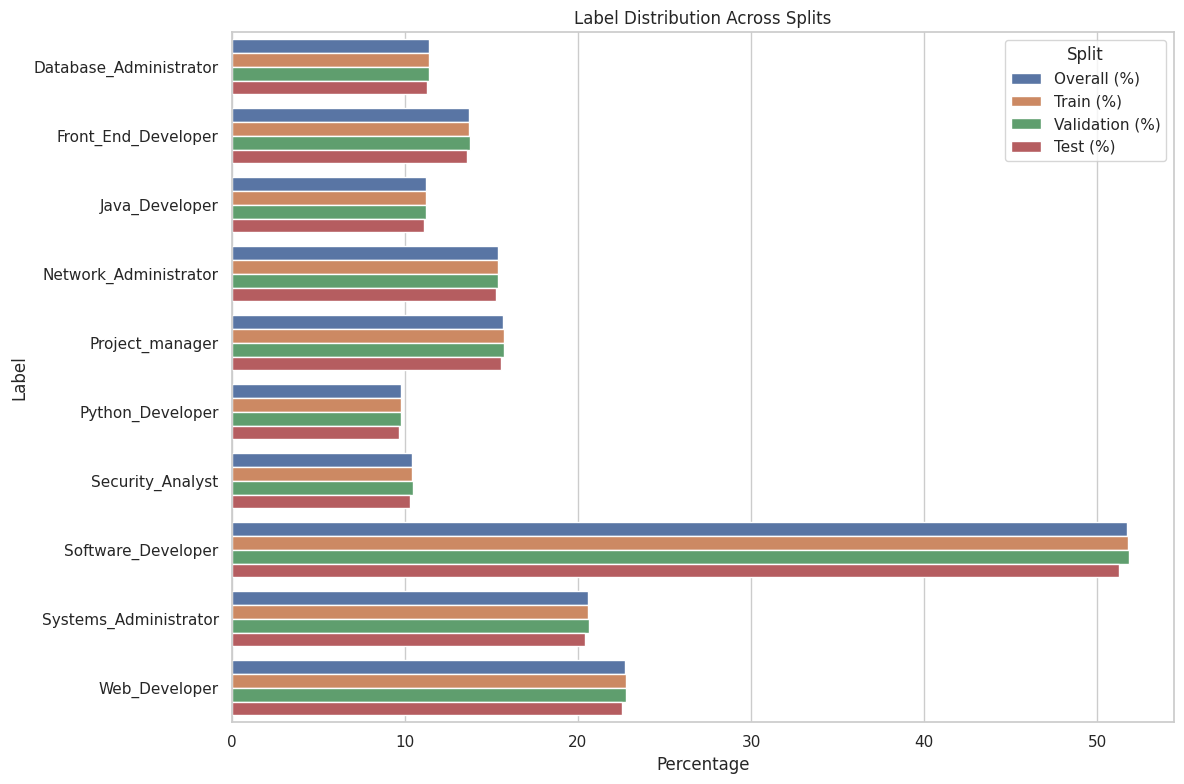

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.preprocessing import MultiLabelBinarizer

# ================================
# 1. Assuming the Following Variables Are Defined:
# - one_hot_labels: NumPy array of shape (num_resumes, num_classes)
# - mlb: MultiLabelBinarizer fitted on the labels
# - train_idx, val_idx, test_idx: NumPy arrays of indices for each split
# ================================

# Function to calculate and print split statistics
def verify_splits(one_hot_labels, mlb, train_idx, val_idx, test_idx):
    total_samples = one_hot_labels.shape[0]
    num_classes = one_hot_labels.shape[1]

    # Calculate number of samples in each split
    num_train = len(train_idx)
    num_val = len(val_idx)
    num_test = len(test_idx)

    # Calculate percentages
    perc_train = (num_train / total_samples) * 100
    perc_val = (num_val / total_samples) * 100
    perc_test = (num_test / total_samples) * 100

    print("=== Split Sizes ===")
    print(f"Total Samples: {total_samples}")
    print(f"Train: {num_train} samples ({perc_train:.2f}%)")
    print(f"Validation: {num_val} samples ({perc_val:.2f}%)")
    print(f"Test: {num_test} samples ({perc_test:.2f}%)\n")

    # Function to calculate label distribution
    def label_distribution(indices, split_name):
        labels = one_hot_labels[indices]
        label_counts = labels.sum(axis=0)
        label_percentages = (label_counts / len(indices)) * 100
        return label_counts, label_percentages

    # Calculate label distributions
    train_counts, train_perc = label_distribution(train_idx, "Train")
    val_counts, val_perc = label_distribution(val_idx, "Validation")
    test_counts, test_perc = label_distribution(test_idx, "Test")
    overall_counts, overall_perc = label_distribution(np.arange(total_samples), "Overall")

    # Create a DataFrame for comparison
    label_stats = pd.DataFrame({
        'Label': mlb.classes_,
        'Overall (%)': overall_perc,
        'Train (%)': train_perc,
        'Validation (%)': val_perc,
        'Test (%)': test_perc
    })

    # Display the label distribution
    print("=== Label Distribution (%) ===")
    print(label_stats.to_string(index=False))

    # Optionally, visualize the label distribution
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns

        sns.set(style="whitegrid")
        label_stats_melted = label_stats.melt(id_vars='Label',
                                             value_vars=['Overall (%)', 'Train (%)', 'Validation (%)', 'Test (%)'],
                                             var_name='Split', value_name='Percentage')

        plt.figure(figsize=(12, 8))
        sns.barplot(x='Percentage', y='Label', hue='Split', data=label_stats_melted)
        plt.title('Label Distribution Across Splits')
        plt.xlabel('Percentage')
        plt.ylabel('Label')
        plt.legend(title='Split')
        plt.tight_layout()
        plt.show()
    except ImportError:
        print("\nMatplotlib and Seaborn are not installed. Skipping the visualization step.")

# ================================
# 2. Execute the Verification Function
# ================================

# Example usage:
# Replace `train_idx`, `val_idx`, and `test_idx` with your actual split indices
verify_splits(one_hot_labels, mlb, train_idx, val_idx, test_idx)


## Hyperparameter tuning

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, f1_score, cohen_kappa_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from scipy.sparse import csr_matrix
import numpy as np
import pandas as pd
import random
import optuna  # New import for Optuna


In [ ]:
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

set_seeds(42)


In [ ]:
# Assuming 'data_cleaned' is your DataFrame containing 'resume' and 'label_list' columns
def preprocess_data(data_cleaned):
    # Extract labels
    y = data_cleaned['label_list'].tolist()

    # Initialize MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    one_hot_labels = mlb.fit_transform(y)
    num_classes = one_hot_labels.shape[1]

    print("\nClasses:", mlb.classes_)
    print("One-Hot Encoded Labels:\n", one_hot_labels)

    # Feature Extraction with TF-IDF
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    tfidf_features = tfidf_vectorizer.fit_transform(data_cleaned['resume'])
    print("\nTF-IDF Feature Shape:", tfidf_features.shape)

    # Scaling TF-IDF Features
    scaler = StandardScaler(with_mean=False)
    scaled_tfidf = scaler.fit_transform(tfidf_features).toarray()
    print("Scaled TF-IDF Feature Shape:", scaled_tfidf.shape)

    # Graph Construction
    num_resumes = len(data_cleaned['resume'])
    job_labels = mlb.classes_
    num_jobs = len(job_labels)
    total_nodes = num_resumes + num_jobs

    edges = []
    for idx, labels in enumerate(y):
        resume_node = idx
        for label in labels:
            job_idx = np.where(mlb.classes_ == label)[0][0]
            job_node = num_resumes + job_idx
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    print("\nEdge Index:\n", edge_index)
    print("\nNumber of Nodes:", total_nodes)
    print("Number of Edges:", edge_index.size(1))

    # Feature Construction for All Nodes
    onehot_encoder = MultiLabelBinarizer()
    unique_jobs = [[label] for label in job_labels]
    job_features = onehot_encoder.fit_transform(unique_jobs)
    print("\nJob Features Shape:", job_features.shape)

    tfidf_dim = scaled_tfidf.shape[1]
    padding_dim = tfidf_dim - job_features.shape[1]
    if padding_dim < 0:
        raise ValueError("TF-IDF dimension is smaller than the number of job features.")

    job_features_padded = np.hstack([job_features, np.zeros((num_jobs, padding_dim))])
    print("Padded Job Features Shape:", job_features_padded.shape)

    combined_features = np.vstack([scaled_tfidf, job_features_padded])
    print("Combined Features Shape:", combined_features.shape)

    # Stratified Splitting (60% Train, 20% Val, 20% Test)
    X = np.arange(num_resumes)
    y_labels = one_hot_labels

    msss_train = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
    train_idx, temp_idx = next(msss_train.split(X, y_labels))

    msss_val_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    val_temp_idx, test_temp_idx = next(msss_val_test.split(X[temp_idx], y_labels[temp_idx]))

    val_idx = temp_idx[val_temp_idx]
    test_idx = temp_idx[test_temp_idx]

    # Initialize all masks as False
    train_mask = torch.zeros(total_nodes, dtype=torch.bool)
    val_mask = torch.zeros(total_nodes, dtype=torch.bool)
    test_mask = torch.zeros(total_nodes, dtype=torch.bool)

    # Setting masks
    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True

    print("\nStratified Train Indices:", train_idx)
    print("Stratified Validation Indices:", val_idx)
    print("Stratified Test Indices:", test_idx)

    # Creating the PyG Data Object with Masks
    one_hot_labels_padded = np.vstack([one_hot_labels, np.zeros((num_jobs, num_classes))])
    labels = torch.tensor(one_hot_labels_padded, dtype=torch.float)

    x = torch.tensor(combined_features, dtype=torch.float)

    data = Data(
        x=x,
        edge_index=edge_index,
        y=labels,
        train_mask=train_mask,
        val_mask=val_mask,
        test_mask=test_mask
    )

    data.num_classes = num_classes

    print("\nPyG Data Object with Masks:")
    print(data)

    return data, mlb


In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x  # Outputs raw logits


In [ ]:
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data, mlb):
    model.eval()
    with torch.no_grad():
        out = model(data)
        y_pred = torch.sigmoid(out).cpu().numpy()

        # Extract predictions and true labels for validation set
        val_pred = (y_pred[data.val_mask] >= 0.5).astype(int)
        val_true = data.y[data.val_mask].cpu().numpy()

        # Classification Report for Validation Set
        print("\nValidation Classification Report:")
        print(classification_report(val_true, val_pred, target_names=mlb.classes_, zero_division=0))

        # Flatten the arrays for multi-label case to use Cohen's kappa score
        val_true_flat = val_true.flatten()
        val_pred_flat = val_pred.flatten()

        # Calculate Cohen's Kappa Score
        kappa_val = cohen_kappa_score(val_true_flat, val_pred_flat)
        print(f"Cohen's Kappa Score (Validation Set): {kappa_val:.4f}")

        # Calculate Weighted F1-score for Validation Set
        weighted_f1 = f1_score(val_true, val_pred, average='weighted')
        print(f"Weighted F1-score (Validation Set): {weighted_f1:.4f}")

        # Compute ROC AUC for Validation Set
        try:
            auc_val = roc_auc_score(val_true, y_pred[data.val_mask], average='macro')
            print(f"ROC AUC Score (Validation Set): {auc_val:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Validation Set) could not be computed: {e}")


In [ ]:
# Preprocess the data
data, mlb = preprocess_data(data_cleaned)



Classes: ['Database_Administrator' 'Front_End_Developer' 'Java_Developer'
 'Network_Administrator' 'Project_manager' 'Python_Developer'
 'Security_Analyst' 'Software_Developer' 'Systems_Administrator'
 'Web_Developer']
One-Hot Encoded Labels:
 [[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 1 0 1]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 1 0 1]]

TF-IDF Feature Shape: (29035, 5000)
Scaled TF-IDF Feature Shape: (29035, 5000)

Edge Index:
 tensor([[    0, 29035,     1,  ..., 29042, 29034, 29044],
        [29035,     0, 29035,  ..., 29034, 29044, 29034]])

Number of Nodes: 29045
Number of Edges: 105944

Job Features Shape: (10, 10)
Padded Job Features Shape: (10, 5000)
Combined Features Shape: (29045, 5000)

Stratified Train Indices: [    2     3     5 ... 29030 29031 29034]
Stratified Validation Indices: [    0     7    10 ... 29028 29032 29033]
Stratified Test Indices: [    1     4     9 ... 29014 29025 29027]

PyG Data Object with Masks:
Data(x=[29045, 5000], edge_inde

In [ ]:
def objective(trial):
    # Hyperparameter suggestions
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    hidden_dim = trial.suggest_int('hidden_dim', 16, 128, step=16)
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.7, step=0.1)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)

    # Initialize the model
    model = GCN(input_dim=data.num_node_features,
                hidden_dim=hidden_dim,
                output_dim=data.num_classes,
                dropout_rate=dropout_rate)

    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.BCEWithLogitsLoss()

    # Implement Early Stopping
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0

    max_epochs = 50  # Reduced epochs for tuning

    for epoch in range(1, max_epochs + 1):
        loss = train(model, data, optimizer, criterion)

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask]).item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            break  # Early stopping

    return best_val_loss


In [ ]:
# Create an Optuna study
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))

# Optimize the study
study.optimize(objective, n_trials=5, timeout=1800)  # Adjust n_trials and timeout as needed

print("Number of finished trials:", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value (Validation Loss):", trial.value)
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2024-10-20 18:07:55,346] A new study created in memory with name: no-name-782bf914-3d2a-45bc-9124-c8747c0ee167
<ipython-input-18-4944b16593d2>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
<ipython-input-18-4944b16593d2>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)
[I 2024-10-20 18:10:29,697] Trial 0 finished with value: 0.13368576765060425 and parameters: {'lr': 0.0005611516415334506, 'hidden_dim': 128, 'dropout_rate': 0.6000000000000001, 'weight_decay': 6.251373574521755e-05}. Best is trial 0 with value: 0.13368576765060425.
[I 2024-10-20 18:11

Number of finished trials: 5
Best trial:
  Value (Validation Loss): 0.11761177331209183
  Params:
    lr: 0.0015930522616241021
    hidden_dim: 96
    dropout_rate: 0.3
    weight_decay: 0.0008123245085588687


In [ ]:
# Visualize the optimization history
import matplotlib.pyplot as plt
optuna.visualization.plot_optimization_history(study)
plt.show()

# Visualize the hyperparameter importance
optuna.visualization.plot_param_importances(study)
plt.show()

best_params = study.best_trial.params
print("Best Hyperparameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")


Best Hyperparameters:
lr: 0.0015930522616241021
hidden_dim: 96
dropout_rate: 0.3
weight_decay: 0.0008123245085588687


In [ ]:
def train_final_model(data, mlb, best_params):
    # Initialize the model with best hyperparameters
    model = GCN(
        input_dim=data.num_node_features,
        hidden_dim=best_params['hidden_dim'],
        output_dim=data.num_classes,
        dropout_rate=best_params['dropout_rate']
    )

    # Define optimizer and loss function
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=best_params['lr'],
        weight_decay=best_params['weight_decay']
    )
    criterion = torch.nn.BCEWithLogitsLoss()

    # Training parameters
    max_epochs = 200  # Increased epochs for final training
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, max_epochs + 1):
        loss = train(model, data, optimizer, criterion)

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask]).item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_gcn_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        if epoch % 20 == 0 or epoch == 1:
            # Calculate training accuracy
            preds = torch.sigmoid(out[data.train_mask]) >= 0.5
            correct = preds.eq(data.y[data.train_mask] >= 0.5).sum().item()
            acc = correct / data.train_mask.sum().item()
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {acc:.4f}')

    # Load the best model
    model.load_state_dict(torch.load('best_gcn_model.pth'))

    return model

# Retrieve the best hyperparameters
best_params = study.best_trial.params
print("Best Hyperparameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")

# Train the final model
final_model = train_final_model(data, mlb, best_params)

# Define final evaluation function with test set
def evaluate_final_model(model, data, mlb):
    model.eval()
    with torch.no_grad():
        out = model(data)
        y_pred = torch.sigmoid(out).cpu().numpy()

        # Validation Set Evaluation
        val_pred = (y_pred[data.val_mask] >= 0.5).astype(int)
        val_true = data.y[data.val_mask].cpu().numpy()

        print("\nValidation Classification Report:")
        print(classification_report(val_true, val_pred, target_names=mlb.classes_, zero_division=0))

        val_true_flat = val_true.flatten()
        val_pred_flat = val_pred.flatten()

        kappa_val = cohen_kappa_score(val_true_flat, val_pred_flat)
        print(f"Cohen's Kappa Score (Validation Set): {kappa_val:.4f}")

        weighted_f1 = f1_score(val_true, val_pred, average='weighted')
        print(f"Weighted F1-score (Validation Set): {weighted_f1:.4f}")

        try:
            auc_val = roc_auc_score(val_true, y_pred[data.val_mask], average='macro')
            print(f"ROC AUC Score (Validation Set): {auc_val:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Validation Set) could not be computed: {e}")

        '''# Test Set Evaluation
        test_pred = (y_pred[data.test_mask] >= 0.5).astype(int)
        test_true = data.y[data.test_mask].cpu().numpy()

        print("\nTest Classification Report:")
        print(classification_report(test_true, test_pred, target_names=mlb.classes_, zero_division=0))

        test_true_flat = test_true.flatten()
        test_pred_flat = test_pred.flatten()

        kappa_test = cohen_kappa_score(test_true_flat, test_pred_flat)
        print(f"Cohen's Kappa Score (Test Set): {kappa_test:.4f}")

        weighted_f1_test = f1_score(test_true, test_pred, average='weighted')
        print(f"Weighted F1-score (Test Set): {weighted_f1_test:.4f}")

        try:
            auc_test = roc_auc_score(test_true, y_pred[data.test_mask], average='macro')
            print(f"ROC AUC Score (Test Set): {auc_test:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Test Set) could not be computed: {e}")'''

# Evaluate the final model
evaluate_final_model(final_model, data, mlb)


Best Hyperparameters:
lr: 0.0015930522616241021
hidden_dim: 96
dropout_rate: 0.3
weight_decay: 0.0008123245085588687
Epoch: 001, Loss: 0.6682, Val Loss: 0.4172, Train Accuracy: 8.5272
Epoch: 020, Loss: 0.1486, Val Loss: 0.1240, Train Accuracy: 9.5822
Epoch: 040, Loss: 0.1182, Val Loss: 0.0954, Train Accuracy: 9.6387
Epoch: 060, Loss: 0.0887, Val Loss: 0.0794, Train Accuracy: 9.7404
Epoch: 080, Loss: 0.0910, Val Loss: 0.0725, Train Accuracy: 9.7536
Epoch: 100, Loss: 0.0660, Val Loss: 0.0626, Train Accuracy: 9.8019
Early stopping at epoch 111


<ipython-input-22-46e0afa1cff1>:53: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.




Validation Classification Report:
                        precision    recall  f1-score   support

Database_Administrator       1.00      0.95      0.97       660
   Front_End_Developer       0.98      0.86      0.91       796
        Java_Developer       0.95      0.98      0.97       651
 Network_Administrator       0.95      0.92      0.94       892
       Project_manager       0.98      0.94      0.96       910
      Python_Developer       0.98      0.96      0.97       567
      Security_Analyst       0.99      0.96      0.97       605
    Software_Developer       1.00      0.99      0.99      3003
 Systems_Administrator       0.94      0.92      0.93      1194
         Web_Developer       0.75      0.83      0.79      1319

             micro avg       0.95      0.93      0.94     10597
             macro avg       0.95      0.93      0.94     10597
          weighted avg       0.95      0.93      0.94     10597
           samples avg       0.96      0.96      0.95     10597

Co

<ipython-input-23-8409f48e6c09>:38: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-23-8409f48e6c09>:38: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-23-8409f48e6c09>:38: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




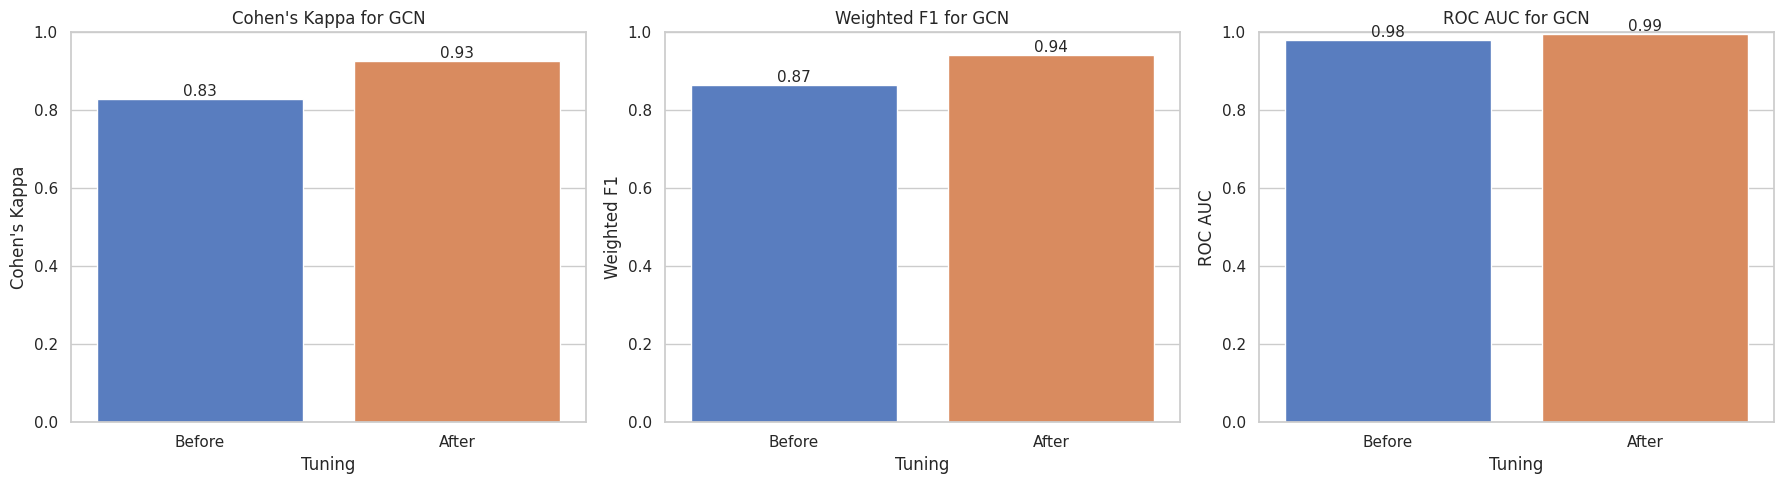

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Define your data for GCN only
data_gcn = {
    'Model': ['GCN', 'GCN'],
    'Tuning': ['Before', 'After'],
    'Cohen\'s Kappa': [
        0.8291,  # Replace with your actual GCN score before tuning
        0.9265   # Replace with your actual GCN score after tuning
    ],
    'Weighted F1': [
        0.8660,  # Replace with your actual GCN Weighted F1 before tuning
        0.9410   # Replace with your actual GCN Weighted F1 after tuning
    ],
    'ROC AUC': [
        0.9814,  # Replace with your actual GCN ROC AUC before tuning
        0.9946   # Replace with your actual GCN ROC AUC after tuning
    ]
}

# Create the DataFrame
df_gcn = pd.DataFrame(data_gcn)

# List of metrics to plot
metrics = ["Cohen's Kappa", 'Weighted F1', 'ROC AUC']

# Set up the matplotlib figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Iterate over the metrics and corresponding axes to create individual plots
for ax, metric in zip(axes, metrics):
    sns.barplot(
        x='Tuning',
        y=metric,
        data=df_gcn,
        palette='muted',
        ax=ax
    )
    ax.set_title(f'{metric} for GCN')
    ax.set_ylim(0, 1)  # Adjust if your metrics have different scales
    # Annotate bars with their respective values
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=11)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()


Cleaned DataFrame:
   Tuning         Metric   Score
0  Before  Cohen's Kappa  0.8291
1   After  Cohen's Kappa  0.9265
2  Before    Weighted F1  0.8660
3   After    Weighted F1  0.9410
4  Before        ROC AUC  0.9814
5   After        ROC AUC  0.9946


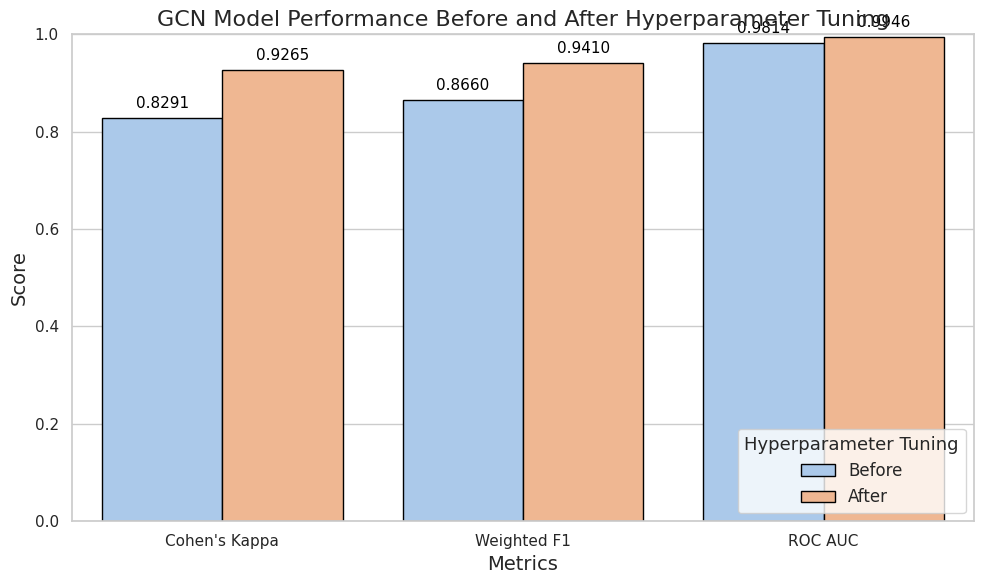

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Define your cleaned data for GCN only
data_gcn_clean = {
    'Tuning': ['Before', 'After', 'Before', 'After', 'Before', 'After'],
    'Metric': ["Cohen's Kappa", "Cohen's Kappa", 'Weighted F1', 'Weighted F1', 'ROC AUC', 'ROC AUC'],
    'Score': [0.8291, 0.9265, 0.8660, 0.9410, 0.9814, 0.9946]
}

# Create the cleaned DataFrame
df_clean = pd.DataFrame(data_gcn_clean)

# Display the cleaned DataFrame for verification
print("Cleaned DataFrame:")
print(df_clean)

# Verify that all 'Score' values are numeric and greater than zero
if df_clean['Score'].isnull().any():
    raise ValueError("There are NaN values in the 'Score' column. Please check your data.")
if (df_clean['Score'] <= 0).any():
    print("Warning: There are non-positive values in the 'Score' column.")

# Initialize the matplotlib figure
plt.figure(figsize=(10, 6))

# Create a grouped barplot directly using the cleaned DataFrame
ax = sns.barplot(
    x='Metric',
    y='Score',
    hue='Tuning',
    data=df_clean,
    palette='pastel',
    edgecolor='black'
)

# Add titles and labels
plt.title('GCN Model Performance Before and After Hyperparameter Tuning', fontsize=16)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Score', fontsize=14)

# Set y-axis limits
plt.ylim(0, 1)  # All your metrics are between 0 and 1

# Add value labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    # Only annotate bars with height greater than zero
    if height > 0:
        ax.annotate(f'{height:.4f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')

# Improve legend: move it to the bottom right
plt.legend(title='Hyperparameter Tuning', fontsize=12, title_fontsize=13,
           loc='lower right', bbox_to_anchor=(1, 0))

# Adjust layout to make room for the legend
plt.tight_layout()

# Display the plot
plt.show()

# Optionally, save the plot as a PNG file
# plt.savefig('gcn_performance_comparison_single_plot.png', dpi=300)


Cleaned DataFrame:
   Tuning         Metric   Score
0  Before  Cohen's Kappa  0.8291
1   After  Cohen's Kappa  0.9265
2  Before    Weighted F1  0.8660
3   After    Weighted F1  0.9410
4  Before        ROC AUC  0.9814
5   After        ROC AUC  0.9946


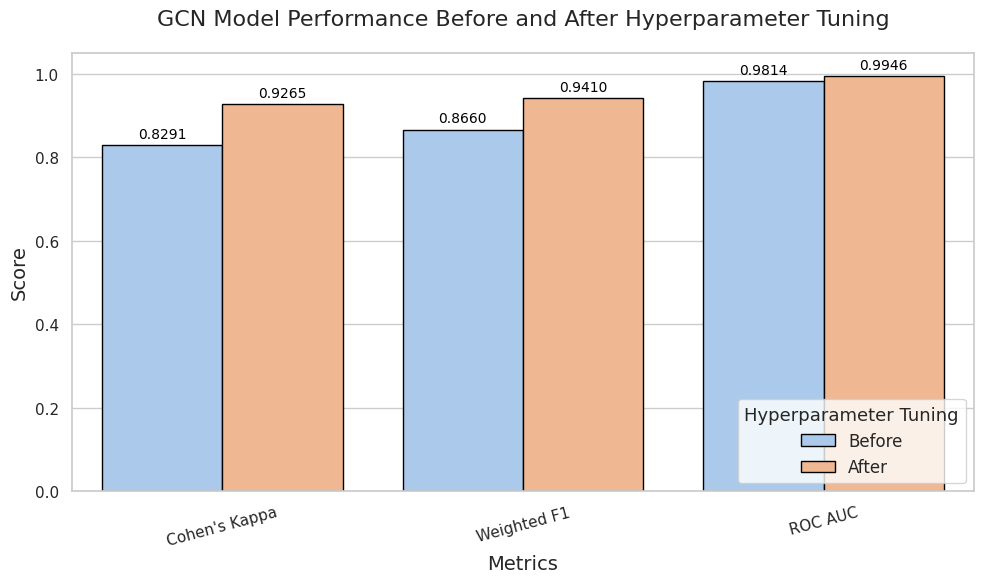

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Define your cleaned data for GCN only
data_gcn_clean = {
    'Tuning': ['Before', 'After', 'Before', 'After', 'Before', 'After'],
    'Metric': ["Cohen's Kappa", "Cohen's Kappa", 'Weighted F1', 'Weighted F1', 'ROC AUC', 'ROC AUC'],
    'Score': [0.8291, 0.9265, 0.8660, 0.9410, 0.9814, 0.9946]
}

# Create the cleaned DataFrame
df_clean = pd.DataFrame(data_gcn_clean)

# Display the cleaned DataFrame for verification
print("Cleaned DataFrame:")
print(df_clean)

# Verify that all 'Score' values are numeric and greater than zero
if df_clean['Score'].isnull().any():
    raise ValueError("There are NaN values in the 'Score' column. Please check your data.")
if (df_clean['Score'] <= 0).any():
    print("Warning: There are non-positive values in the 'Score' column.")

# Initialize the matplotlib figure with increased height to accommodate annotations
plt.figure(figsize=(10, 6))

# Create a grouped barplot directly using the cleaned DataFrame
ax = sns.barplot(
    x='Metric',
    y='Score',
    hue='Tuning',
    data=df_clean,
    palette='pastel',  # Change to 'deep', 'muted', etc., if desired
    edgecolor='black'
)

# Add titles and labels with optional padding
plt.title('GCN Model Performance Before and After Hyperparameter Tuning', fontsize=16, pad=20)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Score', fontsize=14)

# Set y-axis limits slightly above 1 to prevent annotations from overlapping the title
plt.ylim(0, 1.05)  # Adjust as needed

# Rotate x-axis labels if necessary
plt.xticks(rotation=15)

# Add value labels on top of each bar with reduced offset and smaller font size
for p in ax.patches:
    height = p.get_height()
    # Only annotate bars with height greater than zero
    if height > 0:
        ax.annotate(f'{height:.4f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 3),
                    textcoords='offset points')

# Improve legend: move it to the bottom right
plt.legend(title='Hyperparameter Tuning', fontsize=12, title_fontsize=13,
           loc='lower right', bbox_to_anchor=(1, 0))

# Adjust layout to make room for the legend and prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

# Optionally, save the plot as a PNG file
# plt.savefig('gcn_performance_comparison_single_plot.png', dpi=300)


In [ ]:
pip install torch torch_geometric scikit-learn optuna iterative-stratification


  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
  Using cached optuna-4.0.0-py3-none-any.whl.metadata (16 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.3 MB/s eta 0:00:00


In [ ]:
import random
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, cohen_kappa_score, f1_score, roc_auc_score
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import optuna

def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

set_seeds(42)

# Assuming 'data_cleaned' is your DataFrame containing 'resume' and 'label_list' columns
def preprocess_data(data_cleaned):
    # Extract labels
    y = data_cleaned['label_list'].tolist()

    # Initialize MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    one_hot_labels = mlb.fit_transform(y)
    num_classes = one_hot_labels.shape[1]

    print("\nClasses:", mlb.classes_)
    print("One-Hot Encoded Labels:\n", one_hot_labels)

    # Stratified Splitting (60% Train, 20% Val, 20% Test)
    X = np.arange(len(data_cleaned))
    y_labels = one_hot_labels

    msss_train = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
    train_idx, temp_idx = next(msss_train.split(X, y_labels))

    msss_val_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    val_temp_idx, test_temp_idx = next(msss_val_test.split(X[temp_idx], y_labels[temp_idx]))

    val_idx = temp_idx[val_temp_idx]
    test_idx = temp_idx[test_temp_idx]

    # Feature Extraction with TF-IDF (fit on training data)
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    tfidf_vectorizer.fit(data_cleaned['resume'].iloc[train_idx])
    tfidf_features = tfidf_vectorizer.transform(data_cleaned['resume'])
    print("\nTF-IDF Feature Shape:", tfidf_features.shape)

    # Scaling TF-IDF Features (fit on training data)
    scaler = StandardScaler(with_mean=False)
    scaler.fit(tfidf_features[train_idx])
    scaled_tfidf = scaler.transform(tfidf_features).toarray()
    print("Scaled TF-IDF Feature Shape:", scaled_tfidf.shape)

    # Prepare node features for resumes
    resume_features = scaled_tfidf  # shape (num_resumes, 5000)

    # Prepare job label nodes for each split
    job_labels = mlb.classes_
    num_jobs = len(job_labels)

    # Create job label nodes for each split
    num_splits = 3  # train, val, test
    total_job_nodes = num_jobs * num_splits
    total_resume_nodes = len(data_cleaned)
    total_nodes = total_resume_nodes + total_job_nodes

    # Create features for job label nodes
    # For simplicity, we'll use one-hot encoding for job labels
    job_features = np.eye(num_jobs)  # shape (10, 10)

    # Repeat job features for each split
    job_features_all = np.vstack([job_features for _ in range(num_splits)])  # shape (30, 10)
    print("\nJob Features Shape:", job_features_all.shape)

    # Pad job_features_all to match the dimension of resume_features
    tfidf_dim = resume_features.shape[1]  # 5000
    job_features_dim = job_features_all.shape[1]  # 10
    padding_dim = tfidf_dim - job_features_dim

    if padding_dim < 0:
        raise ValueError("TF-IDF dimension is smaller than the number of job features.")

    # Pad job_features_all with zeros
    job_features_padded = np.hstack([job_features_all, np.zeros((job_features_all.shape[0], padding_dim))])
    print("Padded Job Features Shape:", job_features_padded.shape)  # Should be (30, 5000)

    # Combine resume features and padded job features
    combined_features = np.vstack([resume_features, job_features_padded])
    print("Combined Features Shape:", combined_features.shape)  # Should be (total_nodes, 5000)

    # Construct edges
    edges = []

    # Mapping from job label to job node index per split
    job_node_offset = {
        'train': total_resume_nodes,
        'val': total_resume_nodes + num_jobs,
        'test': total_resume_nodes + 2 * num_jobs
    }

    # Helper function to get job node index for a label and split
    def get_job_node_index(label, split):
        job_idx = np.where(job_labels == label)[0][0]
        return job_node_offset[split] + job_idx

    # Construct edges for training data
    for idx in train_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'train')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    # Construct edges for validation data
    for idx in val_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'val')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    # Construct edges for test data
    for idx in test_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'test')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    print("\nEdge Index:\n", edge_index)
    print("\nNumber of Nodes:", total_nodes)
    print("Number of Edges:", edge_index.size(1))

    # Initialize all masks as False
    train_mask = torch.zeros(total_nodes, dtype=torch.bool)
    val_mask = torch.zeros(total_nodes, dtype=torch.bool)
    test_mask = torch.zeros(total_nodes, dtype=torch.bool)

    # Setting masks for resume nodes only
    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True

    print("\nStratified Train Indices:", train_idx)
    print("Stratified Validation Indices:", val_idx)
    print("Stratified Test Indices:", test_idx)

    # Prepare labels
    # For job label nodes, we can set labels to zeros (or any placeholder)
    # Since we're focusing on predicting labels for resume nodes
    zero_labels = np.zeros((total_job_nodes, num_classes))
    one_hot_labels_padded = np.vstack([one_hot_labels, zero_labels])
    labels = torch.tensor(one_hot_labels_padded, dtype=torch.float)

    x = torch.tensor(combined_features, dtype=torch.float)

    data = Data(
        x=x,
        edge_index=edge_index,
        y=labels,
        train_mask=train_mask,
        val_mask=val_mask,
        test_mask=test_mask
    )

    data.num_classes = num_classes
    data.num_node_features = x.shape[1]

    print("\nPyG Data Object with Masks:")
    print(data)

    return data, mlb

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x  # Outputs raw logits

def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data, mlb):
    model.eval()
    with torch.no_grad():
        out = model(data)
        y_pred = torch.sigmoid(out).cpu().numpy()

        # Extract predictions and true labels for validation set
        val_pred = (y_pred[data.val_mask] >= 0.5).astype(int)
        val_true = data.y[data.val_mask].cpu().numpy()

        # Classification Report for Validation Set
        print("\nValidation Classification Report:")
        print(classification_report(val_true, val_pred, target_names=mlb.classes_, zero_division=0))

        # Flatten the arrays for multi-label case to use Cohen's kappa score
        val_true_flat = val_true.flatten()
        val_pred_flat = val_pred.flatten()

        # Calculate Cohen's Kappa Score
        kappa_val = cohen_kappa_score(val_true_flat, val_pred_flat)
        print(f"Cohen's Kappa Score (Validation Set): {kappa_val:.4f}")

        # Calculate Weighted F1-score for Validation Set
        weighted_f1 = f1_score(val_true, val_pred, average='weighted')
        print(f"Weighted F1-score (Validation Set): {weighted_f1:.4f}")

        # Compute ROC AUC for Validation Set
        try:
            auc_val = roc_auc_score(val_true, y_pred[data.val_mask], average='macro')
            print(f"ROC AUC Score (Validation Set): {auc_val:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Validation Set) could not be computed: {e}")

def objective(trial):
    # Hyperparameter suggestions
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    hidden_dim = trial.suggest_int('hidden_dim', 16, 128, step=16)
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.7, step=0.1)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)

    # Initialize the model
    model = GCN(input_dim=data.num_node_features,
                hidden_dim=hidden_dim,
                output_dim=data.num_classes,
                dropout_rate=dropout_rate)

    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.BCEWithLogitsLoss()

    # Implement Early Stopping
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0

    max_epochs = 50  # Reduced epochs for tuning

    for epoch in range(1, max_epochs + 1):
        loss = train(model, data, optimizer, criterion)

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask]).item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            break  # Early stopping

    return best_val_loss

# Prepare your data
# Assuming 'data_cleaned' is your DataFrame containing 'resume' and 'label_list' columns
data, mlb = preprocess_data(data_cleaned)

# Run hyperparameter optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

def train_final_model(data, mlb, best_params):
    # Initialize the model with best hyperparameters
    model = GCN(
        input_dim=data.num_node_features,
        hidden_dim=best_params['hidden_dim'],
        output_dim=data.num_classes,
        dropout_rate=best_params['dropout_rate']
    )

    # Define optimizer and loss function
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=best_params['lr'],
        weight_decay=best_params['weight_decay']
    )
    criterion = torch.nn.BCEWithLogitsLoss()

    # Training parameters
    max_epochs = 200  # Increased epochs for final training
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, max_epochs + 1):
        loss = train(model, data, optimizer, criterion)

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask]).item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_gcn_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        if epoch % 20 == 0 or epoch == 1:
            # Calculate training accuracy
            preds = torch.sigmoid(out[data.train_mask]) >= 0.5
            correct = preds.eq(data.y[data.train_mask] >= 0.5).sum().item()
            acc = correct / data.train_mask.sum().item()
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {acc:.4f}')

    # Load the best model
    model.load_state_dict(torch.load('best_gcn_model.pth'))

    return model

# Retrieve the best hyperparameters
best_params = study.best_trial.params
print("Best Hyperparameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")

# Train the final model
final_model = train_final_model(data, mlb, best_params)

# Define final evaluation function with test set
def evaluate_final_model(model, data, mlb):
    model.eval()
    with torch.no_grad():
        out = model(data)
        y_pred = torch.sigmoid(out).cpu().numpy()

        # Validation Set Evaluation
        val_pred = (y_pred[data.val_mask] >= 0.5).astype(int)
        val_true = data.y[data.val_mask].cpu().numpy()

        print("\nValidation Classification Report:")
        print(classification_report(val_true, val_pred, target_names=mlb.classes_, zero_division=0))

        val_true_flat = val_true.flatten()
        val_pred_flat = val_pred.flatten()

        kappa_val = cohen_kappa_score(val_true_flat, val_pred_flat)
        print(f"Cohen's Kappa Score (Validation Set): {kappa_val:.4f}")

        weighted_f1 = f1_score(val_true, val_pred, average='weighted')
        print(f"Weighted F1-score (Validation Set): {weighted_f1:.4f}")

        try:
            auc_val = roc_auc_score(val_true, y_pred[data.val_mask], average='macro')
            print(f"ROC AUC Score (Validation Set): {auc_val:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Validation Set) could not be computed: {e}")

        # Test Set Evaluation
        test_pred = (y_pred[data.test_mask] >= 0.5).astype(int)
        test_true = data.y[data.test_mask].cpu().numpy()

        print("\nTest Classification Report:")
        print(classification_report(test_true, test_pred, target_names=mlb.classes_, zero_division=0))

        test_true_flat = test_true.flatten()
        test_pred_flat = test_pred.flatten()

        kappa_test = cohen_kappa_score(test_true_flat, test_pred_flat)
        print(f"Cohen's Kappa Score (Test Set): {kappa_test:.4f}")

        weighted_f1_test = f1_score(test_true, test_pred, average='weighted')
        print(f"Weighted F1-score (Test Set): {weighted_f1_test:.4f}")

        try:
            auc_test = roc_auc_score(test_true, y_pred[data.test_mask], average='macro')
            print(f"ROC AUC Score (Test Set): {auc_test:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Test Set) could not be computed: {e}")

# Evaluate the final model
evaluate_final_model(final_model, data, mlb)



Classes: ['Database_Administrator' 'Front_End_Developer' 'Java_Developer'
 'Network_Administrator' 'Project_manager' 'Python_Developer'
 'Security_Analyst' 'Software_Developer' 'Systems_Administrator'
 'Web_Developer']
One-Hot Encoded Labels:
 [[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 1 0 1]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 1 0 1]]

TF-IDF Feature Shape: (29035, 5000)
Scaled TF-IDF Feature Shape: (29035, 5000)

Job Features Shape: (30, 10)
Padded Job Features Shape: (30, 5000)
Combined Features Shape: (29065, 5000)

Edge Index:
 tensor([[    2, 29035,     3,  ..., 29062, 29027, 29056],
        [29035,     2, 29035,  ..., 29027, 29056, 29027]])

Number of Nodes: 29065
Number of Edges: 105944

Stratified Train Indices: [    2     3     5 ... 29030 29031 29034]
Stratified Validation Indices: [    0     7    10 ... 29028 29032 29033]
Stratified Test Indices: [    1     4     9 ... 29014 29025 29027]


[I 2024-10-25 10:18:28,298] A new study created in memory with name: no-name-ab5bf3f6-ea1f-499d-b529-092a3c605f49



PyG Data Object with Masks:
Data(x=[29065, 5000], edge_index=[2, 105944], y=[29065, 10], train_mask=[29065], val_mask=[29065], test_mask=[29065], num_classes=10, num_node_features=5000)


<ipython-input-10-2da214ef0916>:248: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
<ipython-input-10-2da214ef0916>:251: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)
[I 2024-10-25 10:19:20,589] Trial 0 finished with value: 0.11307866126298904 and parameters: {'lr': 0.0022103384073452925, 'hidden_dim': 128, 'dropout_rate': 0.5, 'weight_decay': 6.133600202008943e-05}. Best is trial 0 with value: 0.11307866126298904.
[I 2024-10-25 10:19:47,977] Trial 1 finished with value: 0.13593533635139465 and parameters: {'lr': 0.004569916687209764, 'hidden_dim': 32, 'dro

Best Hyperparameters:
lr: 0.008393176685282075
hidden_dim: 96
dropout_rate: 0.3
weight_decay: 1.3155832427827e-05
Epoch: 001, Loss: 0.7454, Val Loss: 1.1591, Train Accuracy: 8.4802
Epoch: 020, Loss: 0.1523, Val Loss: 0.1185, Train Accuracy: 9.5828
Epoch: 040, Loss: 0.0929, Val Loss: 0.0882, Train Accuracy: 9.6919
Epoch: 060, Loss: 0.0927, Val Loss: 0.0697, Train Accuracy: 9.7569
Epoch: 080, Loss: 0.0640, Val Loss: 0.0669, Train Accuracy: 9.8102
Epoch: 100, Loss: 0.0689, Val Loss: 0.0595, Train Accuracy: 9.8656
Early stopping at epoch 116


<ipython-input-10-2da214ef0916>:350: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_gcn_model.pth'))



Validation Classification Report:
                        precision    recall  f1-score   support

Database_Administrator       0.99      0.97      0.98       660
   Front_End_Developer       0.95      0.96      0.95       796
        Java_Developer       0.96      0.98      0.97       651
 Network_Administrator       0.93      0.96      0.95       892
       Project_manager       0.95      0.99      0.97       910
      Python_Developer       0.97      0.98      0.98       567
      Security_Analyst       0.98      0.99      0.98       605
    Software_Developer       1.00      0.98      0.99      3003
 Systems_Administrator       0.96      0.95      0.96      1194
         Web_Developer       0.89      0.81      0.85      1319

             micro avg       0.96      0.95      0.96     10597
             macro avg       0.96      0.96      0.96     10597
          weighted avg       0.96      0.95      0.96     10597
           samples avg       0.97      0.97      0.96     10597

Co

# Data leakage

In [ ]:
!pip install optuna torch_geometric iterative-stratification

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.2 MB/s eta 0:00:00


In [ ]:
import random
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, cohen_kappa_score, f1_score, roc_auc_score
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import optuna

def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

set_seeds(42)

# Assuming 'data_cleaned' is your DataFrame containing 'resume' and 'label_list' columns
def preprocess_data(data_cleaned):
    # Extract labels
    y = data_cleaned['label_list'].tolist()

    # Initialize MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    one_hot_labels = mlb.fit_transform(y)
    num_classes = one_hot_labels.shape[1]

    print("\nClasses:", mlb.classes_)
    print("One-Hot Encoded Labels:\n", one_hot_labels)

    # Stratified Splitting (60% Train, 20% Val, 20% Test)
    X = np.arange(len(data_cleaned))
    y_labels = one_hot_labels

    msss_train = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
    train_idx, temp_idx = next(msss_train.split(X, y_labels))

    msss_val_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    val_temp_idx, test_temp_idx = next(msss_val_test.split(X[temp_idx], y_labels[temp_idx]))

    val_idx = temp_idx[val_temp_idx]
    test_idx = temp_idx[test_temp_idx]

    # Feature Extraction with TF-IDF (fit on training data)
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    tfidf_vectorizer.fit(data_cleaned['resume'].iloc[train_idx])
    tfidf_features = tfidf_vectorizer.transform(data_cleaned['resume'])
    print("\nTF-IDF Feature Shape:", tfidf_features.shape)

    # Scaling TF-IDF Features (fit on training data)
    scaler = StandardScaler(with_mean=False)
    scaler.fit(tfidf_features[train_idx])
    scaled_tfidf = scaler.transform(tfidf_features).toarray()
    print("Scaled TF-IDF Feature Shape:", scaled_tfidf.shape)

    # Prepare node features for resumes
    resume_features = scaled_tfidf  # shape (num_resumes, 5000)

    # Prepare job label nodes for each split
    job_labels = mlb.classes_
    num_jobs = len(job_labels)

    # Create job label nodes for each split
    num_splits = 3  # train, val, test
    total_job_nodes = num_jobs * num_splits
    total_resume_nodes = len(data_cleaned)
    total_nodes = total_resume_nodes + total_job_nodes

    # Create features for job label nodes
    # For simplicity, we'll use one-hot encoding for job labels
    job_features = np.eye(num_jobs)  # shape (num_jobs, num_jobs)

    # Repeat job features for each split
    job_features_all = np.vstack([job_features for _ in range(num_splits)])  # shape (total_job_nodes, num_jobs)
    print("\nJob Features Shape:", job_features_all.shape)

    # Pad job_features_all to match the dimension of resume_features
    tfidf_dim = resume_features.shape[1]  # 5000
    job_features_dim = job_features_all.shape[1]  # num_jobs
    padding_dim = tfidf_dim - job_features_dim

    if padding_dim < 0:
        raise ValueError("TF-IDF dimension is smaller than the number of job features.")

    # Pad job_features_all with zeros
    job_features_padded = np.hstack([job_features_all, np.zeros((job_features_all.shape[0], padding_dim))])
    print("Padded Job Features Shape:", job_features_padded.shape)  # Should be (total_job_nodes, 5000)

    # Combine resume features and padded job features
    combined_features = np.vstack([resume_features, job_features_padded])
    print("Combined Features Shape:", combined_features.shape)  # Should be (total_nodes, 5000)

    # Construct edges
    edges = []

    # Mapping from job label to job node index per split
    job_node_offset = {
        'train': total_resume_nodes,
        'val': total_resume_nodes + num_jobs,
        'test': total_resume_nodes + 2 * num_jobs
    }

    # Helper function to get job node index for a label and split
    def get_job_node_index(label, split):
        job_idx = np.where(job_labels == label)[0][0]
        return job_node_offset[split] + job_idx

    # Construct edges for training data
    for idx in train_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'train')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    # Construct edges for validation data
    for idx in val_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'val')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    # Construct edges for test data
    for idx in test_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'test')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    print("\nEdge Index:\n", edge_index)
    print("\nNumber of Nodes:", total_nodes)
    print("Number of Edges:", edge_index.size(1))

    # Initialize all masks as False
    train_mask = torch.zeros(total_nodes, dtype=torch.bool)
    val_mask = torch.zeros(total_nodes, dtype=torch.bool)
    test_mask = torch.zeros(total_nodes, dtype=torch.bool)

    # Setting masks for resume nodes only
    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True

    print("\nStratified Train Indices:", train_idx)
    print("Stratified Validation Indices:", val_idx)
    print("Stratified Test Indices:", test_idx)

    # Prepare labels
    # For job label nodes, we can set labels to zeros (or any placeholder)
    # Since we're focusing on predicting labels for resume nodes
    zero_labels = np.zeros((total_job_nodes, num_classes))
    one_hot_labels_padded = np.vstack([one_hot_labels, zero_labels])
    labels = torch.tensor(one_hot_labels_padded, dtype=torch.float)

    x = torch.tensor(combined_features, dtype=torch.float)

    data = Data(
        x=x,
        edge_index=edge_index,
        y=labels,
        train_mask=train_mask,
        val_mask=val_mask,
        test_mask=test_mask
    )

    data.num_classes = num_classes
    data.num_node_features = x.shape[1]

    print("\nPyG Data Object with Masks:")
    print(data)

    return data, mlb

# Implementing filter_edge_index function
def filter_edge_index(edge_index, node_mask):
    # Get indices of nodes that are in the mask
    node_indices = torch.nonzero(node_mask, as_tuple=False).view(-1)
    node_indices_set = set(node_indices.tolist())

    # Filter edges where both source and target nodes are in node_indices_set
    mask = [(src in node_indices_set and dst in node_indices_set) for src, dst in edge_index.t().tolist()]
    filtered_edge_index = edge_index[:, mask]
    return filtered_edge_index

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x  # Outputs raw logits

def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    # Create subgraph for training
    train_data = Data(
        x=data.x[data.train_mask],
        edge_index=filter_edge_index(data.edge_index, data.train_mask),
        y=data.y[data.train_mask]
    )
    out = model(train_data)
    loss = criterion(out, train_data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data, mlb):
    model.eval()
    with torch.no_grad():
        out = model(data)
        y_pred = torch.sigmoid(out).cpu().numpy()

        # Extract predictions and true labels for validation set
        val_pred = (y_pred[data.val_mask] >= 0.5).astype(int)
        val_true = data.y[data.val_mask].cpu().numpy()

        # Classification Report for Validation Set
        print("\nValidation Classification Report:")
        print(classification_report(val_true, val_pred, target_names=mlb.classes_, zero_division=0))

        # Flatten the arrays for multi-label case to use Cohen's kappa score
        val_true_flat = val_true.flatten()
        val_pred_flat = val_pred.flatten()

        # Calculate Cohen's Kappa Score
        kappa_val = cohen_kappa_score(val_true_flat, val_pred_flat)
        print(f"Cohen's Kappa Score (Validation Set): {kappa_val:.4f}")

        # Calculate Weighted F1-score for Validation Set
        weighted_f1 = f1_score(val_true, val_pred, average='weighted')
        print(f"Weighted F1-score (Validation Set): {weighted_f1:.4f}")

        # Compute ROC AUC for Validation Set
        try:
            auc_val = roc_auc_score(val_true, y_pred[data.val_mask], average='macro')
            print(f"ROC AUC Score (Validation Set): {auc_val:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Validation Set) could not be computed: {e}")

def objective(trial):
    # Hyperparameter suggestions
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    hidden_dim = trial.suggest_int('hidden_dim', 16, 128, step=16)
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.7, step=0.1)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)

    # Initialize the model
    model = GCN(input_dim=data.num_node_features,
                hidden_dim=hidden_dim,
                output_dim=data.num_classes,
                dropout_rate=dropout_rate)

    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.BCEWithLogitsLoss()

    # Implement Early Stopping
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0

    max_epochs = 50  # Reduced epochs for tuning

    for epoch in range(1, max_epochs + 1):
        loss = train(model, data, optimizer, criterion)

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask]).item()

        trial.report(val_loss, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            break  # Early stopping

    return best_val_loss

# Prepare your data
# Assuming 'data_cleaned' is your DataFrame containing 'resume' and 'label_list' columns
data, mlb = preprocess_data(data_cleaned)

# Run hyperparameter optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

def train_final_model(data, mlb, best_params):
    # Initialize the model with best hyperparameters
    model = GCN(
        input_dim=data.num_node_features,
        hidden_dim=best_params['hidden_dim'],
        output_dim=data.num_classes,
        dropout_rate=best_params['dropout_rate']
    )

    # Define optimizer and loss function
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=best_params['lr'],
        weight_decay=best_params['weight_decay']
    )
    criterion = torch.nn.BCEWithLogitsLoss()

    # Training parameters
    max_epochs = 200  # Increased epochs for final training
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, max_epochs + 1):
        loss = train(model, data, optimizer, criterion)

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask]).item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_gcn_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        if epoch % 20 == 0 or epoch == 1:
            # Calculate training accuracy
            preds = torch.sigmoid(out[data.train_mask]) >= 0.5
            correct = preds.eq(data.y[data.train_mask] >= 0.5).sum().item()
            acc = correct / (data.y[data.train_mask].numel())
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {acc:.4f}')

    # Load the best model
    model.load_state_dict(torch.load('best_gcn_model.pth'))

    return model

# Retrieve the best hyperparameters
best_params = study.best_trial.params
print("Best Hyperparameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")

# Train the final model
final_model = train_final_model(data, mlb, best_params)

# Define final evaluation function with test set
def evaluate_final_model(model, data, mlb):
    model.eval()
    with torch.no_grad():
        out = model(data)
        y_pred = torch.sigmoid(out).cpu().numpy()

        # Validation Set Evaluation
        val_pred = (y_pred[data.val_mask] >= 0.5).astype(int)
        val_true = data.y[data.val_mask].cpu().numpy()

        print("\nValidation Classification Report:")
        print(classification_report(val_true, val_pred, target_names=mlb.classes_, zero_division=0))

        val_true_flat = val_true.flatten()
        val_pred_flat = val_pred.flatten()

        kappa_val = cohen_kappa_score(val_true_flat, val_pred_flat)
        print(f"Cohen's Kappa Score (Validation Set): {kappa_val:.4f}")

        weighted_f1 = f1_score(val_true, val_pred, average='weighted')
        print(f"Weighted F1-score (Validation Set): {weighted_f1:.4f}")

        try:
            auc_val = roc_auc_score(val_true, y_pred[data.val_mask], average='macro')
            print(f"ROC AUC Score (Validation Set): {auc_val:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Validation Set) could not be computed: {e}")

        # Test Set Evaluation
        test_pred = (y_pred[data.test_mask] >= 0.5).astype(int)
        test_true = data.y[data.test_mask].cpu().numpy()

        print("\nTest Classification Report:")
        print(classification_report(test_true, test_pred, target_names=mlb.classes_, zero_division=0))

        test_true_flat = test_true.flatten()
        test_pred_flat = test_pred.flatten()

        kappa_test = cohen_kappa_score(test_true_flat, test_pred_flat)
        print(f"Cohen's Kappa Score (Test Set): {kappa_test:.4f}")

        weighted_f1_test = f1_score(test_true, test_pred, average='weighted')
        print(f"Weighted F1-score (Test Set): {weighted_f1_test:.4f}")

        try:
            auc_test = roc_auc_score(test_true, y_pred[data.test_mask], average='macro')
            print(f"ROC AUC Score (Test Set): {auc_test:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Test Set) could not be computed: {e}")

# Evaluate the final model
evaluate_final_model(final_model, data, mlb)



Classes: ['Database_Administrator' 'Front_End_Developer' 'Java_Developer'
 'Network_Administrator' 'Project_manager' 'Python_Developer'
 'Security_Analyst' 'Software_Developer' 'Systems_Administrator'
 'Web_Developer']
One-Hot Encoded Labels:
 [[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 1 0 1]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 1 0 1]]

TF-IDF Feature Shape: (29035, 5000)
Scaled TF-IDF Feature Shape: (29035, 5000)

Job Features Shape: (30, 10)
Padded Job Features Shape: (30, 5000)
Combined Features Shape: (29065, 5000)

Edge Index:
 tensor([[    2, 29035,     3,  ..., 29062, 29027, 29056],
        [29035,     2, 29035,  ..., 29027, 29056, 29027]])

Number of Nodes: 29065
Number of Edges: 105944

Stratified Train Indices: [    2     3     5 ... 29030 29031 29034]
Stratified Validation Indices: [    0     7    10 ... 29028 29032 29033]
Stratified Test Indices: [    1     4     9 ... 29014 29025 29027]


[I 2024-10-27 11:47:49,124] A new study created in memory with name: no-name-2406958e-7979-42c8-a79b-265e05974304



PyG Data Object with Masks:
Data(x=[29065, 5000], edge_index=[2, 105944], y=[29065, 10], train_mask=[29065], val_mask=[29065], test_mask=[29065], num_classes=10, num_node_features=5000)


<ipython-input-7-6090f9bce140>:265: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
<ipython-input-7-6090f9bce140>:268: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)
[I 2024-10-27 11:48:23,581] Trial 0 finished with value: 0.2162286788225174 and parameters: {'lr': 0.004693847404564696, 'hidden_dim': 32, 'dropout_rate': 0.3, 'weight_decay': 1.2765125211420893e-05}. Best is trial 0 with value: 0.2162286788225174.
[I 2024-10-27 11:49:57,428] Trial 1 finished with value: 0.19715353846549988 and parameters: {'lr': 0.0005347993584792834, 'hidden_dim': 96, 'dropout

Best Hyperparameters:
lr: 0.002947186336558216
hidden_dim: 128
dropout_rate: 0.3
weight_decay: 1.1170055219626367e-06
Epoch: 001, Loss: 0.9315, Val Loss: 0.4835, Train Accuracy: 0.8349
Epoch: 020, Loss: 0.1578, Val Loss: 0.1613, Train Accuracy: 0.9643
Epoch: 040, Loss: 0.0882, Val Loss: 0.1482, Train Accuracy: 0.9706
Epoch: 060, Loss: 0.0570, Val Loss: 0.1361, Train Accuracy: 0.9733
Epoch: 080, Loss: 0.0407, Val Loss: 0.1289, Train Accuracy: 0.9764
Epoch: 100, Loss: 0.0311, Val Loss: 0.1241, Train Accuracy: 0.9779
Epoch: 120, Loss: 0.0253, Val Loss: 0.1214, Train Accuracy: 0.9788
Epoch: 140, Loss: 0.0207, Val Loss: 0.1197, Train Accuracy: 0.9789
Epoch: 160, Loss: 0.0180, Val Loss: 0.1182, Train Accuracy: 0.9791
Epoch: 180, Loss: 0.0154, Val Loss: 0.1176, Train Accuracy: 0.9794
Early stopping at epoch 188


<ipython-input-7-6090f9bce140>:372: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_gcn_model.pth'))



Validation Classification Report:
                        precision    recall  f1-score   support

Database_Administrator       1.00      0.81      0.89       660
   Front_End_Developer       0.93      0.86      0.89       796
        Java_Developer       0.97      0.75      0.85       651
 Network_Administrator       0.88      0.79      0.83       892
       Project_manager       1.00      0.71      0.83       910
      Python_Developer       0.98      0.71      0.82       567
      Security_Analyst       1.00      0.78      0.88       605
    Software_Developer       1.00      0.97      0.99      3003
 Systems_Administrator       0.86      0.76      0.80      1194
         Web_Developer       0.73      0.83      0.78      1319

             micro avg       0.92      0.84      0.88     10597
             macro avg       0.93      0.80      0.86     10597
          weighted avg       0.93      0.84      0.88     10597
           samples avg       0.92      0.89      0.88     10597

Co

## GCN Final model (Left)

### Final model (w/o class weight)

In [4]:
import random
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, cohen_kappa_score, f1_score, roc_auc_score
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

set_seeds(42)

# ========================================
# Data Preprocessing Function
# ========================================
def preprocess_data(data_cleaned):
    # Extract labels
    y = data_cleaned['label_list'].tolist()

    # Initialize MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    one_hot_labels = mlb.fit_transform(y)
    num_classes = one_hot_labels.shape[1]

    print("\nClasses:", mlb.classes_)
    print("One-Hot Encoded Labels Shape:", one_hot_labels.shape)

    # Stratified Splitting (60% Train, 20% Val, 20% Test)
    X = np.arange(len(data_cleaned))
    y_labels = one_hot_labels

    msss_train = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
    train_idx, temp_idx = next(msss_train.split(X, y_labels))

    msss_val_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    val_temp_idx, test_temp_idx = next(msss_val_test.split(X[temp_idx], y_labels[temp_idx]))

    val_idx = temp_idx[val_temp_idx]
    test_idx = temp_idx[test_temp_idx]

    # Feature Extraction with TF-IDF (fit on training data)
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    tfidf_vectorizer.fit(data_cleaned['resume'].iloc[train_idx])
    tfidf_features = tfidf_vectorizer.transform(data_cleaned['resume'])
    print("\nTF-IDF Feature Shape:", tfidf_features.shape)

    # Scaling TF-IDF Features (fit on training data)
    scaler = StandardScaler(with_mean=False)
    scaler.fit(tfidf_features[train_idx])
    scaled_tfidf = scaler.transform(tfidf_features).toarray()
    print("Scaled TF-IDF Feature Shape:", scaled_tfidf.shape)

    # Prepare node features for resumes
    resume_features = scaled_tfidf  # shape (num_resumes, 5000)

    # Prepare job label nodes for each split
    job_labels = mlb.classes_
    num_jobs = len(job_labels)

    # Create job label nodes for each split
    num_splits = 3  # train, val, test
    total_job_nodes = num_jobs * num_splits
    total_resume_nodes = len(data_cleaned)
    total_nodes = total_resume_nodes + total_job_nodes

    # Create features for job label nodes
    # For simplicity, we'll use one-hot encoding for job labels
    job_features = np.eye(num_jobs)  # shape (num_jobs, num_jobs)

    # Repeat job features for each split
    job_features_all = np.vstack([job_features for _ in range(num_splits)])  # shape (total_job_nodes, num_jobs)
    print("\nJob Features Shape:", job_features_all.shape)

    # Pad job_features_all to match the dimension of resume_features
    tfidf_dim = resume_features.shape[1]  # e.g., 5000
    job_features_dim = job_features_all.shape[1]  # e.g., num_jobs
    padding_dim = tfidf_dim - job_features_dim

    if padding_dim < 0:
        raise ValueError("TF-IDF dimension is smaller than the number of job features.")

    # Pad job_features_all with zeros
    job_features_padded = np.hstack([job_features_all, np.zeros((job_features_all.shape[0], padding_dim))])
    print("Padded Job Features Shape:", job_features_padded.shape)  # Should be (total_job_nodes, tfidf_dim)

    # Combine resume features and padded job features
    combined_features = np.vstack([resume_features, job_features_padded])
    print("Combined Features Shape:", combined_features.shape)  # Should be (total_nodes, tfidf_dim)

    # Construct edges
    edges = []

    # Mapping from job label to job node index per split
    job_node_offset = {
        'train': total_resume_nodes,
        'val': total_resume_nodes + num_jobs,
        'test': total_resume_nodes + 2 * num_jobs
    }

    # Helper function to get job node index for a label and split
    def get_job_node_index(label, split):
        job_idx = np.where(job_labels == label)[0][0]
        return job_node_offset[split] + job_idx

    # Construct edges for training data
    for idx in train_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'train')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    # Construct edges for validation data
    for idx in val_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'val')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    # Construct edges for test data
    for idx in test_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'test')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    print("\nEdge Index Shape:", edge_index.shape)
    print("Number of Nodes:", total_nodes)
    print("Number of Edges:", edge_index.size(1))

    # Initialize all masks as False
    train_mask = torch.zeros(total_nodes, dtype=torch.bool)
    val_mask = torch.zeros(total_nodes, dtype=torch.bool)
    test_mask = torch.zeros(total_nodes, dtype=torch.bool)

    # Setting masks for resume nodes only
    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True

    print("\nStratified Train Indices:", train_idx)
    print("Stratified Validation Indices:", val_idx)
    print("Stratified Test Indices:", test_idx)

    # Prepare labels
    # For job label nodes, we can set labels to zeros (or any placeholder)
    # Since we're focusing on predicting labels for resume nodes
    zero_labels = np.zeros((total_job_nodes, num_classes))
    one_hot_labels_padded = np.vstack([one_hot_labels, zero_labels])
    labels = torch.tensor(one_hot_labels_padded, dtype=torch.float)

    x = torch.tensor(combined_features, dtype=torch.float)

    data = Data(
        x=x,
        edge_index=edge_index,
        y=labels,
        train_mask=train_mask,
        val_mask=val_mask,
        test_mask=test_mask
    )

    data.num_classes = num_classes
    data.num_node_features = x.shape[1]

    print("\nPyG Data Object with Masks:")
    print(data)

    return data, mlb

# ========================================
# Implementing filter_edge_index Function
# ========================================
def filter_edge_index(edge_index, node_mask):
    # Get indices of nodes that are in the mask
    node_indices = torch.nonzero(node_mask, as_tuple=False).view(-1)
    node_indices_set = set(node_indices.tolist())

    # Filter edges where both source and target nodes are in node_indices_set
    mask = [(src in node_indices_set and dst in node_indices_set) for src, dst in edge_index.t().tolist()]
    filtered_edge_index = edge_index[:, mask]
    return filtered_edge_index

# ========================================
# Define the GCN Model
# ========================================
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x  # Outputs raw logits

# ========================================
# Training Function
# ========================================
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    # Create subgraph for training
    train_data = Data(
        x=data.x[data.train_mask],
        edge_index=filter_edge_index(data.edge_index, data.train_mask),
        y=data.y[data.train_mask]
    )
    out = model(train_data)
    loss = criterion(out, train_data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# ========================================
# Evaluation Function
# ========================================
def evaluate(model, data, mlb):
    model.eval()
    with torch.no_grad():
        out = model(data)
        y_pred = torch.sigmoid(out).cpu().numpy()

        # Extract predictions and true labels for validation set
        val_pred = (y_pred[data.val_mask] >= 0.5).astype(int)
        val_true = data.y[data.val_mask].cpu().numpy()

        # Classification Report for Validation Set
        print("\nValidation Classification Report:")
        print(classification_report(val_true, val_pred, target_names=mlb.classes_, zero_division=0))

        # Flatten the arrays for multi-label case to use Cohen's kappa score
        val_true_flat = val_true.flatten()
        val_pred_flat = val_pred.flatten()

        # Calculate Cohen's Kappa Score
        kappa_val = cohen_kappa_score(val_true_flat, val_pred_flat)
        print(f"Cohen's Kappa Score (Validation Set): {kappa_val:.4f}")

        # Calculate Weighted F1-score for Validation Set
        weighted_f1 = f1_score(val_true, val_pred, average='weighted')
        print(f"Weighted F1-score (Validation Set): {weighted_f1:.4f}")

        # Compute ROC AUC for Validation Set
        try:
            auc_val = roc_auc_score(val_true, y_pred[data.val_mask], average='macro')
            print(f"ROC AUC Score (Validation Set): {auc_val:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Validation Set) could not be computed: {e}")

# ========================================
# Prepare Data
# ========================================
# Assuming 'data_cleaned' is your DataFrame containing 'resume' and 'label_list' columns
data, mlb = preprocess_data(data_cleaned)

# ========================================
# Train Final Model with Best Hyperparameters
# ========================================
def train_final_model(data, mlb, best_params):
    # Initialize the model with best hyperparameters
    model = GCN(
        input_dim=data.num_node_features,
        hidden_dim=best_params['hidden_dim'],
        output_dim=data.num_classes,
        dropout_rate=best_params['dropout_rate']
    )

    # Define optimizer and loss function without class weights
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=best_params['lr'],
        weight_decay=best_params['weight_decay']
    )
    criterion = torch.nn.BCEWithLogitsLoss()  # No pos_weight parameter

    # Training parameters
    max_epochs = 200  # Increased epochs for final training
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, max_epochs + 1):
        loss = train(model, data, optimizer, criterion)

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask]).item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_gcn_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        if epoch % 20 == 0 or epoch == 1:
            # Calculate training accuracy
            preds = torch.sigmoid(out[data.train_mask]) >= 0.5
            correct = preds.eq(data.y[data.train_mask] >= 0.5).sum().item()
            acc = correct / data.y[data.train_mask].numel()
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {acc:.4f}')

    # Load the best model
    model.load_state_dict(torch.load('best_gcn_model.pth'))

    return model

# Best Hyperparameters:
best_params = {
    'lr': 0.002947186336558216,
    'hidden_dim': 128,
    'dropout_rate': 0.3,
    'weight_decay': 1.1170055219626367e-06
}

print("\nBest Hyperparameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")

# Train the final model
final_model = train_final_model(data, mlb, best_params)

# ========================================
# Evaluation Function for Final Model
# ========================================
def evaluate_final_model(model, data, mlb):
    model.eval()
    with torch.no_grad():
        out = model(data)
        y_pred = torch.sigmoid(out).cpu().numpy()

        # Validation Set Evaluation
        val_pred = (y_pred[data.val_mask] >= 0.5).astype(int)
        val_true = data.y[data.val_mask].cpu().numpy()

        print("\nValidation Classification Report:")
        print(classification_report(val_true, val_pred, target_names=mlb.classes_, zero_division=0))

        val_true_flat = val_true.flatten()
        val_pred_flat = val_pred.flatten()

        kappa_val = cohen_kappa_score(val_true_flat, val_pred_flat)
        print(f"Cohen's Kappa Score (Validation Set): {kappa_val:.4f}")

        weighted_f1 = f1_score(val_true, val_pred, average='weighted')
        print(f"Weighted F1-score (Validation Set): {weighted_f1:.4f}")

        try:
            auc_val = roc_auc_score(val_true, y_pred[data.val_mask], average='macro')
            print(f"ROC AUC Score (Validation Set): {auc_val:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Validation Set) could not be computed: {e}")

        # Test Set Evaluation
        test_pred = (y_pred[data.test_mask] >= 0.5).astype(int)
        test_true = data.y[data.test_mask].cpu().numpy()

        print("\nTest Classification Report:")
        print(classification_report(test_true, test_pred, target_names=mlb.classes_, zero_division=0))

        test_true_flat = test_true.flatten()
        test_pred_flat = test_pred.flatten()

        kappa_test = cohen_kappa_score(test_true_flat, test_pred_flat)
        print(f"Cohen's Kappa Score (Test Set): {kappa_test:.4f}")

        weighted_f1_test = f1_score(test_true, test_pred, average='weighted')
        print(f"Weighted F1-score (Test Set): {weighted_f1_test:.4f}")

        try:
            auc_test = roc_auc_score(test_true, y_pred[data.test_mask], average='macro')
            print(f"ROC AUC Score (Test Set): {auc_test:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Test Set) could not be computed: {e}")

# Evaluate the final model
evaluate_final_model(final_model, data, mlb)



Classes: ['Database_Administrator' 'Front_End_Developer' 'Java_Developer'
 'Network_Administrator' 'Project_manager' 'Python_Developer'
 'Security_Analyst' 'Software_Developer' 'Systems_Administrator'
 'Web_Developer']
One-Hot Encoded Labels Shape: (29035, 10)

TF-IDF Feature Shape: (29035, 5000)
Scaled TF-IDF Feature Shape: (29035, 5000)

Job Features Shape: (30, 10)
Padded Job Features Shape: (30, 5000)
Combined Features Shape: (29065, 5000)

Edge Index Shape: torch.Size([2, 105944])
Number of Nodes: 29065
Number of Edges: 105944

Stratified Train Indices: [    2     3     5 ... 29030 29031 29034]
Stratified Validation Indices: [    0     7    10 ... 29028 29032 29033]
Stratified Test Indices: [    1     4     9 ... 29014 29025 29027]

PyG Data Object with Masks:
Data(x=[29065, 5000], edge_index=[2, 105944], y=[29065, 10], train_mask=[29065], val_mask=[29065], test_mask=[29065], num_classes=10, num_node_features=5000)

Best Hyperparameters:
lr: 0.002947186336558216
hidden_dim: 128
d

<ipython-input-4-8677eef0f1e9>:336: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_gcn_model.pth'))



Validation Classification Report:
                        precision    recall  f1-score   support

Database_Administrator       1.00      0.85      0.92       660
   Front_End_Developer       0.99      0.80      0.88       796
        Java_Developer       0.96      0.86      0.91       651
 Network_Administrator       0.90      0.64      0.75       892
       Project_manager       1.00      0.58      0.73       910
      Python_Developer       0.99      0.76      0.86       567
      Security_Analyst       0.99      0.78      0.88       605
    Software_Developer       0.99      0.98      0.99      3003
 Systems_Administrator       0.81      0.61      0.70      1194
         Web_Developer       0.67      0.80      0.73      1319

             micro avg       0.91      0.80      0.85     10597
             macro avg       0.93      0.77      0.83     10597
          weighted avg       0.92      0.80      0.85     10597
           samples avg       0.89      0.86      0.85     10597

Co

### Threshold tuning

In [6]:
import numpy as np
from sklearn.metrics import precision_recall_curve

# Function to compute optimal thresholds for each class
def compute_optimal_thresholds(y_true, y_scores):
    num_classes = y_true.shape[1]
    optimal_thresholds = np.zeros(num_classes)

    for i in range(num_classes):
        y_true_class = y_true[:, i]
        y_scores_class = y_scores[:, i]

        # Compute precision-recall curve
        precision, recall, thresholds = precision_recall_curve(y_true_class, y_scores_class)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        f1_scores = np.nan_to_num(f1_scores)  # Handle potential NaN values
        index = np.argmax(f1_scores)

        if index < len(thresholds):
            optimal_threshold = thresholds[index]
        else:
            optimal_threshold = 0.5  # Default threshold if no valid threshold found

        optimal_thresholds[i] = optimal_threshold

    return optimal_thresholds

# Function to apply thresholds for predictions
def apply_thresholds(y_scores, thresholds):
    return (y_scores >= thresholds).astype(int)

# Evaluate model with optimal thresholds
def evaluate_model_with_thresholds(model, data, mlb):
    model.eval()
    with torch.no_grad():
        out = model(data)
        y_pred = torch.sigmoid(out).cpu().numpy()

        # Find optimal thresholds using validation set
        val_labels = data.y[data.val_mask].cpu().numpy()
        val_probs = y_pred[data.val_mask]

        optimal_thresholds = compute_optimal_thresholds(val_labels, val_probs)
        print("\nOptimal Thresholds per Class:")
        for idx, threshold in enumerate(optimal_thresholds):
            print(f"Class '{mlb.classes_[idx]}': {threshold:.4f}")

        # Apply optimal thresholds
        val_preds_thresholded = apply_thresholds(val_probs, optimal_thresholds)

        # Print classification report for validation set
        print("\nClassification Report (Validation Set) with Optimal Thresholds:")
        print(classification_report(val_labels, val_preds_thresholded, target_names=mlb.classes_, zero_division=0))

        val_labels_flat = val_labels.flatten()
        val_preds_flat = val_preds_thresholded.flatten()

        kappa_val = cohen_kappa_score(val_labels_flat, val_preds_flat)
        print(f"Cohen's Kappa Score (Validation Set): {kappa_val:.4f}")

        weighted_f1_val = f1_score(val_labels, val_preds_thresholded, average='weighted')
        print(f"Weighted F1-score (Validation Set): {weighted_f1_val:.4f}")

        try:
            auc_val = roc_auc_score(val_labels, val_probs, average='macro')
            print(f"ROC AUC Score (Validation Set): {auc_val:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Validation Set) could not be computed: {e}")

        # Evaluate on the test set using the same thresholds
        test_labels = data.y[data.test_mask].cpu().numpy()
        test_probs = y_pred[data.test_mask]
        test_preds_thresholded = apply_thresholds(test_probs, optimal_thresholds)

        print("\nClassification Report (Test Set) with Optimal Thresholds:")
        print(classification_report(test_labels, test_preds_thresholded, target_names=mlb.classes_, zero_division=0))

        test_labels_flat = test_labels.flatten()
        test_preds_flat = test_preds_thresholded.flatten()

        kappa_test = cohen_kappa_score(test_labels_flat, test_preds_flat)
        print(f"Cohen's Kappa Score (Test Set): {kappa_test:.4f}")

        weighted_f1_test = f1_score(test_labels, test_preds_thresholded, average='weighted')
        print(f"Weighted F1-score (Test Set): {weighted_f1_test:.4f}")

        try:
            auc_test = roc_auc_score(test_labels, test_probs, average='macro')
            print(f"ROC AUC Score (Test Set): {auc_test:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Test Set) could not be computed: {e}")

# Evaluate the final model with threshold tuning
evaluate_model_with_thresholds(final_model, data, mlb)



Optimal Thresholds per Class:
Class 'Database_Administrator': 0.3106
Class 'Front_End_Developer': 0.4615
Class 'Java_Developer': 0.3962
Class 'Network_Administrator': 0.2805
Class 'Project_manager': 0.3266
Class 'Python_Developer': 0.3122
Class 'Security_Analyst': 0.2794
Class 'Software_Developer': 0.4866
Class 'Systems_Administrator': 0.2517
Class 'Web_Developer': 0.5262

Classification Report (Validation Set) with Optimal Thresholds:
                        precision    recall  f1-score   support

Database_Administrator       0.98      0.95      0.96       660
   Front_End_Developer       0.98      0.83      0.90       796
        Java_Developer       0.93      0.96      0.95       651
 Network_Administrator       0.68      0.86      0.76       892
       Project_manager       0.92      0.78      0.85       910
      Python_Developer       0.97      0.91      0.94       567
      Security_Analyst       0.95      0.94      0.94       605
    Software_Developer       0.99      0.99   

In [8]:
# Evaluate model with optimal thresholds for train, validation, and test sets
def evaluate_model_with_thresholds_complete(model, data, mlb):
    """
    Evaluates the model on train, validation, and test sets using optimal thresholds.

    Args:
        model: Trained PyTorch model.
        data: PyG data object containing node features, edge index, and masks.
        mlb: MultiLabelBinarizer instance for label transformation.

    Returns:
        None
    """
    model.eval()
    with torch.no_grad():
        # Forward pass to get predictions
        out = model(data)
        y_pred = torch.sigmoid(out).cpu().numpy()

        # Compute optimal thresholds using the validation set
        val_labels = data.y[data.val_mask].cpu().numpy()
        val_probs = y_pred[data.val_mask]

        optimal_thresholds = compute_optimal_thresholds(val_labels, val_probs)
        print("\nOptimal Thresholds per Class:")
        for idx, threshold in enumerate(optimal_thresholds):
            print(f"Class '{mlb.classes_[idx]}': {threshold:.4f}")

        # Initialize a dictionary to store results
        results = {}

        # Evaluate on train, validation, and test sets
        for split_name, mask in [("Train", data.train_mask), ("Validation", data.val_mask), ("Test", data.test_mask)]:
            labels = data.y[mask].cpu().numpy()
            probs = y_pred[mask]

            # Apply thresholds
            preds_thresholded = apply_thresholds(probs, optimal_thresholds)

            # Classification Report
            print(f"\n{split_name} Classification Report:")
            print(classification_report(labels, preds_thresholded, target_names=mlb.classes_, zero_division=0))

            # Compute weighted F1-score
            weighted_f1 = f1_score(labels, preds_thresholded, average='weighted')
            print(f"Weighted F1-score ({split_name} Set): {weighted_f1:.4f}")

            # Compute ROC AUC
            try:
                auc_weighted = roc_auc_score(labels, probs, average='weighted')
                print(f"ROC AUC Score ({split_name} Set - Weighted Average): {auc_weighted:.4f}")
            except ValueError as e:
                print(f"ROC AUC Score ({split_name} Set) could not be computed: {e}")
                auc_weighted = np.nan

            # Compute per-class Cohen's Kappa and average
            num_classes = labels.shape[1]
            kappa_scores = []
            for i in range(num_classes):
                kappa = cohen_kappa_score(labels[:, i], preds_thresholded[:, i])
                kappa_scores.append(kappa)
            average_kappa = np.mean(kappa_scores)
            print(f"Average Cohen's Kappa Score ({split_name} Set): {average_kappa:.4f}")

            # Store results for summary
            results[split_name] = {
                "Weighted F1": weighted_f1,
                "Weighted ROC AUC": auc_weighted,
                "Average Kappa": average_kappa
            }

        # Summary of Results
        print("\n===== Summary of Metrics =====")
        for split_name in ["Train", "Validation", "Test"]:
            print(f"{split_name} Set - Weighted F1: {results[split_name]['Weighted F1']:.4f}, "
                  f"Weighted ROC AUC: {results[split_name]['Weighted ROC AUC']:.4f}, "
                  f"Average Kappa: {results[split_name]['Average Kappa']:.4f}")

# Evaluate the final model with threshold tuning
evaluate_model_with_thresholds_complete(final_model, data, mlb)



Optimal Thresholds per Class:
Class 'Database_Administrator': 0.3106
Class 'Front_End_Developer': 0.4615
Class 'Java_Developer': 0.3962
Class 'Network_Administrator': 0.2805
Class 'Project_manager': 0.3266
Class 'Python_Developer': 0.3122
Class 'Security_Analyst': 0.2794
Class 'Software_Developer': 0.4866
Class 'Systems_Administrator': 0.2517
Class 'Web_Developer': 0.5262

Train Classification Report:
                        precision    recall  f1-score   support

Database_Administrator       0.99      0.95      0.97      1979
   Front_End_Developer       0.98      0.84      0.90      2386
        Java_Developer       0.95      0.96      0.95      1951
 Network_Administrator       0.68      0.87      0.77      2676
       Project_manager       0.95      0.79      0.86      2730
      Python_Developer       0.98      0.90      0.94      1702
      Security_Analyst       0.94      0.93      0.94      1813
    Software_Developer       1.00      0.98      0.99      9008
 Systems_Administ

In [5]:
# ========================================
# Define Optimal Thresholds
# ========================================
optimal_thresholds = np.array([
    0.3738,  # Database_Administrator
    0.4790,  # Front_End_Developer
    0.4562,  # Java_Developer
    0.3600,  # Network_Administrator
    0.2966,  # Project_manager
    0.2994,  # Python_Developer
    0.4197,  # Security_Analyst
    0.4534,  # Software_Developer
    0.2785,  # Systems_Administrator
    0.5552   # Web_Developer
])

# ========================================
# Apply Optimal Thresholds
# ========================================
def apply_optimal_thresholds(y_pred, thresholds):
    """
    Applies optimal thresholds to the predicted probabilities.

    Args:
        y_pred (numpy.ndarray): Predicted probabilities (logits converted to probabilities).
        thresholds (numpy.ndarray): Optimal thresholds for each class.

    Returns:
        numpy.ndarray: Binary predictions after applying thresholds.
    """
    return (y_pred >= thresholds).astype(int)

# ========================================
# Final Evaluation Function with Thresholds
# ========================================
def evaluate_final_model_with_thresholds(model, data, mlb, thresholds):
    """
    Evaluates the final GCN model on train, validation, and test sets with optimal thresholds.

    Args:
        model: Trained GCN model.
        data: PyG data object.
        mlb: MultiLabelBinarizer instance.
        thresholds: Optimal thresholds for each class.

    Returns:
        None
    """
    model.eval()
    with torch.no_grad():
        # Forward pass to get predictions
        out = model(data)
        y_pred = torch.sigmoid(out).cpu().numpy()

        # Initialize results dictionary
        results = {}

        for split, mask in [("Train", data.train_mask), ("Validation", data.val_mask), ("Test", data.test_mask)]:
            # Apply thresholds
            y_pred_binary = apply_optimal_thresholds(y_pred[mask], thresholds)
            y_true = data.y[mask].cpu().numpy()

            # Classification Report
            print(f"\n{split} Classification Report:")
            print(classification_report(y_true, y_pred_binary, target_names=mlb.classes_, zero_division=0))

            # Weighted F1-score
            weighted_f1 = f1_score(y_true, y_pred_binary, average='weighted')
            print(f"Weighted F1-score ({split} Set): {weighted_f1:.4f}")

            # ROC AUC Score
            try:
                auc_weighted = roc_auc_score(y_true, y_pred[mask], average='weighted')
                print(f"ROC AUC Score ({split} Set - Weighted Average): {auc_weighted:.4f}")
            except ValueError as e:
                print(f"ROC AUC Score ({split} Set) could not be computed: {e}")
                auc_weighted = np.nan

            # Cohen's Kappa
            kappa_scores = []
            for i in range(len(mlb.classes_)):
                kappa = cohen_kappa_score(y_true[:, i], y_pred_binary[:, i])
                kappa_scores.append(kappa)
            average_kappa = np.mean(kappa_scores)
            print(f"Average Cohen's Kappa Score ({split} Set): {average_kappa:.4f}")

            # Store results for summary
            results[split] = {
                "Weighted F1": weighted_f1,
                "Weighted ROC AUC": auc_weighted,
                "Average Kappa": average_kappa
            }

        # Summary of Results
        print("\n===== Summary of Metrics =====")
        for split in ["Train", "Validation", "Test"]:
            print(f"{split} Set - Weighted F1: {results[split]['Weighted F1']:.4f}, "
                  f"Weighted ROC AUC: {results[split]['Weighted ROC AUC']:.4f}, "
                  f"Average Kappa: {results[split]['Average Kappa']:.4f}")

# ========================================
# Evaluate Final Model
# ========================================
evaluate_final_model_with_thresholds(final_model, data, mlb, optimal_thresholds)



Train Classification Report:
                        precision    recall  f1-score   support

Database_Administrator       0.99      0.94      0.97      1979
   Front_End_Developer       0.98      0.83      0.90      2386
        Java_Developer       0.96      0.91      0.93      1951
 Network_Administrator       0.75      0.77      0.76      2676
       Project_manager       0.92      0.81      0.86      2730
      Python_Developer       0.98      0.91      0.94      1702
      Security_Analyst       0.99      0.88      0.93      1813
    Software_Developer       0.99      0.99      0.99      9008
 Systems_Administrator       0.77      0.87      0.82      3581
         Web_Developer       0.79      0.79      0.79      3956

             micro avg       0.91      0.89      0.90     31782
             macro avg       0.91      0.87      0.89     31782
          weighted avg       0.91      0.89      0.90     31782
           samples avg       0.92      0.93      0.90     31782

Weighte

## GCN Final model (right SMOTE)

### Hyperparameter tuning for the model with class weight


In [ ]:
import random
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, cohen_kappa_score, f1_score, roc_auc_score
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import optuna

# ========================================
# Setting Seeds
# ========================================
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

set_seeds(42)

# ========================================
# Data Preprocessing Function
# ========================================
def preprocess_data(data_cleaned):
    # Extract labels
    y = data_cleaned['label_list'].tolist()
    mlb = MultiLabelBinarizer()
    one_hot_labels = mlb.fit_transform(y)
    num_classes = one_hot_labels.shape[1]

    # Stratified Splitting
    X = np.arange(len(data_cleaned))
    y_labels = one_hot_labels

    msss_train = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
    train_idx, temp_idx = next(msss_train.split(X, y_labels))

    msss_val_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    val_temp_idx, test_temp_idx = next(msss_val_test.split(X[temp_idx], y_labels[temp_idx]))

    val_idx = temp_idx[val_temp_idx]
    test_idx = temp_idx[test_temp_idx]

    tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    tfidf_vectorizer.fit(data_cleaned['resume'].iloc[train_idx])
    tfidf_features = tfidf_vectorizer.transform(data_cleaned['resume'])

    scaler = StandardScaler(with_mean=False)
    scaler.fit(tfidf_features[train_idx])
    scaled_tfidf = scaler.transform(tfidf_features).toarray()

    resume_features = scaled_tfidf
    job_labels = mlb.classes_
    num_jobs = len(job_labels)

    num_splits = 3
    total_job_nodes = num_jobs * num_splits
    total_resume_nodes = len(data_cleaned)
    total_nodes = total_resume_nodes + total_job_nodes

    job_features = np.eye(num_jobs)
    job_features_all = np.vstack([job_features for _ in range(num_splits)])

    padding_dim = resume_features.shape[1] - job_features_all.shape[1]
    job_features_padded = np.hstack([job_features_all, np.zeros((job_features_all.shape[0], padding_dim))])

    combined_features = np.vstack([resume_features, job_features_padded])

    edges = []
    job_node_offset = {
        'train': total_resume_nodes,
        'val': total_resume_nodes + num_jobs,
        'test': total_resume_nodes + 2 * num_jobs
    }

    def get_job_node_index(label, split):
        job_idx = np.where(job_labels == label)[0][0]
        return job_node_offset[split] + job_idx

    for idx in train_idx:
        labels = y[idx]
        for label in labels:
            job_node = get_job_node_index(label, 'train')
            edges.append((idx, job_node))
            edges.append((job_node, idx))

    for idx in val_idx:
        labels = y[idx]
        for label in labels:
            job_node = get_job_node_index(label, 'val')
            edges.append((idx, job_node))
            edges.append((job_node, idx))

    for idx in test_idx:
        labels = y[idx]
        for label in labels:
            job_node = get_job_node_index(label, 'test')
            edges.append((idx, job_node))
            edges.append((job_node, idx))

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    train_mask = torch.zeros(total_nodes, dtype=torch.bool)
    val_mask = torch.zeros(total_nodes, dtype=torch.bool)
    test_mask = torch.zeros(total_nodes, dtype=torch.bool)
    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True

    zero_labels = np.zeros((total_job_nodes, num_classes))
    one_hot_labels_padded = np.vstack([one_hot_labels, zero_labels])
    labels = torch.tensor(one_hot_labels_padded, dtype=torch.float)
    x = torch.tensor(combined_features, dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, y=labels, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
    data.num_classes = num_classes
    data.num_node_features = x.shape[1]
    return data, mlb

# ========================================
# GCN Model Definition
# ========================================
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

# ========================================
# Training and Evaluation Functions
# ========================================
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    train_data = Data(
        x=data.x[data.train_mask],
        edge_index=filter_edge_index(data.edge_index, data.train_mask),
        y=data.y[data.train_mask]
    )
    out = model(train_data)
    loss = criterion(out, train_data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

def filter_edge_index(edge_index, node_mask):
    node_indices = torch.nonzero(node_mask, as_tuple=False).view(-1)
    node_indices_set = set(node_indices.tolist())
    mask = [(src in node_indices_set and dst in node_indices_set) for src, dst in edge_index.t().tolist()]
    return edge_index[:, mask]

def evaluate(model, data, mlb):
    model.eval()
    with torch.no_grad():
        out = model(data)
        y_pred = torch.sigmoid(out).cpu().numpy()
        val_pred = (y_pred[data.val_mask] >= 0.5).astype(int)
        val_true = data.y[data.val_mask].cpu().numpy()

        print("\nValidation Classification Report:")
        print(classification_report(val_true, val_pred, target_names=mlb.classes_, zero_division=0))
        weighted_f1 = f1_score(val_true, val_pred, average='weighted')
        print(f"Weighted F1-score (Validation Set): {weighted_f1:.4f}")

# ========================================
# Hyperparameter Tuning with Optuna
# ========================================
def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 64, 256, step=64)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5, step=0.1)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)

    model = GCN(data.num_node_features, hidden_dim, data.num_classes, dropout_rate)

    y_train = data.y[data.train_mask].cpu().numpy()
    num_train_samples, num_classes = y_train.shape
    pos_weight_values = ((num_train_samples - y_train.sum(axis=0)) + 1e-6) / (y_train.sum(axis=0) + 1e-6)
    pos_weight = torch.tensor(pos_weight_values, dtype=torch.float)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0

    for epoch in range(1, 51):
        train_loss = train(model, data, optimizer, criterion)
        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask]).item()
        trial.report(val_loss, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            break

    return best_val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

best_params = study.best_trial.params
print("\nBest Hyperparameters with Class Weights:")
for key, value in best_params.items():
    print(f"{key}: {value}")


[I 2024-11-01 19:04:43,647] A new study created in memory with name: no-name-5b58abf8-6234-42a5-8d6c-a0d59aac9568
<ipython-input-6-cc6da0d007ae>:188: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
<ipython-input-6-cc6da0d007ae>:189: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)
[I 2024-11-01 19:05:17,099] Trial 0 finished with value: 0.4069918990135193 and parameters: {'hidden_dim': 64, 'dropout_rate': 0.2, 'lr': 0.005157768894495011, 'weight_decay': 4.168898452961833e-06}. Best is trial 0 with value: 0.4069918990135193.
[I 2024-11-01 19:06:12,905] Trial 1 


Best Hyperparameters with Class Weights:
hidden_dim: 192
dropout_rate: 0.30000000000000004
lr: 0.0019890464522561964
weight_decay: 2.2578844005086472e-05


###  Final model (w/ class weight)

In [2]:
!pip install torch_geometric optuna iterative-stratification

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.9 MB/s eta 0:00:00


In [4]:
import random
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, cohen_kappa_score, f1_score, roc_auc_score
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

set_seeds(42)

# ========================================
# Data Preprocessing Function
# ========================================
def preprocess_data(data_cleaned):
    # Extract labels
    y = data_cleaned['label_list'].tolist()

    # Initialize MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    one_hot_labels = mlb.fit_transform(y)
    num_classes = one_hot_labels.shape[1]

    print("\nClasses:", mlb.classes_)
    print("One-Hot Encoded Labels Shape:", one_hot_labels.shape)

    # Stratified Splitting (60% Train, 20% Val, 20% Test)
    X = np.arange(len(data_cleaned))
    y_labels = one_hot_labels

    msss_train = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
    train_idx, temp_idx = next(msss_train.split(X, y_labels))

    msss_val_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    val_temp_idx, test_temp_idx = next(msss_val_test.split(X[temp_idx], y_labels[temp_idx]))

    val_idx = temp_idx[val_temp_idx]
    test_idx = temp_idx[test_temp_idx]

    # Feature Extraction with TF-IDF (fit on training data)
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    tfidf_vectorizer.fit(data_cleaned['resume'].iloc[train_idx])
    tfidf_features = tfidf_vectorizer.transform(data_cleaned['resume'])
    print("\nTF-IDF Feature Shape:", tfidf_features.shape)

    # Scaling TF-IDF Features (fit on training data)
    scaler = StandardScaler(with_mean=False)
    scaler.fit(tfidf_features[train_idx])
    scaled_tfidf = scaler.transform(tfidf_features).toarray()
    print("Scaled TF-IDF Feature Shape:", scaled_tfidf.shape)

    # Prepare node features for resumes
    resume_features = scaled_tfidf  # shape (num_resumes, 5000)

    # Prepare job label nodes for each split
    job_labels = mlb.classes_
    num_jobs = len(job_labels)

    # Create job label nodes for each split
    num_splits = 3  # train, val, test
    total_job_nodes = num_jobs * num_splits
    total_resume_nodes = len(data_cleaned)
    total_nodes = total_resume_nodes + total_job_nodes

    # Create features for job label nodes
    # For simplicity, we'll use one-hot encoding for job labels
    job_features = np.eye(num_jobs)  # shape (num_jobs, num_jobs)

    # Repeat job features for each split
    job_features_all = np.vstack([job_features for _ in range(num_splits)])  # shape (total_job_nodes, num_jobs)
    print("\nJob Features Shape:", job_features_all.shape)

    # Pad job_features_all to match the dimension of resume_features
    tfidf_dim = resume_features.shape[1]  # e.g., 5000
    job_features_dim = job_features_all.shape[1]  # e.g., num_jobs
    padding_dim = tfidf_dim - job_features_dim

    if padding_dim < 0:
        raise ValueError("TF-IDF dimension is smaller than the number of job features.")

    # Pad job_features_all with zeros
    job_features_padded = np.hstack([job_features_all, np.zeros((job_features_all.shape[0], padding_dim))])
    print("Padded Job Features Shape:", job_features_padded.shape)  # Should be (total_job_nodes, tfidf_dim)

    # Combine resume features and padded job features
    combined_features = np.vstack([resume_features, job_features_padded])
    print("Combined Features Shape:", combined_features.shape)  # Should be (total_nodes, tfidf_dim)

    # Construct edges
    edges = []

    # Mapping from job label to job node index per split
    job_node_offset = {
        'train': total_resume_nodes,
        'val': total_resume_nodes + num_jobs,
        'test': total_resume_nodes + 2 * num_jobs
    }

    # Helper function to get job node index for a label and split
    def get_job_node_index(label, split):
        job_idx = np.where(job_labels == label)[0][0]
        return job_node_offset[split] + job_idx

    # Construct edges for training data
    for idx in train_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'train')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    # Construct edges for validation data
    for idx in val_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'val')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    # Construct edges for test data
    for idx in test_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'test')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    print("\nEdge Index Shape:", edge_index.shape)
    print("Number of Nodes:", total_nodes)
    print("Number of Edges:", edge_index.size(1))

    # Initialize all masks as False
    train_mask = torch.zeros(total_nodes, dtype=torch.bool)
    val_mask = torch.zeros(total_nodes, dtype=torch.bool)
    test_mask = torch.zeros(total_nodes, dtype=torch.bool)

    # Setting masks for resume nodes only
    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True

    print("\nStratified Train Indices:", train_idx)
    print("Stratified Validation Indices:", val_idx)
    print("Stratified Test Indices:", test_idx)

    # Prepare labels
    # For job label nodes, we can set labels to zeros (or any placeholder)
    # Since we're focusing on predicting labels for resume nodes
    zero_labels = np.zeros((total_job_nodes, num_classes))
    one_hot_labels_padded = np.vstack([one_hot_labels, zero_labels])
    labels = torch.tensor(one_hot_labels_padded, dtype=torch.float)

    x = torch.tensor(combined_features, dtype=torch.float)

    data = Data(
        x=x,
        edge_index=edge_index,
        y=labels,
        train_mask=train_mask,
        val_mask=val_mask,
        test_mask=test_mask
    )

    data.num_classes = num_classes
    data.num_node_features = x.shape[1]

    print("\nPyG Data Object with Masks:")
    print(data)

    return data, mlb, tfidf_vectorizer

# ========================================
# Implementing filter_edge_index Function
# ========================================
def filter_edge_index(edge_index, node_mask):
    # Get indices of nodes that are in the mask
    node_indices = torch.nonzero(node_mask, as_tuple=False).view(-1)
    node_indices_set = set(node_indices.tolist())

    # Filter edges where both source and target nodes are in node_indices_set
    mask = [(src in node_indices_set and dst in node_indices_set) for src, dst in edge_index.t().tolist()]
    filtered_edge_index = edge_index[:, mask]
    return filtered_edge_index

# ========================================
# Define the GCN Model
# ========================================
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x  # Outputs raw logits

# ========================================
# Training Function
# ========================================
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    # Create subgraph for training
    train_data = Data(
        x=data.x[data.train_mask],
        edge_index=filter_edge_index(data.edge_index, data.train_mask),
        y=data.y[data.train_mask]
    )
    out = model(train_data)
    loss = criterion(out, train_data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# ========================================
# Evaluation Function
# ========================================
def evaluate(model, data, mlb):
    model.eval()
    with torch.no_grad():
        out = model(data)
        y_pred = torch.sigmoid(out).cpu().numpy()

        # Extract predictions and true labels for validation set
        val_pred = (y_pred[data.val_mask] >= 0.5).astype(int)
        val_true = data.y[data.val_mask].cpu().numpy()

        # Classification Report for Validation Set
        print("\nValidation Classification Report:")
        print(classification_report(val_true, val_pred, target_names=mlb.classes_, zero_division=0))

        # Flatten the arrays for multi-label case to use Cohen's kappa score
        val_true_flat = val_true.flatten()
        val_pred_flat = val_pred.flatten()

        # Calculate Cohen's Kappa Score
        kappa_val = cohen_kappa_score(val_true_flat, val_pred_flat)
        print(f"Cohen's Kappa Score (Validation Set): {kappa_val:.4f}")

        # Calculate Weighted F1-score for Validation Set
        weighted_f1 = f1_score(val_true, val_pred, average='weighted')
        print(f"Weighted F1-score (Validation Set): {weighted_f1:.4f}")

        # Compute ROC AUC for Validation Set
        try:
            auc_val = roc_auc_score(val_true, y_pred[data.val_mask], average='macro')
            print(f"ROC AUC Score (Validation Set): {auc_val:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Validation Set) could not be computed: {e}")

# ========================================
# Prepare Data
# ========================================
# Assuming 'data_cleaned' is your DataFrame containing 'resume' and 'label_list' columns
data, mlb, tfidf_vectorizer = preprocess_data(data_cleaned)

# ========================================
# Train Final Model with Best Hyperparameters
# ========================================
def train_final_model(data, mlb, best_params):
    # Initialize the model with best hyperparameters
    model = GCN(
        input_dim=data.num_node_features,
        hidden_dim=best_params['hidden_dim'],
        output_dim=data.num_classes,
        dropout_rate=best_params['dropout_rate']
    )

    # === Compute Class Weights ===
    y_train = data.y[data.train_mask].cpu().numpy()
    num_train_samples, num_classes = y_train.shape

    positive_counts = y_train.sum(axis=0)
    negative_counts = num_train_samples - positive_counts

    # Add epsilon to avoid division by zero
    epsilon = 1e-6
    pos_weight_values = (negative_counts + epsilon) / (positive_counts + epsilon)
    pos_weight = torch.tensor(pos_weight_values, dtype=torch.float)

    print("\nPositive Counts per Class:", positive_counts)
    print("Negative Counts per Class:", negative_counts)
    print("Pos Weight per Class:", pos_weight)

    # Define optimizer and loss function with class weights
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=best_params['lr'],
        weight_decay=best_params['weight_decay']
    )
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Training parameters
    max_epochs = 200  # Increased epochs for final training
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, max_epochs + 1):
        loss = train(model, data, optimizer, criterion)

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask]).item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_gcn_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        if epoch % 20 == 0 or epoch == 1:
            # Calculate training accuracy
            preds = torch.sigmoid(out[data.train_mask]) >= 0.5
            correct = preds.eq(data.y[data.train_mask] >= 0.5).sum().item()
            acc = correct / data.y[data.train_mask].numel()
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {acc:.4f}')

    # Load the best model
    model.load_state_dict(torch.load('best_gcn_model.pth'))

    return model
'''
Best Hyperparameters with Class Weights:
hidden_dim: 192
dropout_rate: 0.30000000000000004
lr: 0.0019890464522561964
weight_decay: 2.2578844005086472e-05
'''
# Best Hyperparameters:
best_params = {
    'lr': 0.0019890464522561964,
    'hidden_dim': 192,
    'dropout_rate': 0.30000000000000004,
    'weight_decay': 2.2578844005086472e-05
}

print("\nBest Hyperparameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")

# Train the final model
final_model = train_final_model(data, mlb, best_params)

# ========================================
# Evaluation Function for Final Model
# ========================================
def evaluate_final_model(model, data, mlb):
    model.eval()
    with torch.no_grad():
        out = model(data)
        y_pred = torch.sigmoid(out).cpu().numpy()

        # Validation Set Evaluation
        val_scores = y_pred[data.val_mask]
        val_true = data.y[data.val_mask].cpu().numpy()

        # Compute optimal thresholds on validation set
        optimal_thresholds = compute_optimal_thresholds(val_true, val_scores)

        # Apply thresholds to validation predictions
        val_pred = apply_thresholds(val_scores, optimal_thresholds)

        print("\nValidation Classification Report:")
        print(classification_report(val_true, val_pred, target_names=mlb.classes_, zero_division=0))

        # Compute Cohen's Kappa per label and average
        num_labels = val_true.shape[1]
        kappa_scores = []

        for i in range(num_labels):
            kappa = cohen_kappa_score(val_true[:, i], val_pred[:, i])
            kappa_scores.append(kappa)

        # Calculate average kappa
        average_kappa = np.mean(kappa_scores)
        print(f"Average Cohen's Kappa Score (Validation Set): {average_kappa:.4f}")


        weighted_f1 = f1_score(val_true, val_pred, average='weighted')
        print(f"Weighted F1-score (Validation Set): {weighted_f1:.4f}")

        try:
            auc_val = roc_auc_score(val_true, val_scores, average='macro')
            print(f"ROC AUC Score (Validation Set): {auc_val:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Validation Set) could not be computed: {e}")

        # Test Set Evaluation
        test_scores = y_pred[data.test_mask]
        test_true = data.y[data.test_mask].cpu().numpy()

        # Apply optimal thresholds to test predictions
        test_pred = apply_thresholds(test_scores, optimal_thresholds)

        print("\nTest Classification Report:")
        print(classification_report(test_true, test_pred, target_names=mlb.classes_, zero_division=0))

        # Compute Cohen's Kappa per label and average for Test Set
        kappa_scores_test = []

        for i in range(num_labels):
            kappa = cohen_kappa_score(test_true[:, i], test_pred[:, i])
            kappa_scores_test.append(kappa)

        # Calculate average kappa for Test Set
        average_kappa_test = np.mean(kappa_scores_test)
        print(f"Average Cohen's Kappa Score (Test Set): {average_kappa_test:.4f}")

        weighted_f1_test = f1_score(test_true, test_pred, average='weighted')
        print(f"Weighted F1-score (Test Set): {weighted_f1_test:.4f}")

        try:
            auc_test = roc_auc_score(test_true, test_scores, average='macro')
            print(f"ROC AUC Score (Test Set): {auc_test:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Test Set) could not be computed: {e}")

# Evaluate the final model
evaluate_final_model(final_model, data, mlb)


Classes: ['Database_Administrator' 'Front_End_Developer' 'Java_Developer'
 'Network_Administrator' 'Project_manager' 'Python_Developer'
 'Security_Analyst' 'Software_Developer' 'Systems_Administrator'
 'Web_Developer']
One-Hot Encoded Labels Shape: (29035, 10)


KeyboardInterrupt: 

### Graphshap

In [ ]:
import random
import torch
import numpy as np

def graphshap_random_sampling(data, model, node_idx, sample_size=100):
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    data = data.to(device)
    model = model.to(device)

    with torch.no_grad():
        base_out = model(data).cpu().numpy()  # base output without perturbation

    # Randomly sample features to analyze
    total_features = data.x.shape[1]
    sampled_features = random.sample(range(total_features), min(sample_size, total_features))

    feature_importance = np.zeros(total_features)

    # Iterate through sampled features and perturb them
    for feature_idx in sampled_features:
        perturbed_data = data.clone()
        perturbed_data.x[:, feature_idx] = 0  # Set feature values to 0 for a specific feature

        with torch.no_grad():
            perturbed_out = model(perturbed_data).cpu().numpy()

        # Calculate importance based on the difference from base output
        importance = abs(base_out[node_idx] - perturbed_out[node_idx])
        feature_importance[feature_idx] = importance.sum()

    # Normalize importance only for the sampled features
    importance_sum = feature_importance[sampled_features].sum()
    if importance_sum > 0:
        feature_importance[sampled_features] /= importance_sum

    return feature_importance

# Example usage
node_idx = 2100  # You can change this to whichever node you're interested in
importance = graphshap_random_sampling(data, final_model, node_idx, sample_size=100)
print(f"Feature importance for node {node_idx} (random sampling):", importance)


Feature importance for node 2100 (random sampling): [0. 0. 0. ... 0. 0. 0.]


In [ ]:
import torch

def neighbor_perturbation_importance(data, model, node_idx, neighbor_sample_size=5):
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    data = data.to(device)
    model = model.to(device)

    with torch.no_grad():
        base_out = model(data).cpu().numpy()

    neighbors = data.edge_index[1][data.edge_index[0] == node_idx].unique()
    sampled_neighbors = neighbors[:neighbor_sample_size] if len(neighbors) > neighbor_sample_size else neighbors

    feature_importance = np.zeros(data.x.shape[1])

    for neighbor_idx in sampled_neighbors:
        perturbed_data = data.clone()
        perturbed_data.x[neighbor_idx] = 0  # Set all features of the neighbor to 0
        with torch.no_grad():
            perturbed_out = model(perturbed_data).cpu().numpy()

        # Calculate importance based on change in the output for the node of interest
        importance = abs(base_out[node_idx] - perturbed_out[node_idx])
        feature_importance += importance

    # Normalize importance scores
    if feature_importance.sum() > 0:
        feature_importance /= feature_importance.sum()

    return feature_importance

# Example usage
node_idx = 0  # Node to analyze
importance_neighbor = neighbor_perturbation_importance(data, final_model, node_idx, neighbor_sample_size=5)
print(f"Neighbor-based feature importance for node {node_idx}:", importance_neighbor)


ValueError: operands could not be broadcast together with shapes (5000,) (10,) (5000,) 

In [ ]:
!pip install torch torch-geometric numpy scipy scikit-learn

In [ ]:
import numpy as np
import torch
from sklearn.linear_model import Ridge
from torch_geometric.utils import k_hop_subgraph

def graphlime_explanation_v2(data, model, node_idx, num_samples=100, hop=2, alpha=0.01):
    """
    Revised GraphLIME implementation to handle NaN values and improve numerical stability.

    Args:
    - data: PyG Data object representing the graph.
    - model: Trained GCN model.
    - node_idx: Index of the node to explain.
    - num_samples: Number of samples to use for perturbation.
    - hop: Number of hops to define the subgraph around the node.
    - alpha: Regularization strength for Ridge regression.

    Returns:
    - feature_importance: Importance of each feature for the target node.
    """
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    data = data.to(device)
    model = model.to(device)

    # Get k-hop subgraph around the node
    node_subset, edge_index_subset, mapping, edge_mask = k_hop_subgraph(node_idx, hop, data.edge_index, relabel_nodes=True)
    sub_data = data.clone()
    sub_data.x = data.x[node_subset]
    sub_data.edge_index = edge_index_subset
    sub_data.to(device)

    # Original prediction for the target node
    with torch.no_grad():
        original_output = model(sub_data)
        original_prediction = original_output[mapping].cpu().numpy()

    # Generate perturbed samples
    perturbed_features = []
    predictions = []

    for _ in range(num_samples):
        perturbed_data = sub_data.clone()
        perturbation = torch.randn_like(sub_data.x) * 0.5  # Increase perturbation scale
        perturbed_data.x = sub_data.x + perturbation

        with torch.no_grad():
            perturbed_output = model(perturbed_data)
            perturbed_prediction = perturbed_output[mapping].cpu().numpy()

        perturbed_features.append(perturbation.cpu().numpy())
        predictions.append(perturbed_prediction)

    # Add original feature values as baseline
    perturbed_features.append(sub_data.x.cpu().detach().numpy())
    predictions.append(original_prediction)

    # Convert to numpy arrays
    perturbed_features = np.array(perturbed_features).reshape(len(perturbed_features), -1)
    predictions = np.array(predictions).reshape(len(predictions), -1)

    # Train a Ridge model to explain the change in predictions
    surrogate = Ridge(alpha=alpha)
    surrogate.fit(perturbed_features, predictions)

    # Extract feature importance for the target node
    feature_importance = np.abs(surrogate.coef_)

    # Normalize importance scores
    if feature_importance.sum() > 0:
        feature_importance /= feature_importance.sum()
    else:
        feature_importance = np.zeros_like(feature_importance)  # Set all values to zero if sum is zero

    return feature_importance

# Example usage
node_idx = 0  # Node you want to explain
importance_graphlime_v2 = graphlime_explanation_v2(data, final_model, node_idx, num_samples=100, hop=2, alpha=0.01)
print(f"GraphLIME feature importance for node {node_idx}:", importance_graphlime_v2)


Average feature importance for node 0: [2.6258084e-08 2.2449473e-08 2.1544675e-08 ... 3.3244262e-08 2.8265086e-08
 3.6545440e-08]

Top 10 most important features for node 0:
Feature 2658248: Importance 1.1899229690470747e-07
Feature 2294058: Importance 1.1711946257264572e-07
Feature 1080645: Importance 1.1311633585364689e-07
Feature 2532302: Importance 1.1100862451485227e-07
Feature 1367573: Importance 1.0950000017828643e-07
Feature 143855: Importance 1.0913832682035718e-07
Feature 2316895: Importance 1.0494714786091208e-07
Feature 1050123: Importance 1.045332282956224e-07
Feature 1105420: Importance 1.0389076976480283e-07
Feature 1660063: Importance 1.0381211268395418e-07


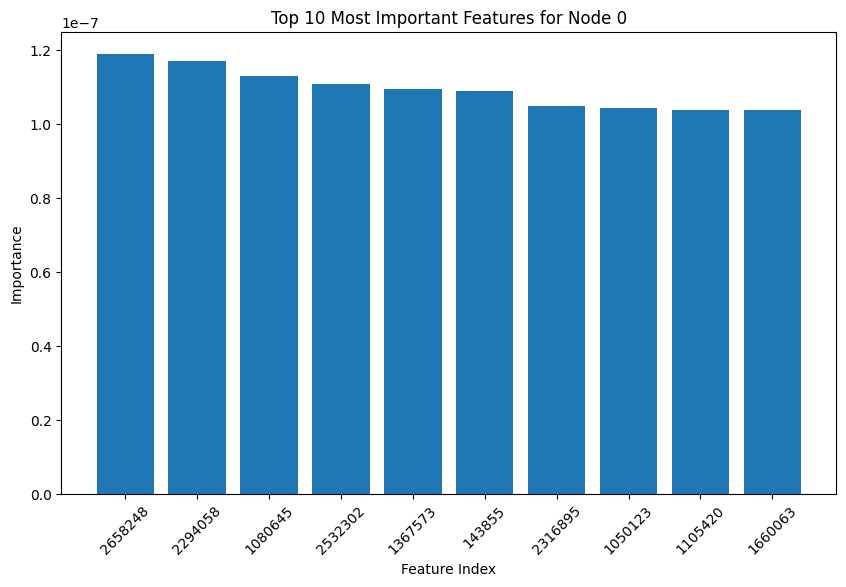

In [ ]:
# Step 1: Average feature importance across all perturbations
average_importance = np.mean(importance_graphlime_v2, axis=0)
print(f"Average feature importance for node {node_idx}:", average_importance)

# Step 2: Get the indices of the top 10 features by importance
top_k = 10
top_features_indices = np.argsort(average_importance)[-top_k:][::-1]
top_features_importance = average_importance[top_features_indices]

# Print top features
print(f"\nTop {top_k} most important features for node {node_idx}:")
for i, feature_idx in enumerate(top_features_indices):
    print(f"Feature {feature_idx}: Importance {top_features_importance[i]}")

# Step 3: Plot the top features' importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(range(top_k), top_features_importance, tick_label=top_features_indices)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title(f"Top {top_k} Most Important Features for Node {node_idx}")
plt.xticks(rotation=45)
plt.show()


In [ ]:
!pip install networkx python-louvain

In [ ]:
import torch
import networkx as nx
from torch_geometric.utils import to_networkx
from networkx.algorithms import community
import matplotlib.pyplot as plt

# Convert PyTorch Geometric Data object to NetworkX graph
G = to_networkx(data, to_undirected=True)  # Convert to undirected graph for simplicity

# Step 1: Centrality Analysis

# Calculate Degree Centrality
degree_centrality = nx.degree_centrality(G)
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Print top 10 nodes by degree centrality
print("\nTop 10 Nodes by Degree Centrality:")
for node, centrality in sorted_degree_centrality[:10]:
    print(f"Node {node}: Degree Centrality {centrality}")

# Calculate Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G)
sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

# Print top 10 nodes by betweenness centrality
print("\nTop 10 Nodes by Betweenness Centrality:")
for node, centrality in sorted_betweenness_centrality[:10]:
    print(f"Node {node}: Betweenness Centrality {centrality}")

# Calculate PageRank
pagerank = nx.pagerank(G)
sorted_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)

# Print top 10 nodes by PageRank
print("\nTop 10 Nodes by PageRank:")
for node, rank in sorted_pagerank[:10]:
    print(f"Node {node}: PageRank {rank}")

# Step 2: Community Detection using Louvain Algorithm

import community as community_louvain

# Apply Louvain Community Detection
partition = community_louvain.best_partition(G)

# Print out the number of communities detected and community assignments
num_communities = len(set(partition.values()))
print(f"\nNumber of Communities Detected: {num_communities}")

# Get nodes in each community
communities = {}
for node, comm in partition.items():
    if comm not in communities:
        communities[comm] = []
    communities[comm].append(node)

# Print the first few communities for inspection
print("\nNodes in each of the first few communities:")
for comm_id, nodes in list(communities.items())[:5]:
    print(f"Community {comm_id}: Nodes {nodes}")

# Step 3: Visualize the Graph and Communities

# Set color map based on community
colors = [partition[node] for node in G.nodes()]

# Draw the network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Set seed for reproducible layout
nx.draw_networkx_nodes(G, pos, node_size=50, cmap=plt.get_cmap('viridis'), node_color=colors)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title("Graph Visualization with Louvain Communities")
plt.show()



Top 10 Nodes by Degree Centrality:
Node 29042: Degree Centrality 0.30993669143958164
Node 29044: Degree Centrality 0.13611340489953208
Node 29043: Degree Centrality 0.12321084503165428
Node 29052: Degree Centrality 0.10332369942196531
Node 29062: Degree Centrality 0.10328929259565098
Node 29039: Degree Centrality 0.09393063583815028
Node 29038: Degree Centrality 0.09207266721717589
Node 29036: Degree Centrality 0.08209468758601707
Node 29035: Degree Centrality 0.06809110927608038
Node 29037: Degree Centrality 0.06712771813927883


In [ ]:
import torch
import networkx as nx
from torch_geometric.utils import to_networkx
from networkx.algorithms import community
import matplotlib.pyplot as plt

# Convert PyTorch Geometric Data object to NetworkX graph
G = to_networkx(data, to_undirected=True)  # Convert to undirected graph for simplicity

# Step 1: Centrality Analysis

# Calculate Degree Centrality
degree_centrality = nx.degree_centrality(G)
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Print top 10 nodes by degree centrality
print("\nTop 10 Nodes by Degree Centrality:")
for node, centrality in sorted_degree_centrality[:10]:
    print(f"Node {node}: Degree Centrality {centrality}")

# Calculate Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G)
sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

# Print top 10 nodes by betweenness centrality
print("\nTop 10 Nodes by Betweenness Centrality:")
for node, centrality in sorted_betweenness_centrality[:10]:
    print(f"Node {node}: Betweenness Centrality {centrality}")

# Calculate PageRank
pagerank = nx.pagerank(G)
sorted_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)

# Print top 10 nodes by PageRank
print("\nTop 10 Nodes by PageRank:")
for node, rank in sorted_pagerank[:10]:
    print(f"Node {node}: PageRank {rank}")

# Step 2: Community Detection using Louvain Algorithm

import community.community_louvain as community_louvain  # Correct import for Louvain

# Apply Louvain Community Detection
partition = community_louvain.best_partition(G)

# Print out the number of communities detected and community assignments
num_communities = len(set(partition.values()))
print(f"\nNumber of Communities Detected: {num_communities}")

# Get nodes in each community
communities = {}
for node, comm in partition.items():
    if comm not in communities:
        communities[comm] = []
    communities[comm].append(node)

# Print the first few communities for inspection
print("\nNodes in each of the first few communities:")
for comm_id, nodes in list(communities.items())[:5]:
    print(f"Community {comm_id}: Nodes {nodes}")

# Step 3: Visualize the Graph and Communities

# Set color map based on community
colors = [partition[node] for node in G.nodes()]

# Draw the network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Set seed for reproducible layout
nx.draw_networkx_nodes(G, pos, node_size=50, cmap=plt.get_cmap('viridis'), node_color=colors)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title("Graph Visualization with Louvain Communities")
plt.show()



Top 10 Nodes by Degree Centrality:
Node 29042: Degree Centrality 0.30993669143958164
Node 29044: Degree Centrality 0.13611340489953208
Node 29043: Degree Centrality 0.12321084503165428
Node 29052: Degree Centrality 0.10332369942196531
Node 29062: Degree Centrality 0.10328929259565098
Node 29039: Degree Centrality 0.09393063583815028
Node 29038: Degree Centrality 0.09207266721717589
Node 29036: Degree Centrality 0.08209468758601707
Node 29035: Degree Centrality 0.06809110927608038
Node 29037: Degree Centrality 0.06712771813927883

Top 10 Nodes by Betweenness Centrality:
Node 29042: Betweenness Centrality 0.21722334931941126
Node 29043: Betweenness Centrality 0.09311778142057925
Node 29039: Betweenness Centrality 0.07350799582882221
Node 29035: Betweenness Centrality 0.058053031536647655
Node 29038: Betweenness Centrality 0.0547466144598665
Node 29041: Betweenness Centrality 0.044202737806750624
Node 29044: Betweenness Centrality 0.0261386176681722
Node 29062: Betweenness Centrality 0.0

AttributeError: module 'community' has no attribute 'best_partition'

In [ ]:

import community.community_louvain as community_louvain  # Correct import for Louvain

# Apply Louvain Community Detection
partition = community_louvain.best_partition(G)

# Print out the number of communities detected and community assignments
num_communities = len(set(partition.values()))
print(f"\nNumber of Communities Detected: {num_communities}")

# Get nodes in each community
communities = {}
for node, comm in partition.items():
    if comm not in communities:
        communities[comm] = []
    communities[comm].append(node)

# Print the first few communities for inspection
print("\nNodes in each of the first few communities:")
for comm_id, nodes in list(communities.items())[:5]:
    print(f"Community {comm_id}: Nodes {nodes}")

# Step 3: Visualize the Graph and Communities

# Set color map based on community
colors = [partition[node] for node in G.nodes()]

# Draw the network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Set seed for reproducible layout
nx.draw_networkx_nodes(G, pos, node_size=50, cmap=plt.get_cmap('viridis'), node_color=colors)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title("Graph Visualization with Louvain Communities")
plt.show()


Number of Communities Detected: 7

Nodes in each of the first few communities:
Community 4: Nodes [0, 7, 10, 14, 15, 16, 26, 31, 32, 42, 50, 51, 53, 57, 61, 69, 73, 78, 79, 80, 82, 85, 86, 98, 101, 102, 112, 122, 123, 128, 130, 141, 142, 143, 152, 159, 171, 172, 174, 177, 182, 189, 190, 191, 193, 197, 202, 203, 211, 213, 214, 223, 224, 236, 248, 264, 268, 277, 284, 287, 292, 294, 296, 300, 301, 303, 313, 317, 320, 325, 328, 343, 353, 354, 358, 359, 362, 363, 365, 366, 377, 379, 398, 402, 412, 414, 417, 418, 425, 427, 435, 446, 454, 458, 460, 463, 467, 468, 473, 479, 486, 492, 494, 497, 502, 509, 510, 511, 514, 515, 519, 521, 522, 533, 540, 543, 551, 564, 565, 567, 574, 575, 578, 585, 586, 589, 599, 600, 604, 608, 610, 612, 614, 619, 620, 621, 622, 627, 631, 637, 645, 651, 652, 653, 654, 672, 676, 679, 682, 687, 689, 693, 694, 695, 716, 726, 730, 731, 739, 740, 753, 754, 755, 764, 765, 768, 786, 787, 791, 792, 798, 803, 808, 809, 812, 817, 818, 824, 826, 829, 838, 846, 849, 851, 853, 8

In [ ]:
import random
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, cohen_kappa_score, f1_score, roc_auc_score
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import optuna

def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

set_seeds(42)

# ========================================
# Data Preprocessing Function
# ========================================
def preprocess_data(data_cleaned):
    # Extract labels
    y = data_cleaned['label_list'].tolist()

    # Initialize MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    one_hot_labels = mlb.fit_transform(y)
    num_classes = one_hot_labels.shape[1]

    print("\nClasses:", mlb.classes_)
    print("One-Hot Encoded Labels Shape:", one_hot_labels.shape)

    # Stratified Splitting (60% Train, 20% Val, 20% Test)
    X = np.arange(len(data_cleaned))
    y_labels = one_hot_labels

    msss_train = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
    train_idx, temp_idx = next(msss_train.split(X, y_labels))

    msss_val_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    val_temp_idx, test_temp_idx = next(msss_val_test.split(X[temp_idx], y_labels[temp_idx]))

    val_idx = temp_idx[val_temp_idx]
    test_idx = temp_idx[test_temp_idx]

    # Feature Extraction with TF-IDF (fit on training data)
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    tfidf_vectorizer.fit(data_cleaned['resume'].iloc[train_idx])
    tfidf_features = tfidf_vectorizer.transform(data_cleaned['resume'])
    print("\nTF-IDF Feature Shape:", tfidf_features.shape)

    # Scaling TF-IDF Features (fit on training data)
    scaler = StandardScaler(with_mean=False)
    scaler.fit(tfidf_features[train_idx])
    scaled_tfidf = scaler.transform(tfidf_features).toarray()
    print("Scaled TF-IDF Feature Shape:", scaled_tfidf.shape)

    # Prepare node features for resumes
    resume_features = scaled_tfidf  # shape (num_resumes, 5000)

    # Prepare job label nodes for each split
    job_labels = mlb.classes_
    num_jobs = len(job_labels)

    # Create job label nodes for each split
    num_splits = 3  # train, val, test
    total_job_nodes = num_jobs * num_splits
    total_resume_nodes = len(data_cleaned)
    total_nodes = total_resume_nodes + total_job_nodes

    # Create features for job label nodes
    # For simplicity, we'll use one-hot encoding for job labels
    job_features = np.eye(num_jobs)  # shape (num_jobs, num_jobs)

    # Repeat job features for each split
    job_features_all = np.vstack([job_features for _ in range(num_splits)])  # shape (total_job_nodes, num_jobs)
    print("\nJob Features Shape:", job_features_all.shape)

    # Pad job_features_all to match the dimension of resume_features
    tfidf_dim = resume_features.shape[1]  # e.g., 5000
    job_features_dim = job_features_all.shape[1]  # e.g., num_jobs
    padding_dim = tfidf_dim - job_features_dim

    if padding_dim < 0:
        raise ValueError("TF-IDF dimension is smaller than the number of job features.")

    # Pad job_features_all with zeros
    job_features_padded = np.hstack([job_features_all, np.zeros((job_features_all.shape[0], padding_dim))])
    print("Padded Job Features Shape:", job_features_padded.shape)  # Should be (total_job_nodes, tfidf_dim)

    # Combine resume features and padded job features
    combined_features = np.vstack([resume_features, job_features_padded])
    print("Combined Features Shape:", combined_features.shape)  # Should be (total_nodes, tfidf_dim)

    # Construct edges
    edges = []

    # Mapping from job label to job node index per split
    job_node_offset = {
        'train': total_resume_nodes,
        'val': total_resume_nodes + num_jobs,
        'test': total_resume_nodes + 2 * num_jobs
    }

    # Helper function to get job node index for a label and split
    def get_job_node_index(label, split):
        job_idx = np.where(job_labels == label)[0][0]
        return job_node_offset[split] + job_idx

    # Construct edges for training data
    for idx in train_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'train')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    # Construct edges for validation data
    for idx in val_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'val')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    # Construct edges for test data
    for idx in test_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'test')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    print("\nEdge Index Shape:", edge_index.shape)
    print("Number of Nodes:", total_nodes)
    print("Number of Edges:", edge_index.size(1))

    # Initialize all masks as False
    train_mask = torch.zeros(total_nodes, dtype=torch.bool)
    val_mask = torch.zeros(total_nodes, dtype=torch.bool)
    test_mask = torch.zeros(total_nodes, dtype=torch.bool)

    # Setting masks for resume nodes only
    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True

    print("\nStratified Train Indices:", train_idx)
    print("Stratified Validation Indices:", val_idx)
    print("Stratified Test Indices:", test_idx)

    # Prepare labels
    # For job label nodes, we can set labels to zeros (or any placeholder)
    # Since we're focusing on predicting labels for resume nodes
    zero_labels = np.zeros((total_job_nodes, num_classes))
    one_hot_labels_padded = np.vstack([one_hot_labels, zero_labels])
    labels = torch.tensor(one_hot_labels_padded, dtype=torch.float)

    x = torch.tensor(combined_features, dtype=torch.float)

    data = Data(
        x=x,
        edge_index=edge_index,
        y=labels,
        train_mask=train_mask,
        val_mask=val_mask,
        test_mask=test_mask
    )

    data.num_classes = num_classes
    data.num_node_features = x.shape[1]

    print("\nPyG Data Object with Masks:")
    print(data)

    return data, mlb

# ========================================
# Implementing filter_edge_index Function
# ========================================
def filter_edge_index(edge_index, node_mask):
    # Get indices of nodes that are in the mask
    node_indices = torch.nonzero(node_mask, as_tuple=False).view(-1)
    node_indices_set = set(node_indices.tolist())

    # Filter edges where both source and target nodes are in node_indices_set
    mask = [(src in node_indices_set and dst in node_indices_set) for src, dst in edge_index.t().tolist()]
    filtered_edge_index = edge_index[:, mask]
    return filtered_edge_index

# ========================================
# Define the GCN Model
# ========================================
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x  # Outputs raw logits

# ========================================
# Training Function
# ========================================
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    # Create subgraph for training
    train_data = Data(
        x=data.x[data.train_mask],
        edge_index=filter_edge_index(data.edge_index, data.train_mask),
        y=data.y[data.train_mask]
    )
    out = model(train_data)
    loss = criterion(out, train_data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# ========================================
# Evaluation Function
# ========================================
def evaluate(model, data, mlb):
    model.eval()
    with torch.no_grad():
        out = model(data)
        y_pred = torch.sigmoid(out).cpu().numpy()

        # Extract predictions and true labels for validation set
        val_pred = (y_pred[data.val_mask] >= 0.5).astype(int)
        val_true = data.y[data.val_mask].cpu().numpy()

        # Classification Report for Validation Set
        print("\nValidation Classification Report:")
        print(classification_report(val_true, val_pred, target_names=mlb.classes_, zero_division=0))

        # Flatten the arrays for multi-label case to use Cohen's kappa score
        val_true_flat = val_true.flatten()
        val_pred_flat = val_pred.flatten()

        # Calculate Cohen's Kappa Score
        kappa_val = cohen_kappa_score(val_true_flat, val_pred_flat)
        print(f"Cohen's Kappa Score (Validation Set): {kappa_val:.4f}")

        # Calculate Weighted F1-score for Validation Set
        weighted_f1 = f1_score(val_true, val_pred, average='weighted')
        print(f"Weighted F1-score (Validation Set): {weighted_f1:.4f}")

        # Compute ROC AUC for Validation Set
        try:
            auc_val = roc_auc_score(val_true, y_pred[data.val_mask], average='macro')
            print(f"ROC AUC Score (Validation Set): {auc_val:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Validation Set) could not be computed: {e}")

# ========================================
# Objective Function for Hyperparameter Optimization
# ========================================
def objective(trial):
    # Hyperparameter suggestions
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    hidden_dim = trial.suggest_int('hidden_dim', 16, 128, step=16)
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.7, step=0.1)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)

    # Initialize the model
    model = GCN(
        input_dim=data.num_node_features,
        hidden_dim=hidden_dim,
        output_dim=data.num_classes,
        dropout_rate=dropout_rate
    )

    # === Compute Class Weights ===
    y_train = data.y[data.train_mask].cpu().numpy()
    num_train_samples, num_classes = y_train.shape

    positive_counts = y_train.sum(axis=0)
    negative_counts = num_train_samples - positive_counts

    # Add epsilon to avoid division by zero
    epsilon = 1e-6
    pos_weight_values = (negative_counts + epsilon) / (positive_counts + epsilon)
    pos_weight = torch.tensor(pos_weight_values, dtype=torch.float)

    # Define optimizer and loss function with class weights
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Implement Early Stopping
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0

    max_epochs = 50  # Reduced epochs for tuning

    for epoch in range(1, max_epochs + 1):
        loss = train(model, data, optimizer, criterion)

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask]).item()

        trial.report(val_loss, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            break  # Early stopping

    return best_val_loss

# ========================================
# Prepare Data and Run Hyperparameter Optimization
# ========================================
# Assuming 'data_cleaned' is your DataFrame containing 'resume' and 'label_list' columns
data, mlb = preprocess_data(data_cleaned)

# Run hyperparameter optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# ========================================
# Train Final Model with Best Hyperparameters
# ========================================
def train_final_model(data, mlb, best_params):
    # Initialize the model with best hyperparameters
    model = GCN(
        input_dim=data.num_node_features,
        hidden_dim=best_params['hidden_dim'],
        output_dim=data.num_classes,
        dropout_rate=best_params['dropout_rate']
    )

    # === Compute Class Weights ===
    y_train = data.y[data.train_mask].cpu().numpy()
    num_train_samples, num_classes = y_train.shape

    positive_counts = y_train.sum(axis=0)
    negative_counts = num_train_samples - positive_counts

    # Add epsilon to avoid division by zero
    epsilon = 1e-6
    pos_weight_values = (negative_counts + epsilon) / (positive_counts + epsilon)
    pos_weight = torch.tensor(pos_weight_values, dtype=torch.float)

    print("\nPositive Counts per Class:", positive_counts)
    print("Negative Counts per Class:", negative_counts)
    print("Pos Weight per Class:", pos_weight)

    # Define optimizer and loss function with class weights
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=best_params['lr'],
        weight_decay=best_params['weight_decay']
    )
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Training parameters
    max_epochs = 200  # Increased epochs for final training
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, max_epochs + 1):
        loss = train(model, data, optimizer, criterion)

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask]).item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_gcn_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        if epoch % 20 == 0 or epoch == 1:
            # Calculate training accuracy
            preds = torch.sigmoid(out[data.train_mask]) >= 0.5
            correct = preds.eq(data.y[data.train_mask] >= 0.5).sum().item()
            acc = correct / data.y[data.train_mask].numel()
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {acc:.4f}')

    # Load the best model
    model.load_state_dict(torch.load('best_gcn_model.pth'))

    return model

# Retrieve the best hyperparameters
best_params = study.best_trial.params
print("\nBest Hyperparameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")

# Train the final model
final_model = train_final_model(data, mlb, best_params)

# ========================================
# Evaluation Function for Final Model
# ========================================
def evaluate_final_model(model, data, mlb):
    model.eval()
    with torch.no_grad():
        out = model(data)
        y_pred = torch.sigmoid(out).cpu().numpy()

        # Validation Set Evaluation
        val_pred = (y_pred[data.val_mask] >= 0.5).astype(int)
        val_true = data.y[data.val_mask].cpu().numpy()

        print("\nValidation Classification Report:")
        print(classification_report(val_true, val_pred, target_names=mlb.classes_, zero_division=0))

        val_true_flat = val_true.flatten()
        val_pred_flat = val_pred.flatten()

        kappa_val = cohen_kappa_score(val_true_flat, val_pred_flat)
        print(f"Cohen's Kappa Score (Validation Set): {kappa_val:.4f}")

        weighted_f1 = f1_score(val_true, val_pred, average='weighted')
        print(f"Weighted F1-score (Validation Set): {weighted_f1:.4f}")

        try:
            auc_val = roc_auc_score(val_true, y_pred[data.val_mask], average='macro')
            print(f"ROC AUC Score (Validation Set): {auc_val:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Validation Set) could not be computed: {e}")

        # Test Set Evaluation
        test_pred = (y_pred[data.test_mask] >= 0.5).astype(int)
        test_true = data.y[data.test_mask].cpu().numpy()

        print("\nTest Classification Report:")
        print(classification_report(test_true, test_pred, target_names=mlb.classes_, zero_division=0))

        test_true_flat = test_true.flatten()
        test_pred_flat = test_pred.flatten()

        kappa_test = cohen_kappa_score(test_true_flat, test_pred_flat)
        print(f"Cohen's Kappa Score (Test Set): {kappa_test:.4f}")

        weighted_f1_test = f1_score(test_true, test_pred, average='weighted')
        print(f"Weighted F1-score (Test Set): {weighted_f1_test:.4f}")

        try:
            auc_test = roc_auc_score(test_true, y_pred[data.test_mask], average='macro')
            print(f"ROC AUC Score (Test Set): {auc_test:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Test Set) could not be computed: {e}")

# Evaluate the final model
evaluate_final_model(final_model, data, mlb)



Classes: ['Database_Administrator' 'Front_End_Developer' 'Java_Developer'
 'Network_Administrator' 'Project_manager' 'Python_Developer'
 'Security_Analyst' 'Software_Developer' 'Systems_Administrator'
 'Web_Developer']
One-Hot Encoded Labels Shape: (29035, 10)

TF-IDF Feature Shape: (29035, 5000)
Scaled TF-IDF Feature Shape: (29035, 5000)

Job Features Shape: (30, 10)
Padded Job Features Shape: (30, 5000)
Combined Features Shape: (29065, 5000)

Edge Index Shape: torch.Size([2, 105944])
Number of Nodes: 29065
Number of Edges: 105944

Stratified Train Indices: [    2     3     5 ... 29030 29031 29034]
Stratified Validation Indices: [    0     7    10 ... 29028 29032 29033]
Stratified Test Indices: [    1     4     9 ... 29014 29025 29027]


[I 2024-11-01 19:35:44,327] A new study created in memory with name: no-name-14627428-c728-4dfa-8825-90f4e1faecab



PyG Data Object with Masks:
Data(x=[29065, 5000], edge_index=[2, 105944], y=[29065, 10], train_mask=[29065], val_mask=[29065], test_mask=[29065], num_classes=10, num_node_features=5000)


<ipython-input-9-5dd7f51af160>:281: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
<ipython-input-9-5dd7f51af160>:284: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)
[I 2024-11-01 19:36:54,773] Trial 0 finished with value: 0.40131717920303345 and parameters: {'lr': 0.0015605234581990482, 'hidden_dim': 128, 'dropout_rate': 0.4, 'weight_decay': 0.0004263098632670801}. Best is trial 0 with value: 0.40131717920303345.
[I 2024-11-01 19:37:45,767] Trial 1 finished with value: 0.8685270547866821 and parameters: {'lr': 0.0002617579925381992, 'hidden_dim': 32, 'dropo


Best Hyperparameters:
lr: 0.0016759828148153369
hidden_dim: 64
dropout_rate: 0.3
weight_decay: 0.0008535074514521495

Positive Counts per Class: [1979. 2386. 1951. 2676. 2730. 1702. 1813. 9008. 3581. 3956.]
Negative Counts per Class: [15410. 15003. 15438. 14713. 14659. 15687. 15576.  8381. 13808. 13433.]
Pos Weight per Class: tensor([7.7868, 6.2879, 7.9129, 5.4981, 5.3696, 9.2168, 8.5913, 0.9304, 3.8559,
        3.3956])
Epoch: 001, Loss: 1.5365, Val Loss: 1.0080, Train Accuracy: 0.4808
Epoch: 020, Loss: 0.4021, Val Loss: 0.4171, Train Accuracy: 0.9368
Epoch: 040, Loss: 0.2287, Val Loss: 0.3826, Train Accuracy: 0.9599
Epoch: 060, Loss: 0.1598, Val Loss: 0.3650, Train Accuracy: 0.9670
Epoch: 080, Loss: 0.1230, Val Loss: 0.3534, Train Accuracy: 0.9717
Epoch: 100, Loss: 0.1013, Val Loss: 0.3487, Train Accuracy: 0.9749
Epoch: 120, Loss: 0.0890, Val Loss: 0.3420, Train Accuracy: 0.9761
Epoch: 140, Loss: 0.0779, Val Loss: 0.3396, Train Accuracy: 0.9774
Epoch: 160, Loss: 0.0708, Val Loss: 0.

<ipython-input-9-5dd7f51af160>:423: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_gcn_model.pth'))



Validation Classification Report:
                        precision    recall  f1-score   support

Database_Administrator       1.00      0.85      0.92       660
   Front_End_Developer       0.87      0.93      0.90       796
        Java_Developer       0.94      0.94      0.94       651
 Network_Administrator       0.80      0.90      0.85       892
       Project_manager       0.99      0.85      0.91       910
      Python_Developer       0.97      0.86      0.92       567
      Security_Analyst       0.99      0.89      0.94       605
    Software_Developer       1.00      0.97      0.98      3003
 Systems_Administrator       0.82      0.85      0.84      1194
         Web_Developer       0.64      0.88      0.74      1319

             micro avg       0.89      0.91      0.90     10597
             macro avg       0.90      0.89      0.89     10597
          weighted avg       0.90      0.91      0.90     10597
           samples avg       0.90      0.94      0.90     10597

Co

### Threshold tuning

In [2]:
!pip install optuna iterative-stratification torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.8 MB/s eta 0:00:00


In [5]:
import random
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, cohen_kappa_score, f1_score, roc_auc_score, precision_recall_curve
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import optuna

def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

set_seeds(42)

# ========================================
# Data Preprocessing Function
# ========================================
def preprocess_data(data_cleaned):
    # Extract labels
    y = data_cleaned['label_list'].tolist()

    # Initialize MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    one_hot_labels = mlb.fit_transform(y)
    num_classes = one_hot_labels.shape[1]

    print("\nClasses:", mlb.classes_)
    print("One-Hot Encoded Labels Shape:", one_hot_labels.shape)

    # Stratified Splitting (60% Train, 20% Val, 20% Test)
    X = np.arange(len(data_cleaned))
    y_labels = one_hot_labels

    msss_train = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
    train_idx, temp_idx = next(msss_train.split(X, y_labels))

    msss_val_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    val_temp_idx, test_temp_idx = next(msss_val_test.split(X[temp_idx], y_labels[temp_idx]))

    val_idx = temp_idx[val_temp_idx]
    test_idx = temp_idx[test_temp_idx]

    # Feature Extraction with TF-IDF (fit on training data)
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    tfidf_vectorizer.fit(data_cleaned['resume'].iloc[train_idx])
    tfidf_features = tfidf_vectorizer.transform(data_cleaned['resume'])
    print("\nTF-IDF Feature Shape:", tfidf_features.shape)

    # Scaling TF-IDF Features (fit on training data)
    scaler = StandardScaler(with_mean=False)
    scaler.fit(tfidf_features[train_idx])
    scaled_tfidf = scaler.transform(tfidf_features).toarray()
    print("Scaled TF-IDF Feature Shape:", scaled_tfidf.shape)

    # Prepare node features for resumes
    resume_features = scaled_tfidf  # shape (num_resumes, 5000)

    # Prepare job label nodes for each split
    job_labels = mlb.classes_
    num_jobs = len(job_labels)

    # Create job label nodes for each split
    num_splits = 3  # train, val, test
    total_job_nodes = num_jobs * num_splits
    total_resume_nodes = len(data_cleaned)
    total_nodes = total_resume_nodes + total_job_nodes

    # Create features for job label nodes
    # For simplicity, we'll use one-hot encoding for job labels
    job_features = np.eye(num_jobs)  # shape (num_jobs, num_jobs)

    # Repeat job features for each split
    job_features_all = np.vstack([job_features for _ in range(num_splits)])  # shape (total_job_nodes, num_jobs)
    print("\nJob Features Shape:", job_features_all.shape)

    # Pad job_features_all to match the dimension of resume_features
    tfidf_dim = resume_features.shape[1]  # e.g., 5000
    job_features_dim = job_features_all.shape[1]  # e.g., num_jobs
    padding_dim = tfidf_dim - job_features_dim

    if padding_dim < 0:
        raise ValueError("TF-IDF dimension is smaller than the number of job features.")

    # Pad job_features_all with zeros
    job_features_padded = np.hstack([job_features_all, np.zeros((job_features_all.shape[0], padding_dim))])
    print("Padded Job Features Shape:", job_features_padded.shape)  # Should be (total_job_nodes, tfidf_dim)

    # Combine resume features and padded job features
    combined_features = np.vstack([resume_features, job_features_padded])
    print("Combined Features Shape:", combined_features.shape)  # Should be (total_nodes, tfidf_dim)

    # Construct edges
    edges = []

    # Mapping from job label to job node index per split
    job_node_offset = {
        'train': total_resume_nodes,
        'val': total_resume_nodes + num_jobs,
        'test': total_resume_nodes + 2 * num_jobs
    }

    # Helper function to get job node index for a label and split
    def get_job_node_index(label, split):
        job_idx = np.where(job_labels == label)[0][0]
        return job_node_offset[split] + job_idx

    # Construct edges for training data
    for idx in train_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'train')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    # Construct edges for validation data
    for idx in val_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'val')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    # Construct edges for test data
    for idx in test_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'test')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    print("\nEdge Index Shape:", edge_index.shape)
    print("Number of Nodes:", total_nodes)
    print("Number of Edges:", edge_index.size(1))

    # Initialize all masks as False
    train_mask = torch.zeros(total_nodes, dtype=torch.bool)
    val_mask = torch.zeros(total_nodes, dtype=torch.bool)
    test_mask = torch.zeros(total_nodes, dtype=torch.bool)

    # Setting masks for resume nodes only
    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True

    print("\nStratified Train Indices:", train_idx)
    print("Stratified Validation Indices:", val_idx)
    print("Stratified Test Indices:", test_idx)

    # Prepare labels
    # For job label nodes, we can set labels to zeros (or any placeholder)
    # Since we're focusing on predicting labels for resume nodes
    zero_labels = np.zeros((total_job_nodes, num_classes))
    one_hot_labels_padded = np.vstack([one_hot_labels, zero_labels])
    labels = torch.tensor(one_hot_labels_padded, dtype=torch.float)

    x = torch.tensor(combined_features, dtype=torch.float)

    data = Data(
        x=x,
        edge_index=edge_index,
        y=labels,
        train_mask=train_mask,
        val_mask=val_mask,
        test_mask=test_mask
    )

    data.num_classes = num_classes
    data.num_node_features = x.shape[1]

    print("\nPyG Data Object with Masks:")
    print(data)

    return data, mlb

# ========================================
# Implementing filter_edge_index Function
# ========================================
def filter_edge_index(edge_index, node_mask):
    # Get indices of nodes that are in the mask
    node_indices = torch.nonzero(node_mask, as_tuple=False).view(-1)
    node_indices_set = set(node_indices.tolist())

    # Filter edges where both source and target nodes are in node_indices_set
    mask = [(src in node_indices_set and dst in node_indices_set) for src, dst in edge_index.t().tolist()]
    filtered_edge_index = edge_index[:, mask]
    return filtered_edge_index

# ========================================
# Define the GCN Model
# ========================================
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x  # Outputs raw logits

# ========================================
# Training Function
# ========================================
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    # Create subgraph for training
    train_data = Data(
        x=data.x[data.train_mask],
        edge_index=filter_edge_index(data.edge_index, data.train_mask),
        y=data.y[data.train_mask]
    )
    out = model(train_data)
    loss = criterion(out, train_data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# ========================================
# Evaluation Function (Not used, can be removed or updated)
# ========================================
def evaluate(model, data, mlb):
    pass  # This function is not updated since we are using evaluate_final_model

# ========================================
# Objective Function for Hyperparameter Optimization
# ========================================
def objective(trial):
    # Hyperparameter suggestions
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    hidden_dim = trial.suggest_int('hidden_dim', 16, 128, step=16)
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.7, step=0.1)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)

    # Initialize the model
    model = GCN(
        input_dim=data.num_node_features,
        hidden_dim=hidden_dim,
        output_dim=data.num_classes,
        dropout_rate=dropout_rate
    )

    # === Compute Class Weights ===
    y_train = data.y[data.train_mask].cpu().numpy()
    num_train_samples, num_classes = y_train.shape

    positive_counts = y_train.sum(axis=0)
    negative_counts = num_train_samples - positive_counts

    # Add epsilon to avoid division by zero
    epsilon = 1e-6
    pos_weight_values = (negative_counts + epsilon) / (positive_counts + epsilon)
    pos_weight = torch.tensor(pos_weight_values, dtype=torch.float)

    # Define optimizer and loss function with class weights
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Implement Early Stopping
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0

    max_epochs = 50  # Reduced epochs for tuning

    for epoch in range(1, max_epochs + 1):
        loss = train(model, data, optimizer, criterion)

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask]).item()

        trial.report(val_loss, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            break  # Early stopping

    return best_val_loss

# ========================================
# Prepare Data and Run Hyperparameter Optimization
# ========================================
# Assuming 'data_cleaned' is your DataFrame containing 'resume' and 'label_list' columns
# Replace the following line with your actual data loading code
# data_cleaned = pd.read_csv('your_data.csv')  # Uncomment and modify accordingly

data, mlb = preprocess_data(data_cleaned)

# Run hyperparameter optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# ========================================
# Train Final Model with Best Hyperparameters
# ========================================
def train_final_model(data, mlb, best_params):
    # Initialize the model with best hyperparameters
    model = GCN(
        input_dim=data.num_node_features,
        hidden_dim=best_params['hidden_dim'],
        output_dim=data.num_classes,
        dropout_rate=best_params['dropout_rate']
    )

    # === Compute Class Weights ===
    y_train = data.y[data.train_mask].cpu().numpy()
    num_train_samples, num_classes = y_train.shape

    positive_counts = y_train.sum(axis=0)
    negative_counts = num_train_samples - positive_counts

    # Add epsilon to avoid division by zero
    epsilon = 1e-6
    pos_weight_values = (negative_counts + epsilon) / (positive_counts + epsilon)
    pos_weight = torch.tensor(pos_weight_values, dtype=torch.float)

    print("\nPositive Counts per Class:", positive_counts)
    print("Negative Counts per Class:", negative_counts)
    print("Pos Weight per Class:", pos_weight)

    # Define optimizer and loss function with class weights
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=best_params['lr'],
        weight_decay=best_params['weight_decay']
    )
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Training parameters
    max_epochs = 200  # Increased epochs for final training
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, max_epochs + 1):
        loss = train(model, data, optimizer, criterion)

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask]).item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_gcn_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        if epoch % 20 == 0 or epoch == 1:
            # Calculate training accuracy
            preds = torch.sigmoid(out[data.train_mask]) >= 0.5
            correct = preds.eq(data.y[data.train_mask] >= 0.5).sum().item()
            acc = correct / data.y[data.train_mask].numel()
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {acc:.4f}')

    # Load the best model
    model.load_state_dict(torch.load('best_gcn_model.pth'))

    return model


'''
Best Hyperparameters with Class Weights:
hidden_dim: 192
dropout_rate: 0.30000000000000004
lr: 0.0019890464522561964
weight_decay: 2.2578844005086472e-05
'''
# Best Hyperparameters:
best_params = {
    'lr': 0.0019890464522561964,
    'hidden_dim': 192,
    'dropout_rate': 0.30000000000000004,
    'weight_decay': 2.2578844005086472e-05
}

print("\nBest Hyperparameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")

# Train the final model
final_model = train_final_model(data, mlb, best_params)

# # Retrieve the best hyperparameters
# best_params = study.best_trial.params
# print("\nBest Hyperparameters:")
# for key, value in best_params.items():
#     print(f"{key}: {value}")

# Train the final model
final_model = train_final_model(data, mlb, best_params)

# ========================================
# Functions to Compute Optimal Thresholds and Apply Them
# ========================================
def compute_optimal_thresholds(y_true, y_scores):
    num_classes = y_true.shape[1]
    optimal_thresholds = np.zeros(num_classes)
    for i in range(num_classes):
        y_true_class = y_true[:, i]
        y_scores_class = y_scores[:, i]

        # Only compute thresholds if there are positive samples in y_true_class
        if np.sum(y_true_class) == 0:
            # No positive samples, set threshold to 1 to predict all zeros
            optimal_thresholds[i] = 1.0
            continue

        precision, recall, thresholds = precision_recall_curve(y_true_class, y_scores_class)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        # Replace NaN with zero
        f1_scores = np.nan_to_num(f1_scores)
        # Find the threshold that gives the maximum F1 score
        index = np.argmax(f1_scores)
        if index < len(thresholds):
            optimal_threshold = thresholds[index]
        else:
            optimal_threshold = thresholds[-1]
        optimal_thresholds[i] = optimal_threshold
    return optimal_thresholds

def apply_thresholds(y_scores, thresholds):
    return (y_scores >= thresholds[None, :]).astype(int)

# ========================================
# Evaluation Function for Final Model
# ========================================
def evaluate_final_model(model, data, mlb):
    model.eval()
    with torch.no_grad():
        out = model(data)
        y_pred = torch.sigmoid(out).cpu().numpy()

        # Validation Set Evaluation
        val_scores = y_pred[data.val_mask]
        val_true = data.y[data.val_mask].cpu().numpy()

        # Compute optimal thresholds on validation set
        optimal_thresholds = compute_optimal_thresholds(val_true, val_scores)

        # Apply thresholds to validation predictions
        val_pred = apply_thresholds(val_scores, optimal_thresholds)

        print("\nValidation Classification Report:")
        print(classification_report(val_true, val_pred, target_names=mlb.classes_, zero_division=0))

        # Compute Cohen's Kappa per label and average
        num_labels = val_true.shape[1]
        kappa_scores = []

        for i in range(num_labels):
            kappa = cohen_kappa_score(val_true[:, i], val_pred[:, i])
            kappa_scores.append(kappa)

        # Calculate average kappa
        average_kappa = np.mean(kappa_scores)
        print(f"Average Cohen's Kappa Score (Validation Set): {average_kappa:.4f}")


        weighted_f1 = f1_score(val_true, val_pred, average='weighted')
        print(f"Weighted F1-score (Validation Set): {weighted_f1:.4f}")

        try:
            auc_val = roc_auc_score(val_true, val_scores, average='macro')
            print(f"ROC AUC Score (Validation Set): {auc_val:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Validation Set) could not be computed: {e}")

        # Test Set Evaluation
        test_scores = y_pred[data.test_mask]
        test_true = data.y[data.test_mask].cpu().numpy()

        # Apply optimal thresholds to test predictions
        test_pred = apply_thresholds(test_scores, optimal_thresholds)

        print("\nTest Classification Report:")
        print(classification_report(test_true, test_pred, target_names=mlb.classes_, zero_division=0))

        # Compute Cohen's Kappa per label and average for Test Set
        kappa_scores_test = []

        for i in range(num_labels):
            kappa = cohen_kappa_score(test_true[:, i], test_pred[:, i])
            kappa_scores_test.append(kappa)

        # Calculate average kappa for Test Set
        average_kappa_test = np.mean(kappa_scores_test)
        print(f"Average Cohen's Kappa Score (Test Set): {average_kappa_test:.4f}")

        weighted_f1_test = f1_score(test_true, test_pred, average='weighted')
        print(f"Weighted F1-score (Test Set): {weighted_f1_test:.4f}")

        try:
            auc_test = roc_auc_score(test_true, test_scores, average='macro')
            print(f"ROC AUC Score (Test Set): {auc_test:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Test Set) could not be computed: {e}")

# Evaluate the final model
evaluate_final_model(final_model, data, mlb)



Classes: ['Database_Administrator' 'Front_End_Developer' 'Java_Developer'
 'Network_Administrator' 'Project_manager' 'Python_Developer'
 'Security_Analyst' 'Software_Developer' 'Systems_Administrator'
 'Web_Developer']
One-Hot Encoded Labels Shape: (29035, 10)

TF-IDF Feature Shape: (29035, 5000)
Scaled TF-IDF Feature Shape: (29035, 5000)

Job Features Shape: (30, 10)
Padded Job Features Shape: (30, 5000)
Combined Features Shape: (29065, 5000)

Edge Index Shape: torch.Size([2, 105944])
Number of Nodes: 29065
Number of Edges: 105944

Stratified Train Indices: [    2     3     5 ... 29030 29031 29034]
Stratified Validation Indices: [    0     7    10 ... 29028 29032 29033]
Stratified Test Indices: [    1     4     9 ... 29014 29025 29027]


[I 2024-11-26 18:51:36,192] A new study created in memory with name: no-name-cb288a36-bf43-45ab-a325-5f9b443e3866



PyG Data Object with Masks:
Data(x=[29065, 5000], edge_index=[2, 105944], y=[29065, 10], train_mask=[29065], val_mask=[29065], test_mask=[29065], num_classes=10, num_node_features=5000)


<ipython-input-5-b0fdfe120250>:252: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
<ipython-input-5-b0fdfe120250>:255: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)
[I 2024-11-26 18:53:32,175] Trial 0 finished with value: 0.43608829379081726 and parameters: {'lr': 0.0012423822650163975, 'hidden_dim': 112, 'dropout_rate': 0.5, 'weight_decay': 3.134277832053832e-05}. Best is trial 0 with value: 0.43608829379081726.
[I 2024-11-26 18:54:59,141] Trial 1 finished with value: 0.5491471886634827 and parameters: {'lr': 0.006446755570843078, 'hidden_dim': 64, 'dropou


Best Hyperparameters:
lr: 0.0019890464522561964
hidden_dim: 192
dropout_rate: 0.30000000000000004
weight_decay: 2.2578844005086472e-05

Positive Counts per Class: [1979. 2386. 1951. 2676. 2730. 1702. 1813. 9008. 3581. 3956.]
Negative Counts per Class: [15410. 15003. 15438. 14713. 14659. 15687. 15576.  8381. 13808. 13433.]
Pos Weight per Class: tensor([7.7868, 6.2879, 7.9129, 5.4981, 5.3696, 9.2168, 8.5913, 0.9304, 3.8559,
        3.3956])
Epoch: 001, Loss: 1.5059, Val Loss: 0.9269, Train Accuracy: 0.6730
Epoch: 020, Loss: 0.2242, Val Loss: 0.3770, Train Accuracy: 0.9612
Early stopping at epoch 37

Positive Counts per Class: [1979. 2386. 1951. 2676. 2730. 1702. 1813. 9008. 3581. 3956.]
Negative Counts per Class: [15410. 15003. 15438. 14713. 14659. 15687. 15576.  8381. 13808. 13433.]
Pos Weight per Class: tensor([7.7868, 6.2879, 7.9129, 5.4981, 5.3696, 9.2168, 8.5913, 0.9304, 3.8559,
        3.3956])


<ipython-input-5-b0fdfe120250>:397: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_gcn_model.pth'))


Epoch: 001, Loss: 1.5724, Val Loss: 0.9063, Train Accuracy: 0.6535
Epoch: 020, Loss: 0.2259, Val Loss: 0.3824, Train Accuracy: 0.9557
Epoch: 040, Loss: 0.1004, Val Loss: 0.3707, Train Accuracy: 0.9710
Epoch: 060, Loss: 0.0562, Val Loss: 0.3679, Train Accuracy: 0.9767
Epoch: 080, Loss: 0.0351, Val Loss: 0.3610, Train Accuracy: 0.9791
Early stopping at epoch 96

Validation Classification Report:
                        precision    recall  f1-score   support

Database_Administrator       0.99      0.95      0.97       660
   Front_End_Developer       0.96      0.88      0.92       796
        Java_Developer       0.92      0.93      0.93       651
 Network_Administrator       0.86      0.86      0.86       892
       Project_manager       0.93      0.88      0.91       910
      Python_Developer       0.92      0.94      0.93       567
      Security_Analyst       0.96      0.96      0.96       605
    Software_Developer       0.99      0.99      0.99      3003
 Systems_Administrator    

In [4]:
import numpy as np
from sklearn.metrics import precision_recall_curve

# Function to compute optimal thresholds for each class
def compute_optimal_thresholds(y_true, y_scores):
    num_classes = y_true.shape[1]
    optimal_thresholds = np.zeros(num_classes)

    for i in range(num_classes):
        y_true_class = y_true[:, i]
        y_scores_class = y_scores[:, i]

        # Compute precision-recall curve
        precision, recall, thresholds = precision_recall_curve(y_true_class, y_scores_class)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        f1_scores = np.nan_to_num(f1_scores)  # Handle potential NaN values
        index = np.argmax(f1_scores)

        if index < len(thresholds):
            optimal_threshold = thresholds[index]
        else:
            optimal_threshold = 0.5  # Default threshold if no valid threshold found

        optimal_thresholds[i] = optimal_threshold

    return optimal_thresholds

# Function to apply thresholds for predictions
def apply_thresholds(y_scores, thresholds):
    return (y_scores >= thresholds).astype(int)

# Evaluate model with optimal thresholds
def evaluate_model_with_thresholds(model, data, mlb):
    model.eval()
    with torch.no_grad():
        out = model(data)
        y_pred = torch.sigmoid(out).cpu().numpy()

        # Find optimal thresholds using validation set
        val_labels = data.y[data.val_mask].cpu().numpy()
        val_probs = y_pred[data.val_mask]

        optimal_thresholds = compute_optimal_thresholds(val_labels, val_probs)
        print("\nOptimal Thresholds per Class:")
        for idx, threshold in enumerate(optimal_thresholds):
            print(f"Class '{mlb.classes_[idx]}': {threshold:.4f}")

        # Apply optimal thresholds
        val_preds_thresholded = apply_thresholds(val_probs, optimal_thresholds)

        # Print classification report for validation set
        print("\nClassification Report (Validation Set) with Optimal Thresholds:")
        print(classification_report(val_labels, val_preds_thresholded, target_names=mlb.classes_, zero_division=0))

        val_labels_flat = val_labels.flatten()
        val_preds_flat = val_preds_thresholded.flatten()

        kappa_val = cohen_kappa_score(val_labels_flat, val_preds_flat)
        print(f"Cohen's Kappa Score (Validation Set): {kappa_val:.4f}")

        weighted_f1_val = f1_score(val_labels, val_preds_thresholded, average='weighted')
        print(f"Weighted F1-score (Validation Set): {weighted_f1_val:.4f}")

        try:
            auc_val = roc_auc_score(val_labels, val_probs, average='macro')
            print(f"ROC AUC Score (Validation Set): {auc_val:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Validation Set) could not be computed: {e}")

        # Evaluate on the test set using the same thresholds
        test_labels = data.y[data.test_mask].cpu().numpy()
        test_probs = y_pred[data.test_mask]
        test_preds_thresholded = apply_thresholds(test_probs, optimal_thresholds)

        print("\nClassification Report (Test Set) with Optimal Thresholds:")
        print(classification_report(test_labels, test_preds_thresholded, target_names=mlb.classes_, zero_division=0))

        test_labels_flat = test_labels.flatten()
        test_preds_flat = test_preds_thresholded.flatten()

        kappa_test = cohen_kappa_score(test_labels_flat, test_preds_flat)
        print(f"Cohen's Kappa Score (Test Set): {kappa_test:.4f}")

        weighted_f1_test = f1_score(test_labels, test_preds_thresholded, average='weighted')
        print(f"Weighted F1-score (Test Set): {weighted_f1_test:.4f}")

        try:
            auc_test = roc_auc_score(test_labels, test_probs, average='macro')
            print(f"ROC AUC Score (Test Set): {auc_test:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Test Set) could not be computed: {e}")

# Evaluate the final model with threshold tuning
evaluate_model_with_thresholds(final_model, data, mlb)



Optimal Thresholds per Class:
Class 'Database_Administrator': 0.3393
Class 'Front_End_Developer': 0.6471
Class 'Java_Developer': 0.5036
Class 'Network_Administrator': 0.6246
Class 'Project_manager': 0.3302
Class 'Python_Developer': 0.2399
Class 'Security_Analyst': 0.3959
Class 'Software_Developer': 0.3094
Class 'Systems_Administrator': 0.5654
Class 'Web_Developer': 0.6734

Classification Report (Validation Set) with Optimal Thresholds:
                        precision    recall  f1-score   support

Database_Administrator       0.99      0.95      0.97       660
   Front_End_Developer       0.96      0.90      0.93       796
        Java_Developer       0.94      0.94      0.94       651
 Network_Administrator       0.87      0.84      0.85       892
       Project_manager       0.94      0.88      0.91       910
      Python_Developer       0.93      0.93      0.93       567
      Security_Analyst       0.97      0.95      0.96       605
    Software_Developer       1.00      0.99   

In [5]:
# ========================================
# Define Optimal Thresholds
# ========================================

optimal_thresholds = np.array([
    0.3393,  # Database_Administrator
    0.6471,  # Front_End_Developer
    0.5036,  # Java_Developer
    0.6246,  # Network_Administrator
    0.3302,  # Project_manager
    0.2399,  # Python_Developer
    0.3959,  # Security_Analyst
    0.3094,  # Software_Developer
    0.5654,  # Systems_Administrator
    0.6734   # Web_Developer
])

# ========================================
# Apply Optimal Thresholds
# ========================================
def apply_optimal_thresholds(y_pred, thresholds):
    """
    Applies optimal thresholds to the predicted probabilities.

    Args:
        y_pred (numpy.ndarray): Predicted probabilities (logits converted to probabilities).
        thresholds (numpy.ndarray): Optimal thresholds for each class.

    Returns:
        numpy.ndarray: Binary predictions after applying thresholds.
    """
    return (y_pred >= thresholds).astype(int)

# ========================================
# Final Evaluation Function with Thresholds
# ========================================
def evaluate_final_model_with_thresholds(model, data, mlb, thresholds):
    """
    Evaluates the final GCN model on train, validation, and test sets with optimal thresholds.

    Args:
        model: Trained GCN model.
        data: PyG data object.
        mlb: MultiLabelBinarizer instance.
        thresholds: Optimal thresholds for each class.

    Returns:
        None
    """
    model.eval()
    with torch.no_grad():
        # Forward pass to get predictions
        out = model(data)
        y_pred = torch.sigmoid(out).cpu().numpy()

        # Initialize results dictionary
        results = {}

        for split, mask in [("Train", data.train_mask), ("Validation", data.val_mask), ("Test", data.test_mask)]:
            # Apply thresholds
            y_pred_binary = apply_optimal_thresholds(y_pred[mask], thresholds)
            y_true = data.y[mask].cpu().numpy()

            # Classification Report
            print(f"\n{split} Classification Report:")
            print(classification_report(y_true, y_pred_binary, target_names=mlb.classes_, zero_division=0))

            # Weighted F1-score
            weighted_f1 = f1_score(y_true, y_pred_binary, average='weighted')
            print(f"Weighted F1-score ({split} Set): {weighted_f1:.4f}")

            # ROC AUC Score
            try:
                auc_weighted = roc_auc_score(y_true, y_pred[mask], average='weighted')
                print(f"ROC AUC Score ({split} Set - Weighted Average): {auc_weighted:.4f}")
            except ValueError as e:
                print(f"ROC AUC Score ({split} Set) could not be computed: {e}")
                auc_weighted = np.nan

            # Cohen's Kappa
            kappa_scores = []
            for i in range(len(mlb.classes_)):
                kappa = cohen_kappa_score(y_true[:, i], y_pred_binary[:, i])
                kappa_scores.append(kappa)
            average_kappa = np.mean(kappa_scores)
            print(f"Average Cohen's Kappa Score ({split} Set): {average_kappa:.4f}")

            # Store results for summary
            results[split] = {
                "Weighted F1": weighted_f1,
                "Weighted ROC AUC": auc_weighted,
                "Average Kappa": average_kappa
            }

        # Summary of Results
        print("\n===== Summary of Metrics =====")
        for split in ["Train", "Validation", "Test"]:
            print(f"{split} Set - Weighted F1: {results[split]['Weighted F1']:.4f}, "
                  f"Weighted ROC AUC: {results[split]['Weighted ROC AUC']:.4f}, "
                  f"Average Kappa: {results[split]['Average Kappa']:.4f}")

# ========================================
# Evaluate Final Model
# ========================================
evaluate_final_model_with_thresholds(final_model, data, mlb, optimal_thresholds)



Train Classification Report:
                        precision    recall  f1-score   support

Database_Administrator       1.00      0.97      0.98      1979
   Front_End_Developer       1.00      0.93      0.97      2386
        Java_Developer       1.00      0.96      0.98      1951
 Network_Administrator       1.00      0.89      0.94      2676
       Project_manager       1.00      0.94      0.97      2730
      Python_Developer       1.00      0.94      0.97      1702
      Security_Analyst       1.00      0.97      0.98      1813
    Software_Developer       1.00      0.98      0.99      9008
 Systems_Administrator       0.97      0.91      0.94      3581
         Web_Developer       1.00      0.85      0.92      3956

             micro avg       1.00      0.94      0.97     31782
             macro avg       1.00      0.93      0.96     31782
          weighted avg       1.00      0.94      0.97     31782
           samples avg       1.00      0.97      0.97     31782

Weighte


Optimal Thresholds per Class:
Class 'Database_Administrator': 0.3327
Class 'Front_End_Developer': 0.5629
Class 'Java_Developer': 0.3265
Class 'Network_Administrator': 0.6520
Class 'Project_manager': 0.2757
Class 'Python_Developer': 0.3092
Class 'Security_Analyst': 0.3096
Class 'Software_Developer': 0.2288
Class 'Systems_Administrator': 0.3660
Class 'Web_Developer': 0.5582

Classification Report (Validation Set) with Optimal Thresholds:
                        precision    recall  f1-score   support

Database_Administrator       0.99      0.95      0.97       660
   Front_End_Developer       0.96      0.88      0.92       796
        Java_Developer       0.92      0.93      0.93       651
 Network_Administrator       0.86      0.86      0.86       892
       Project_manager       0.93      0.88      0.91       910
      Python_Developer       0.92      0.94      0.93       567
      Security_Analyst       0.96      0.96      0.96       605
    Software_Developer       0.99      0.99   

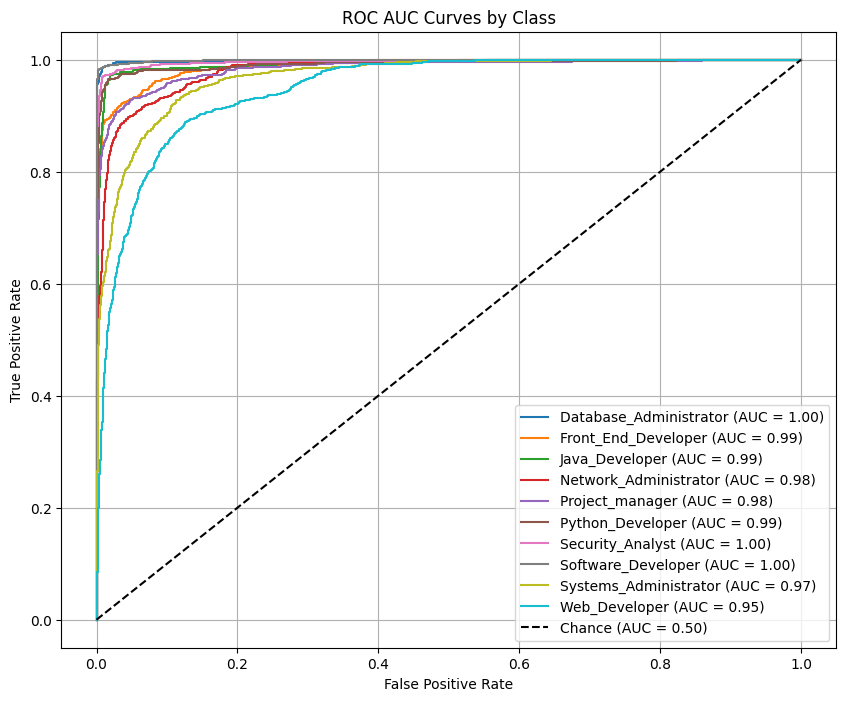

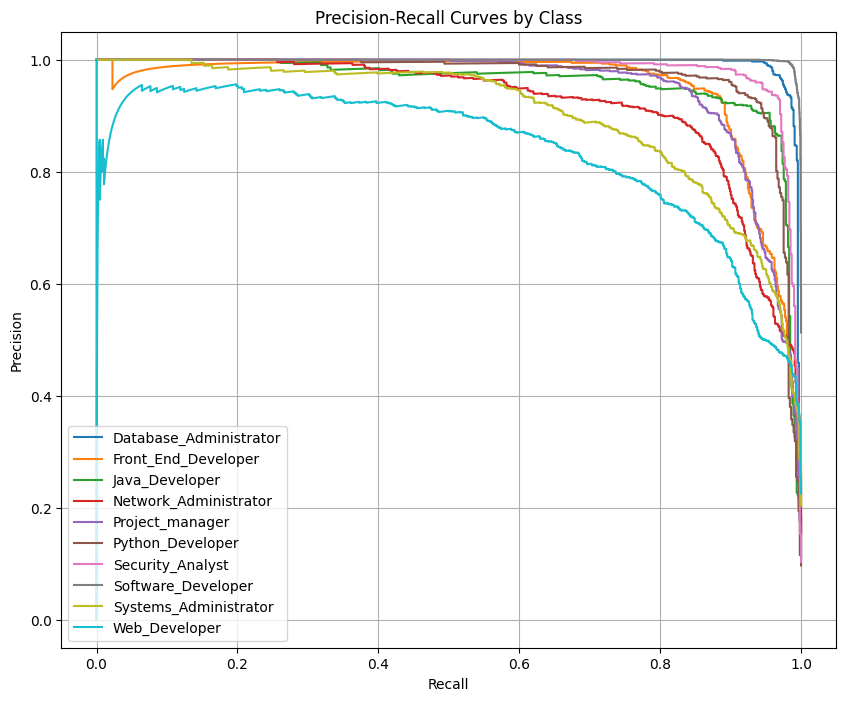

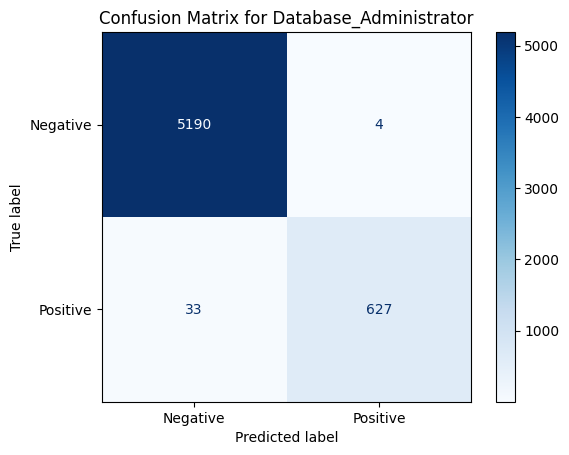

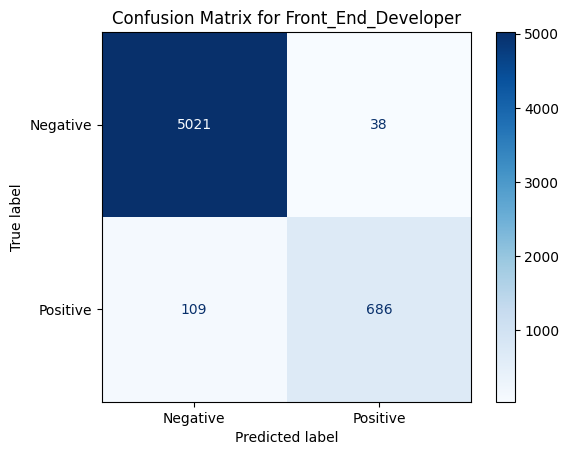

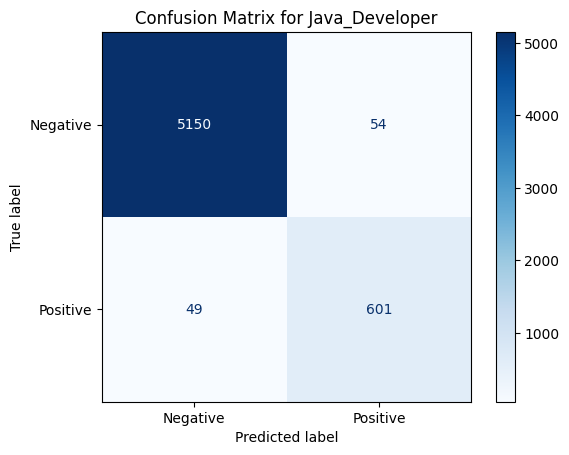

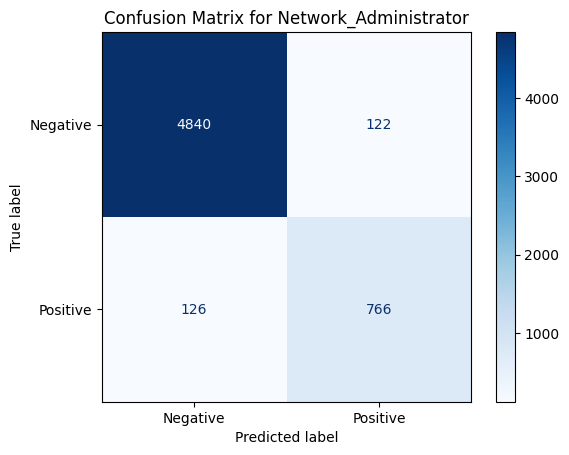

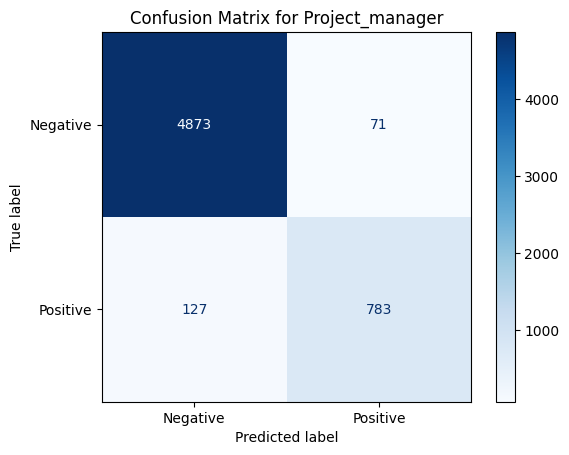

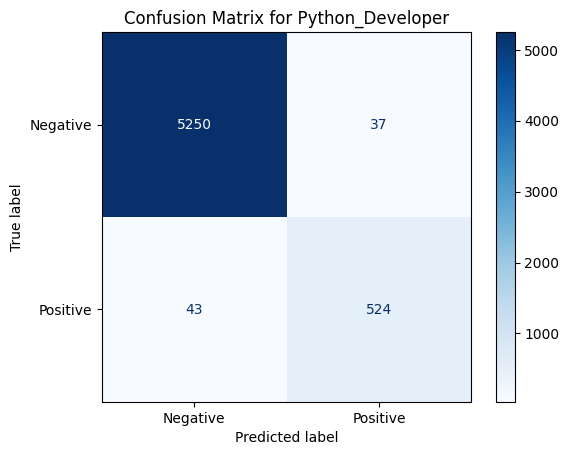

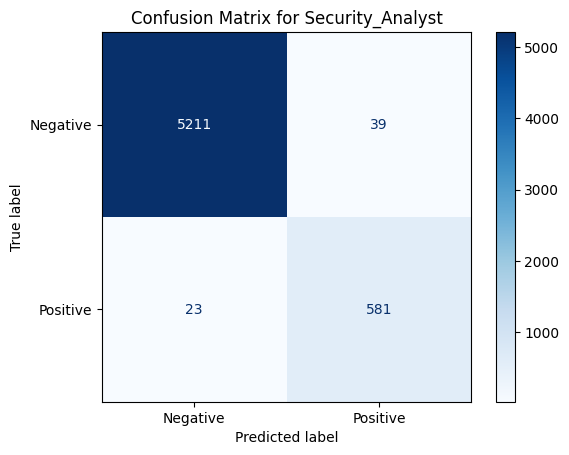

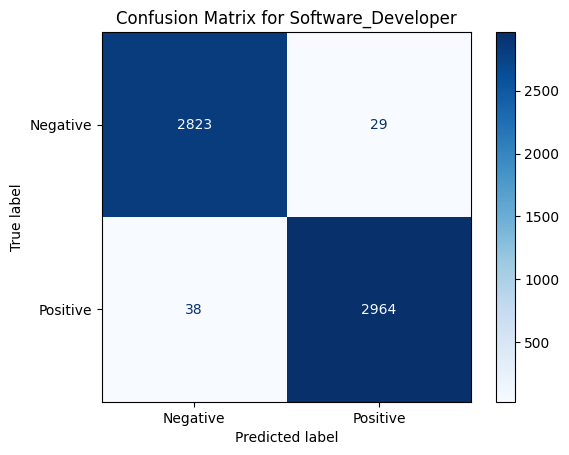

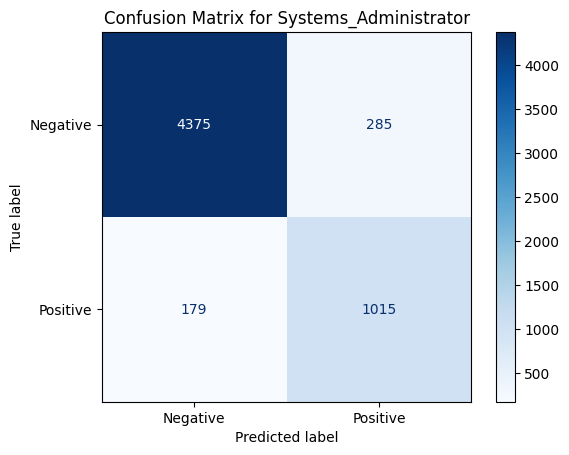

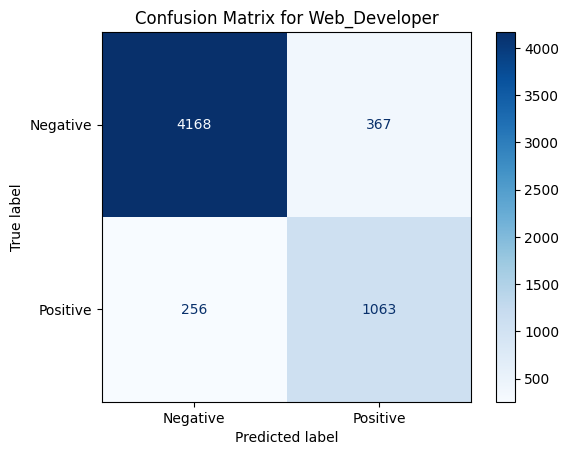

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

# Function to compute optimal thresholds for each class
def compute_optimal_thresholds(y_true, y_scores):
    num_classes = y_true.shape[1]
    optimal_thresholds = np.zeros(num_classes)

    for i in range(num_classes):
        y_true_class = y_true[:, i]
        y_scores_class = y_scores[:, i]

        # Compute precision-recall curve
        precision, recall, thresholds = precision_recall_curve(y_true_class, y_scores_class)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        f1_scores = np.nan_to_num(f1_scores)  # Handle potential NaN values
        index = np.argmax(f1_scores)

        if index < len(thresholds):
            optimal_threshold = thresholds[index]
        else:
            optimal_threshold = 0.5  # Default threshold if no valid threshold found

        optimal_thresholds[i] = optimal_threshold

    return optimal_thresholds

# Function to apply thresholds for predictions
def apply_thresholds(y_scores, thresholds):
    return (y_scores >= thresholds).astype(int)

# Visualization helper functions
def plot_roc_auc_curve(y_true, y_scores, class_names):
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Chance (AUC = 0.50)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC AUC Curves by Class")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

def plot_precision_recall_curve(y_true, y_scores, class_names):
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_names):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_scores[:, i])
        plt.plot(recall, precision, label=f"{class_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves by Class")
    plt.legend(loc="lower left")
    plt.grid()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    for i, class_name in enumerate(class_names):
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix for {class_name}")
        plt.show()

def plot_training_convergence(history, metric="loss", model_name="Model"):
    plt.figure(figsize=(8, 6))
    epochs = range(1, len(history[f"train_{metric}"]) + 1)
    plt.plot(epochs, history[f"train_{metric}"], label="Train")
    plt.plot(epochs, history[f"val_{metric}"], label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel(metric.capitalize())
    plt.title(f"{model_name} Training {metric.capitalize()} Convergence")
    plt.legend()
    plt.grid()
    plt.show()

# Evaluate model with optimal thresholds
def evaluate_model_with_thresholds(model, data, mlb, history=None):
    model.eval()
    with torch.no_grad():
        out = model(data)
        y_pred = torch.sigmoid(out).cpu().numpy()

        # Find optimal thresholds using validation set
        val_labels = data.y[data.val_mask].cpu().numpy()
        val_probs = y_pred[data.val_mask]

        optimal_thresholds = compute_optimal_thresholds(val_labels, val_probs)
        print("\nOptimal Thresholds per Class:")
        for idx, threshold in enumerate(optimal_thresholds):
            print(f"Class '{mlb.classes_[idx]}': {threshold:.4f}")

        # Apply optimal thresholds
        val_preds_thresholded = apply_thresholds(val_probs, optimal_thresholds)

        # Print classification report for validation set
        print("\nClassification Report (Validation Set) with Optimal Thresholds:")
        print(classification_report(val_labels, val_preds_thresholded, target_names=mlb.classes_, zero_division=0))

        # Evaluate on the test set using the same thresholds
        test_labels = data.y[data.test_mask].cpu().numpy()
        test_probs = y_pred[data.test_mask]
        test_preds_thresholded = apply_thresholds(test_probs, optimal_thresholds)

        print("\nClassification Report (Test Set) with Optimal Thresholds:")
        print(classification_report(test_labels, test_preds_thresholded, target_names=mlb.classes_, zero_division=0))

        # Visualization
        print("\n--- Visualizations ---")
        plot_roc_auc_curve(test_labels, test_probs, mlb.classes_)
        plot_precision_recall_curve(test_labels, test_probs, mlb.classes_)
        plot_confusion_matrix(test_labels, test_preds_thresholded, mlb.classes_)

        # Training Convergence (if applicable)
        if history:
            plot_training_convergence(history, metric="loss", model_name="GCN")
            plot_training_convergence(history, metric="accuracy", model_name="GCN")
        else:
          pass

# Example usage:
# Assuming `history` is a dictionary containing training/validation loss and accuracy
# history = {
#     "train_loss": [...], "val_loss": [...],
#     "train_accuracy": [...], "val_accuracy": [...]
# }

evaluate_model_with_thresholds(final_model, data, mlb)



Optimal Thresholds per Class:
Class 'Database_Administrator': 0.3327
Class 'Front_End_Developer': 0.5629
Class 'Java_Developer': 0.3265
Class 'Network_Administrator': 0.6520
Class 'Project_manager': 0.2757
Class 'Python_Developer': 0.3092
Class 'Security_Analyst': 0.3096
Class 'Software_Developer': 0.2288
Class 'Systems_Administrator': 0.3660
Class 'Web_Developer': 0.5582

--- General Confusion Matrix ---


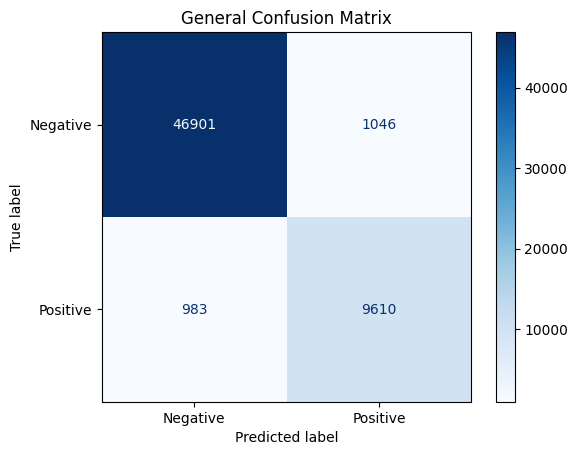


--- Additional Visualizations ---


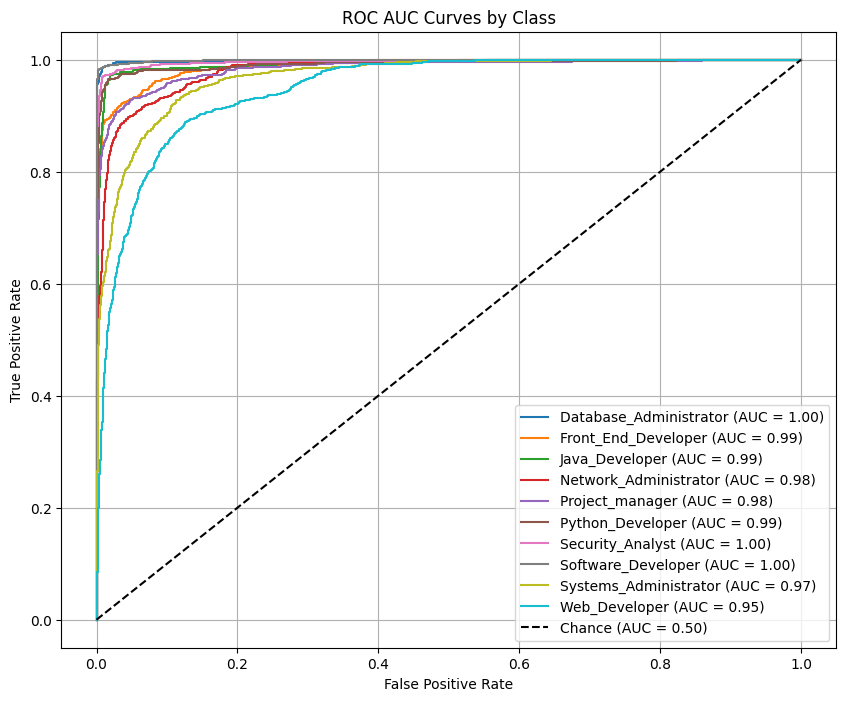

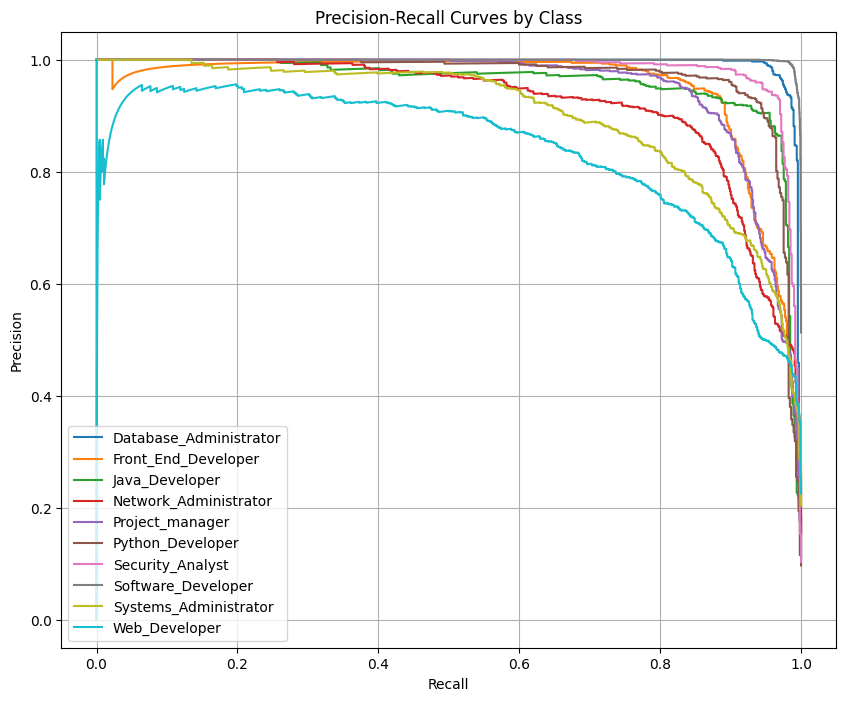

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to compute and plot a general confusion matrix
def plot_general_confusion_matrix(y_true, y_pred):
    """
    Plots a general confusion matrix for multi-label classification.

    Args:
        y_true (numpy.ndarray): Ground truth binary labels (flattened).
        y_pred (numpy.ndarray): Predicted binary labels (flattened).
    """
    # Flatten the arrays
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Compute confusion matrix
    cm = confusion_matrix(y_true_flat, y_pred_flat)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("General Confusion Matrix")
    plt.show()

# Evaluate model with the general confusion matrix included
def evaluate_model_with_thresholds(model, data, mlb, history=None):
    model.eval()
    with torch.no_grad():
        out = model(data)
        y_pred = torch.sigmoid(out).cpu().numpy()

        # Find optimal thresholds using validation set
        val_labels = data.y[data.val_mask].cpu().numpy()
        val_probs = y_pred[data.val_mask]

        optimal_thresholds = compute_optimal_thresholds(val_labels, val_probs)
        print("\nOptimal Thresholds per Class:")
        for idx, threshold in enumerate(optimal_thresholds):
            print(f"Class '{mlb.classes_[idx]}': {threshold:.4f}")

        # Apply optimal thresholds
        val_preds_thresholded = apply_thresholds(val_probs, optimal_thresholds)

        # Test set evaluation
        test_labels = data.y[data.test_mask].cpu().numpy()
        test_probs = y_pred[data.test_mask]
        test_preds_thresholded = apply_thresholds(test_probs, optimal_thresholds)

        # General confusion matrix
        print("\n--- General Confusion Matrix ---")
        plot_general_confusion_matrix(test_labels, test_preds_thresholded)

        # Additional visualizations
        print("\n--- Additional Visualizations ---")
        plot_roc_auc_curve(test_labels, test_probs, mlb.classes_)
        plot_precision_recall_curve(test_labels, test_probs, mlb.classes_)

        # Training convergence visualization
        if history:
            plot_training_convergence(history, metric="loss", model_name="GCN")
            plot_training_convergence(history, metric="accuracy", model_name="GCN")

# Example usage
evaluate_model_with_thresholds(final_model, data, mlb)


In [5]:
# Install PyTorch with CUDA 11.7 support
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117


Looking in indexes: https://download.pytorch.org/whl/cu117


In [6]:
# Install PyTorch Geometric dependencies
!pip install --upgrade torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric

# Install PyTorch Geometric from the master branch
!pip install --upgrade git+https://github.com/pyg-team/pytorch_geometric.git@master


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=538974 sha256=4b3a2c9789f065dc4590684b7ee2adb2570e1535f32b62ce6d18d44b837528a1
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=1104576 sha256=862be37ffe6f3fbb841475e98d0c82daabe464303a39560de0b3cd7920eec782
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38c
  Created wheel for tor

In [8]:
import torch
from torch_geometric.explain import Explainer

print("PyTorch Geometric Explainer module imported successfully!")


PyTorch Geometric Explainer module imported successfully!


In [6]:
import random
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, cohen_kappa_score, f1_score, roc_auc_score
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

set_seeds(42)

# ========================================
# Data Preprocessing Function
# ========================================
def preprocess_data(data_cleaned):
    # Extract labels
    y = data_cleaned['label_list'].tolist()

    # Initialize MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    one_hot_labels = mlb.fit_transform(y)
    num_classes = one_hot_labels.shape[1]

    print("\nClasses:", mlb.classes_)
    print("One-Hot Encoded Labels Shape:", one_hot_labels.shape)

    # Stratified Splitting (60% Train, 20% Val, 20% Test)
    X = np.arange(len(data_cleaned))
    y_labels = one_hot_labels

    msss_train = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
    train_idx, temp_idx = next(msss_train.split(X, y_labels))

    msss_val_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    val_temp_idx, test_temp_idx = next(msss_val_test.split(X[temp_idx], y_labels[temp_idx]))

    val_idx = temp_idx[val_temp_idx]
    test_idx = temp_idx[test_temp_idx]

    # Feature Extraction with TF-IDF (fit on training data)
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    tfidf_vectorizer.fit(data_cleaned['resume'].iloc[train_idx])
    tfidf_features = tfidf_vectorizer.transform(data_cleaned['resume'])
    print("\nTF-IDF Feature Shape:", tfidf_features.shape)

    # Scaling TF-IDF Features (fit on training data)
    scaler = StandardScaler(with_mean=False)
    scaler.fit(tfidf_features[train_idx])
    scaled_tfidf = scaler.transform(tfidf_features).toarray()
    print("Scaled TF-IDF Feature Shape:", scaled_tfidf.shape)

    # Prepare node features for resumes
    resume_features = scaled_tfidf  # shape (num_resumes, 5000)

    # Prepare job label nodes for each split
    job_labels = mlb.classes_
    num_jobs = len(job_labels)

    # Create job label nodes for each split
    num_splits = 3  # train, val, test
    total_job_nodes = num_jobs * num_splits
    total_resume_nodes = len(data_cleaned)
    total_nodes = total_resume_nodes + total_job_nodes

    # Create features for job label nodes
    # For simplicity, we'll use one-hot encoding for job labels
    job_features = np.eye(num_jobs)  # shape (num_jobs, num_jobs)

    # Repeat job features for each split
    job_features_all = np.vstack([job_features for _ in range(num_splits)])  # shape (total_job_nodes, num_jobs)
    print("\nJob Features Shape:", job_features_all.shape)

    # Pad job_features_all to match the dimension of resume_features
    tfidf_dim = resume_features.shape[1]  # e.g., 5000
    job_features_dim = job_features_all.shape[1]  # e.g., num_jobs
    padding_dim = tfidf_dim - job_features_dim

    if padding_dim < 0:
        raise ValueError("TF-IDF dimension is smaller than the number of job features.")

    # Pad job_features_all with zeros
    job_features_padded = np.hstack([job_features_all, np.zeros((job_features_all.shape[0], padding_dim))])
    print("Padded Job Features Shape:", job_features_padded.shape)  # Should be (total_job_nodes, tfidf_dim)

    # Combine resume features and padded job features
    combined_features = np.vstack([resume_features, job_features_padded])
    print("Combined Features Shape:", combined_features.shape)  # Should be (total_nodes, tfidf_dim)

    # Construct edges
    edges = []

    # Mapping from job label to job node index per split
    job_node_offset = {
        'train': total_resume_nodes,
        'val': total_resume_nodes + num_jobs,
        'test': total_resume_nodes + 2 * num_jobs
    }

    # Helper function to get job node index for a label and split
    def get_job_node_index(label, split):
        job_idx = np.where(job_labels == label)[0][0]
        return job_node_offset[split] + job_idx

    # Construct edges for training data
    for idx in train_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'train')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    # Construct edges for validation data
    for idx in val_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'val')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    # Construct edges for test data
    for idx in test_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'test')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    print("\nEdge Index Shape:", edge_index.shape)
    print("Number of Nodes:", total_nodes)
    print("Number of Edges:", edge_index.size(1))

    # Initialize all masks as False
    train_mask = torch.zeros(total_nodes, dtype=torch.bool)
    val_mask = torch.zeros(total_nodes, dtype=torch.bool)
    test_mask = torch.zeros(total_nodes, dtype=torch.bool)

    # Setting masks for resume nodes only
    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True

    print("\nStratified Train Indices:", train_idx)
    print("Stratified Validation Indices:", val_idx)
    print("Stratified Test Indices:", test_idx)

    # Prepare labels
    # For job label nodes, we can set labels to zeros (or any placeholder)
    # Since we're focusing on predicting labels for resume nodes
    zero_labels = np.zeros((total_job_nodes, num_classes))
    one_hot_labels_padded = np.vstack([one_hot_labels, zero_labels])
    labels = torch.tensor(one_hot_labels_padded, dtype=torch.float)

    x = torch.tensor(combined_features, dtype=torch.float)

    data = Data(
        x=x,
        edge_index=edge_index,
        y=labels,
        train_mask=train_mask,
        val_mask=val_mask,
        test_mask=test_mask
    )

    data.num_classes = num_classes
    data.num_node_features = x.shape[1]

    print("\nPyG Data Object with Masks:")
    print(data)

    return data, mlb, tfidf_vectorizer, scaler, train_idx, val_idx, test_idx
# ========================================
# Implementing filter_edge_index Function
# ========================================
def filter_edge_index(edge_index, node_mask):
    # Get indices of nodes that are in the mask
    node_indices = torch.nonzero(node_mask, as_tuple=False).view(-1)
    node_indices_set = set(node_indices.tolist())

    # Filter edges where both source and target nodes are in node_indices_set
    mask = [(src in node_indices_set and dst in node_indices_set) for src, dst in edge_index.t().tolist()]
    filtered_edge_index = edge_index[:, mask]
    return filtered_edge_index

# ========================================
# Define the GCN Model
# ========================================
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x  # Outputs raw logits

# ========================================
# Training Function
# ========================================
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    # Create subgraph for training
    train_data = Data(
        x=data.x[data.train_mask],
        edge_index=filter_edge_index(data.edge_index, data.train_mask),
        y=data.y[data.train_mask]
    )
    out = model(train_data)
    loss = criterion(out, train_data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# ========================================
# Evaluation Function
# ========================================
def evaluate(model, data, mlb):
    model.eval()
    with torch.no_grad():
        out = model(data)
        y_pred = torch.sigmoid(out).cpu().numpy()

        # Extract predictions and true labels for validation set
        val_pred = (y_pred[data.val_mask] >= 0.5).astype(int)
        val_true = data.y[data.val_mask].cpu().numpy()

        # Classification Report for Validation Set
        print("\nValidation Classification Report:")
        print(classification_report(val_true, val_pred, target_names=mlb.classes_, zero_division=0))

        # Flatten the arrays for multi-label case to use Cohen's kappa score
        val_true_flat = val_true.flatten()
        val_pred_flat = val_pred.flatten()

        # Calculate Cohen's Kappa Score
        kappa_val = cohen_kappa_score(val_true_flat, val_pred_flat)
        print(f"Cohen's Kappa Score (Validation Set): {kappa_val:.4f}")

        # Calculate Weighted F1-score for Validation Set
        weighted_f1 = f1_score(val_true, val_pred, average='weighted')
        print(f"Weighted F1-score (Validation Set): {weighted_f1:.4f}")

        # Compute ROC AUC for Validation Set
        try:
            auc_val = roc_auc_score(val_true, y_pred[data.val_mask], average='macro')
            print(f"ROC AUC Score (Validation Set): {auc_val:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Validation Set) could not be computed: {e}")

# ========================================
# Prepare Data
# ========================================
# Assuming 'data_cleaned' is your DataFrame containing 'resume' and 'label_list' columns
data, mlb, tfidf_vectorizer, scaler, train_idx, val_idx, test_idx = preprocess_data(data_cleaned)

# Retrieve actual feature names from TF-IDF Vectorizer
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
feature_names = tfidf_feature_names.tolist()

# ========================================
# Train Final Model with Best Hyperparameters
# ========================================
def train_final_model(data, mlb, best_params):
    # Initialize the model with best hyperparameters
    model = GCN(
        input_dim=data.num_node_features,
        hidden_dim=best_params['hidden_dim'],
        output_dim=data.num_classes,
        dropout_rate=best_params['dropout_rate']
    )

    # === Compute Class Weights ===
    y_train = data.y[data.train_mask].cpu().numpy()
    num_train_samples, num_classes = y_train.shape

    positive_counts = y_train.sum(axis=0)
    negative_counts = num_train_samples - positive_counts

    # Add epsilon to avoid division by zero
    epsilon = 1e-6
    pos_weight_values = (negative_counts + epsilon) / (positive_counts + epsilon)
    pos_weight = torch.tensor(pos_weight_values, dtype=torch.float)

    print("\nPositive Counts per Class:", positive_counts)
    print("Negative Counts per Class:", negative_counts)
    print("Pos Weight per Class:", pos_weight)

    # Define optimizer and loss function with class weights
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=best_params['lr'],
        weight_decay=best_params['weight_decay']
    )
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Training parameters
    max_epochs = 200  # Increased epochs for final training
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, max_epochs + 1):
        loss = train(model, data, optimizer, criterion)

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask]).item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_gcn_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        if epoch % 20 == 0 or epoch == 1:
            # Calculate training accuracy
            preds = torch.sigmoid(out[data.train_mask]) >= 0.5
            correct = preds.eq(data.y[data.train_mask] >= 0.5).sum().item()
            acc = correct / data.y[data.train_mask].numel()
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {acc:.4f}')

    # Load the best model
    model.load_state_dict(torch.load('best_gcn_model.pth'))

    return model
'''
Best Hyperparameters with Class Weights:
hidden_dim: 192
dropout_rate: 0.30000000000000004
lr: 0.0019890464522561964
weight_decay: 2.2578844005086472e-05
'''
# Best Hyperparameters:
best_params = {
    'lr': 0.0019890464522561964,
    'hidden_dim': 192,
    'dropout_rate': 0.30000000000000004,
    'weight_decay': 2.2578844005086472e-05
}

print("\nBest Hyperparameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")

# Train the final model
final_model = train_final_model(data, mlb, best_params)

# ========================================
# Evaluation Function for Final Model
# ========================================
def evaluate_final_model(model, data, mlb):
    model.eval()
    with torch.no_grad():
        out = model(data)
        y_pred = torch.sigmoid(out).cpu().numpy()

        # Validation Set Evaluation
        val_pred = (y_pred[data.val_mask] >= 0.5).astype(int)
        val_true = data.y[data.val_mask].cpu().numpy()

        print("\nValidation Classification Report:")
        print(classification_report(val_true, val_pred, target_names=mlb.classes_, zero_division=0))

        # Test Set Evaluation
        test_pred = (y_pred[data.test_mask] >= 0.5).astype(int)
        test_true = data.y[data.test_mask].cpu().numpy()

        print("\nTest Classification Report:")
        print(classification_report(test_true, test_pred, target_names=mlb.classes_, zero_division=0))

# ========================================
# Evaluate the Final Model
# ========================================
evaluate_final_model(final_model, data, mlb)



Classes: ['Database_Administrator' 'Front_End_Developer' 'Java_Developer'
 'Network_Administrator' 'Project_manager' 'Python_Developer'
 'Security_Analyst' 'Software_Developer' 'Systems_Administrator'
 'Web_Developer']
One-Hot Encoded Labels Shape: (29035, 10)

TF-IDF Feature Shape: (29035, 5000)
Scaled TF-IDF Feature Shape: (29035, 5000)

Job Features Shape: (30, 10)
Padded Job Features Shape: (30, 5000)
Combined Features Shape: (29065, 5000)

Edge Index Shape: torch.Size([2, 105944])
Number of Nodes: 29065
Number of Edges: 105944

Stratified Train Indices: [    2     3     5 ... 29030 29031 29034]
Stratified Validation Indices: [    0     7    10 ... 29028 29032 29033]
Stratified Test Indices: [    1     4     9 ... 29014 29025 29027]

PyG Data Object with Masks:
Data(x=[29065, 5000], edge_index=[2, 105944], y=[29065, 10], train_mask=[29065], val_mask=[29065], test_mask=[29065], num_classes=10, num_node_features=5000)

Best Hyperparameters:
lr: 0.0019890464522561964
hidden_dim: 192


<ipython-input-6-7b4170f935af>:355: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_gcn_model.pth'))



Validation Classification Report:
                        precision    recall  f1-score   support

Database_Administrator       0.99      0.93      0.96       660
   Front_End_Developer       0.91      0.91      0.91       796
        Java_Developer       0.93      0.96      0.94       651
 Network_Administrator       0.57      0.93      0.70       892
       Project_manager       0.94      0.89      0.91       910
      Python_Developer       0.94      0.95      0.94       567
      Security_Analyst       0.96      0.92      0.94       605
    Software_Developer       1.00      0.97      0.98      3003
 Systems_Administrator       0.74      0.85      0.79      1194
         Web_Developer       0.63      0.88      0.74      1319

             micro avg       0.84      0.92      0.88     10597
             macro avg       0.86      0.92      0.88     10597
          weighted avg       0.86      0.92      0.89     10597
           samples avg       0.86      0.95      0.88     10597


T

In [8]:
!pip install captum


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.8 MB/s eta 0:00:00


In [25]:
from torch_geometric.explain import Explainer, PGExplainer
from torch_geometric.explain.config import ModelConfig, ExplainerConfig, MaskType

# Step 1: Define the ModelConfig
model_config = ModelConfig(
    mode="binary_classification",  # Treat each label as independent binary classification
    task_level="node",             # Node-level task
    return_type="raw"              # Use raw logits
)

# Step 2: Define the ExplainerConfig
explainer_config = ExplainerConfig(
    explanation_type="phenomenon",  # Explain the phenomenon
    edge_mask_type=MaskType.object  # Focus on edge importance
)

# Step 3: Initialize PGExplainer
pg_explainer = PGExplainer(epochs=200, lr=0.01)  # Define PGExplainer directly

# Step 4: Connect PGExplainer to the ModelConfig and ExplainerConfig
pg_explainer.connect(model_config=model_config, explainer_config=explainer_config)

# Step 5: Train PGExplainer on the phenomenon
# Select specific nodes to train on
train_node_indices = torch.where(data.train_mask)[0]  # Indices of training nodes

pg_explainer.train(
    model=final_model,      # Your original GNN model
    x=data.x,               # Node features
    edge_index=data.edge_index,  # Edge indices
    target=data.y,          # Target labels for the phenomenon
    index=train_node_indices[:100],  # Train on the first 100 training nodes
    epoch=200               # Number of training epochs
)

# Step 6: Initialize Explainer with PGExplainer
explainer = Explainer(
    model=final_model,
    algorithm=pg_explainer,                # Use the trained PGExplainer
    explanation_type="phenomenon",         # Focus on explaining the phenomenon
    model_config=model_config,
    edge_mask_type=MaskType.object         # Edge importance only (PGExplainer doesn't use node masks)
)

# Step 7: Select a node and label to explain
node_idx = 0  # Node index to explain
label_idx = 0  # Specific label index to focus on

# Step 8: Generate explanation
explanation = explainer(
    data.x,                 # Node features
    data.edge_index,        # Edge indices
    index=node_idx,         # Node index to explain
    target=label_idx        # Label index for the phenomenon
)

# Step 9: Visualize or inspect explanation
print("Edge Importance:", explanation.edge_mask)


ValueError: Only scalars are supported for the 'index' argument in 'PGExplainer'

In [11]:
node_prediction = final_model(data.x, data.edge_index)[node_idx]
print("Model Prediction for Node:", node_prediction)


Model Prediction for Node: tensor([0.9941, 0.0081, 0.0157, 0.0454, 0.0706, 0.0073, 0.0149, 0.0262, 0.1130,
        0.0308], grad_fn=<SelectBackward0>)


In [22]:
# ========================================
# Main Pipeline: Data Preprocessing, Model Definition, Training, and Evaluation
# ========================================

import random
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, cohen_kappa_score, f1_score, roc_auc_score, precision_recall_curve
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import optuna

def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

set_seeds(42)

# ========================================
# Data Preprocessing Function
# ========================================
def preprocess_data(data_cleaned):
    # Extract labels
    y = data_cleaned['label_list'].tolist()

    # Initialize MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    one_hot_labels = mlb.fit_transform(y)
    num_classes = one_hot_labels.shape[1]

    print("\nClasses:", mlb.classes_)
    print("One-Hot Encoded Labels Shape:", one_hot_labels.shape)

    # Stratified Splitting (60% Train, 20% Val, 20% Test)
    X = np.arange(len(data_cleaned))
    y_labels = one_hot_labels

    msss_train = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
    train_idx, temp_idx = next(msss_train.split(X, y_labels))

    msss_val_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    val_temp_idx, test_temp_idx = next(msss_val_test.split(X[temp_idx], y_labels[temp_idx]))

    val_idx = temp_idx[val_temp_idx]
    test_idx = temp_idx[test_temp_idx]

    # Feature Extraction with TF-IDF (fit on training data)
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    tfidf_vectorizer.fit(data_cleaned['resume'].iloc[train_idx])
    tfidf_features = tfidf_vectorizer.transform(data_cleaned['resume'])
    print("\nTF-IDF Feature Shape:", tfidf_features.shape)

    # Scaling TF-IDF Features (fit on training data)
    scaler = StandardScaler(with_mean=False)
    scaler.fit(tfidf_features[train_idx])
    scaled_tfidf = scaler.transform(tfidf_features).toarray()
    print("Scaled TF-IDF Feature Shape:", scaled_tfidf.shape)

    # Prepare node features for resumes
    resume_features = scaled_tfidf  # shape (num_resumes, 5000)

    # Prepare job label nodes for each split
    job_labels = mlb.classes_
    num_jobs = len(job_labels)

    # Create job label nodes for each split
    num_splits = 3  # train, val, test
    total_job_nodes = num_jobs * num_splits
    total_resume_nodes = len(data_cleaned)
    total_nodes = total_resume_nodes + total_job_nodes

    # Create features for job label nodes
    # For simplicity, we'll use one-hot encoding for job labels
    job_features = np.eye(num_jobs)  # shape (num_jobs, num_jobs)

    # Repeat job features for each split
    job_features_all = np.vstack([job_features for _ in range(num_splits)])  # shape (total_job_nodes, num_jobs)
    print("\nJob Features Shape:", job_features_all.shape)

    # Pad job_features_all to match the dimension of resume_features
    tfidf_dim = resume_features.shape[1]  # e.g., 5000
    job_features_dim = job_features_all.shape[1]  # e.g., num_jobs
    padding_dim = tfidf_dim - job_features_dim

    if padding_dim < 0:
        raise ValueError("TF-IDF dimension is smaller than the number of job features.")

    # Pad job_features_all with zeros
    job_features_padded = np.hstack([job_features_all, np.zeros((job_features_all.shape[0], padding_dim))])
    print("Padded Job Features Shape:", job_features_padded.shape)  # Should be (total_job_nodes, tfidf_dim)

    # Combine resume features and padded job features
    combined_features = np.vstack([resume_features, job_features_padded])
    print("Combined Features Shape:", combined_features.shape)  # Should be (total_nodes, tfidf_dim)

    # Construct edges
    edges = []

    # Mapping from job label to job node index per split
    job_node_offset = {
        'train': total_resume_nodes,
        'val': total_resume_nodes + num_jobs,
        'test': total_resume_nodes + 2 * num_jobs
    }

    # Helper function to get job node index for a label and split
    def get_job_node_index(label, split):
        job_idx = np.where(job_labels == label)[0][0]
        return job_node_offset[split] + job_idx

    # Construct edges for training data
    for idx in train_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'train')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    # Construct edges for validation data
    for idx in val_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'val')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    # Construct edges for test data
    for idx in test_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'test')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    print("\nEdge Index Shape:", edge_index.shape)
    print("Number of Nodes:", total_nodes)
    print("Number of Edges:", edge_index.size(1))

    # Initialize all masks as False
    train_mask = torch.zeros(total_nodes, dtype=torch.bool)
    val_mask = torch.zeros(total_nodes, dtype=torch.bool)
    test_mask = torch.zeros(total_nodes, dtype=torch.bool)

    # Setting masks for resume nodes only
    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True

    print("\nStratified Train Indices:", train_idx)
    print("Stratified Validation Indices:", val_idx)
    print("Stratified Test Indices:", test_idx)

    # Prepare labels
    # For job label nodes, we can set labels to zeros (or any placeholder)
    # Since we're focusing on predicting labels for resume nodes
    zero_labels = np.zeros((total_job_nodes, num_classes))
    one_hot_labels_padded = np.vstack([one_hot_labels, zero_labels])
    labels = torch.tensor(one_hot_labels_padded, dtype=torch.float)

    x = torch.tensor(combined_features, dtype=torch.float)

    data = Data(
        x=x,
        edge_index=edge_index,
        y=labels,
        train_mask=train_mask,
        val_mask=val_mask,
        test_mask=test_mask
    )

    data.num_classes = num_classes
    data.num_node_features = x.shape[1]

    print("\nPyG Data Object with Masks:")
    print(data)

    # ========================================
    # Define the GCN Model with Adjusted forward Method
    # ========================================
    class GCN(torch.nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
            super(GCN, self).__init__()
            self.conv1 = GCNConv(input_dim, hidden_dim)
            self.conv2 = GCNConv(hidden_dim, output_dim)
            self.dropout = torch.nn.Dropout(p=dropout_rate)

        def forward(self, x, edge_index):
            x = self.conv1(x, edge_index)
            x = F.relu(x)
            x = self.dropout(x)
            x = self.conv2(x, edge_index)
            return x  # Outputs raw logits

    # ========================================
    # Training Function
    # ========================================
    def train(model, data, optimizer, criterion):
        model.train()
        optimizer.zero_grad()
        # Create subgraph for training
        train_data = Data(
            x=data.x[data.train_mask],
            edge_index=filter_edge_index(data.edge_index, data.train_mask),
            y=data.y[data.train_mask]
        )
        out = model(train_data.x, train_data.edge_index)  # Pass x and edge_index separately
        loss = criterion(out, train_data.y)
        loss.backward()
        optimizer.step()
        return loss.item()

    # ========================================
    # Objective Function for Hyperparameter Optimization
    # ========================================
    def objective(trial):
        # Hyperparameter suggestions
        lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
        hidden_dim = trial.suggest_int('hidden_dim', 16, 128, step=16)
        dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.7, step=0.1)
        weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)

        # Initialize the model
        model = GCN(
            input_dim=data.num_node_features,
            hidden_dim=hidden_dim,
            output_dim=data.num_classes,
            dropout_rate=dropout_rate
        )

        # === Compute Class Weights ===
        y_train = data.y[data.train_mask].cpu().numpy()
        num_train_samples, num_classes = y_train.shape

        positive_counts = y_train.sum(axis=0)
        negative_counts = num_train_samples - positive_counts

        # Add epsilon to avoid division by zero
        epsilon = 1e-6
        pos_weight_values = (negative_counts + epsilon) / (positive_counts + epsilon)
        pos_weight = torch.tensor(pos_weight_values, dtype=torch.float)

        # Define optimizer and loss function with class weights
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

        # Implement Early Stopping
        best_val_loss = float('inf')
        patience = 5
        patience_counter = 0

        max_epochs = 50  # Reduced epochs for tuning

        for epoch in range(1, max_epochs + 1):
            loss = train(model, data, optimizer, criterion)

            # Evaluate on validation set
            model.eval()
            with torch.no_grad():
                out = model(data.x, data.edge_index)  # Pass x and edge_index separately
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask]).item()

            trial.report(val_loss, epoch)

            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                break  # Early stopping

        return best_val_loss

    # ========================================
    # Prepare Data and Run Hyperparameter Optimization
    # ========================================
    # Assuming 'data_cleaned' is your DataFrame containing 'resume' and 'label_list' columns
    # Replace the following line with your actual data loading code
    # Example:
    # import pandas as pd
    # data_cleaned = pd.read_csv('your_data.csv')  # Ensure the CSV has the required columns

    # For demonstration, let's assume data_cleaned is already loaded
    # data_cleaned = pd.read_csv('your_data.csv')  # Uncomment and modify accordingly

    # Preprocess the data
    data, mlb = preprocess_data(data_cleaned)

    # Run hyperparameter optimization
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=20)

    # ========================================
    # Train Final Model with Best Hyperparameters
    # ========================================
    def train_final_model(data, mlb, best_params):
        # Initialize the model with best hyperparameters
        model = GCN(
            input_dim=data.num_node_features,
            hidden_dim=best_params['hidden_dim'],
            output_dim=data.num_classes,
            dropout_rate=best_params['dropout_rate']
        )

        # === Compute Class Weights ===
        y_train = data.y[data.train_mask].cpu().numpy()
        num_train_samples, num_classes = y_train.shape

        positive_counts = y_train.sum(axis=0)
        negative_counts = num_train_samples - positive_counts

        # Add epsilon to avoid division by zero
        epsilon = 1e-6
        pos_weight_values = (negative_counts + epsilon) / (positive_counts + epsilon)
        pos_weight = torch.tensor(pos_weight_values, dtype=torch.float)

        print("\nPositive Counts per Class:", positive_counts)
        print("Negative Counts per Class:", negative_counts)
        print("Pos Weight per Class:", pos_weight)

        # Define optimizer and loss function with class weights
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=best_params['lr'],
            weight_decay=best_params['weight_decay']
        )
        criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

        # Training parameters
        max_epochs = 200  # Increased epochs for final training
        patience = 10
        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(1, max_epochs + 1):
            loss = train(model, data, optimizer, criterion)

            # Evaluate on validation set
            model.eval()
            with torch.no_grad():
                out = model(data.x, data.edge_index)  # Pass x and edge_index separately
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask]).item()

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save the best model
                torch.save(model.state_dict(), 'best_gcn_model.pth')
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

            if epoch % 20 == 0 or epoch == 1:
                # Calculate training accuracy
                preds = torch.sigmoid(out[data.train_mask]) >= 0.5
                correct = preds.eq(data.y[data.train_mask] >= 0.5).sum().item()
                acc = correct / data.y[data.train_mask].numel()
                print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {acc:.4f}')

        # Load the best model
        model.load_state_dict(torch.load('best_gcn_model.pth'))

        return model

    '''
    Best Hyperparameters with Class Weights:
    hidden_dim: 192
    dropout_rate: 0.30000000000000004
    lr: 0.0019890464522561964
    weight_decay: 2.2578844005086472e-05
    '''
    # Best Hyperparameters:
    best_params = {
        'lr': 0.0019890464522561964,
        'hidden_dim': 192,
        'dropout_rate': 0.30000000000000004,
        'weight_decay': 2.2578844005086472e-05
    }

    print("\nBest Hyperparameters:")
    for key, value in best_params.items():
        print(f"{key}: {value}")

    # Train the final model
    final_model = train_final_model(data, mlb, best_params)

    # ========================================
    # Functions to Compute Optimal Thresholds and Apply Them
    # ========================================
    def compute_optimal_thresholds(y_true, y_scores):
        num_classes = y_true.shape[1]
        optimal_thresholds = np.zeros(num_classes)
        for i in range(num_classes):
            y_true_class = y_true[:, i]
            y_scores_class = y_scores[:, i]

            # Only compute thresholds if there are positive samples in y_true_class
            if np.sum(y_true_class) == 0:
                # No positive samples, set threshold to 1 to predict all zeros
                optimal_thresholds[i] = 1.0
                continue

            precision, recall, thresholds = precision_recall_curve(y_true_class, y_scores_class)
            f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
            # Replace NaN with zero
            f1_scores = np.nan_to_num(f1_scores)
            # Find the threshold that gives the maximum F1 score
            index = np.argmax(f1_scores)
            if index < len(thresholds):
                optimal_threshold = thresholds[index]
            else:
                optimal_threshold = thresholds[-1]
            optimal_thresholds[i] = optimal_threshold
        return optimal_thresholds

    def apply_thresholds(y_scores, thresholds):
        return (y_scores >= thresholds[None, :]).astype(int)

    # ========================================
    # Evaluation Function for Final Model
    # ========================================
    def evaluate_final_model(model, data, mlb):
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index)  # Pass x and edge_index separately
            y_pred = torch.sigmoid(out).cpu().numpy()

            # Validation Set Evaluation
            val_scores = y_pred[data.val_mask]
            val_true = data.y[data.val_mask].cpu().numpy()

            # Compute optimal thresholds on validation set
            optimal_thresholds = compute_optimal_thresholds(val_true, val_scores)

            # Apply thresholds to validation predictions
            val_pred = apply_thresholds(val_scores, optimal_thresholds)

            print("\nValidation Classification Report:")
            print(classification_report(val_true, val_pred, target_names=mlb.classes_, zero_division=0))

            # Compute Cohen's Kappa per label and average
            num_labels = val_true.shape[1]
            kappa_scores = []

            for i in range(num_labels):
                kappa = cohen_kappa_score(val_true[:, i], val_pred[:, i])
                kappa_scores.append(kappa)

            # Calculate average kappa
            average_kappa = np.mean(kappa_scores)
            print(f"Average Cohen's Kappa Score (Validation Set): {average_kappa:.4f}")


            weighted_f1 = f1_score(val_true, val_pred, average='weighted')
            print(f"Weighted F1-score (Validation Set): {weighted_f1:.4f}")

            try:
                auc_val = roc_auc_score(val_true, val_scores, average='macro')
                print(f"ROC AUC Score (Validation Set): {auc_val:.4f}")
            except ValueError as e:
                print(f"ROC AUC Score (Validation Set) could not be computed: {e}")

            # Test Set Evaluation
            test_scores = y_pred[data.test_mask]
            test_true = data.y[data.test_mask].cpu().numpy()

            # Apply optimal thresholds to test predictions
            test_pred = apply_thresholds(test_scores, optimal_thresholds)

            print("\nTest Classification Report:")
            print(classification_report(test_true, test_pred, target_names=mlb.classes_, zero_division=0))

            # Compute Cohen's Kappa per label and average for Test Set
            kappa_scores_test = []

            for i in range(num_labels):
                kappa = cohen_kappa_score(test_true[:, i], test_pred[:, i])
                kappa_scores_test.append(kappa)

            # Calculate average kappa for Test Set
            average_kappa_test = np.mean(kappa_scores_test)
            print(f"Average Cohen's Kappa Score (Test Set): {average_kappa_test:.4f}")

            weighted_f1_test = f1_score(test_true, test_pred, average='weighted')
            print(f"Weighted F1-score (Test Set): {weighted_f1_test:.4f}")

            try:
                auc_test = roc_auc_score(test_true, test_scores, average='macro')
                print(f"ROC AUC Score (Test Set): {auc_test:.4f}")
            except ValueError as e:
                print(f"ROC AUC Score (Test Set) could not be computed: {e}")

    # ========================================
    # Evaluate the final model
    # ========================================
    evaluate_final_model(final_model, data, mlb)


In [23]:
# ========================================
# Complete Pipeline: Data Preprocessing, Model Definition, Training, Evaluation, and Explainer Integration
# ========================================

# ------------------------------
# 1. Import Necessary Libraries
# ------------------------------
import random
import numpy as np
import pandas as pd  # Ensure pandas is imported for data handling
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report,
    cohen_kappa_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve
)
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import optuna
import matplotlib.pyplot as plt

# ------------------------------
# 2. Set Random Seeds for Reproducibility
# ------------------------------
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

set_seeds(42)

# ------------------------------
# 3. Data Preprocessing Function
# ------------------------------
def preprocess_data(data_cleaned):
    # Extract labels
    y = data_cleaned['label_list'].tolist()

    # Initialize MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    one_hot_labels = mlb.fit_transform(y)
    num_classes = one_hot_labels.shape[1]

    print("\nClasses:", mlb.classes_)
    print("One-Hot Encoded Labels Shape:", one_hot_labels.shape)

    # Stratified Splitting (60% Train, 20% Val, 20% Test)
    X = np.arange(len(data_cleaned))
    y_labels = one_hot_labels

    msss_train = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
    train_idx, temp_idx = next(msss_train.split(X, y_labels))

    msss_val_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    val_temp_idx, test_temp_idx = next(msss_val_test.split(X[temp_idx], y_labels[temp_idx]))

    val_idx = temp_idx[val_temp_idx]
    test_idx = temp_idx[test_temp_idx]

    # Feature Extraction with TF-IDF (fit on training data)
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    tfidf_vectorizer.fit(data_cleaned['resume'].iloc[train_idx])
    tfidf_features = tfidf_vectorizer.transform(data_cleaned['resume'])
    print("\nTF-IDF Feature Shape:", tfidf_features.shape)

    # Scaling TF-IDF Features (fit on training data)
    scaler = StandardScaler(with_mean=False)
    scaler.fit(tfidf_features[train_idx])
    scaled_tfidf = scaler.transform(tfidf_features).toarray()
    print("Scaled TF-IDF Feature Shape:", scaled_tfidf.shape)

    # Prepare node features for resumes
    resume_features = scaled_tfidf  # shape (num_resumes, 5000)

    # Prepare job label nodes for each split
    job_labels = mlb.classes_
    num_jobs = len(job_labels)

    # Create job label nodes for each split
    num_splits = 3  # train, val, test
    total_job_nodes = num_jobs * num_splits
    total_resume_nodes = len(data_cleaned)
    total_nodes = total_resume_nodes + total_job_nodes

    # Create features for job label nodes
    # For simplicity, we'll use one-hot encoding for job labels
    job_features = np.eye(num_jobs)  # shape (num_jobs, num_jobs)

    # Repeat job features for each split
    job_features_all = np.vstack([job_features for _ in range(num_splits)])  # shape (total_job_nodes, num_jobs)
    print("\nJob Features Shape:", job_features_all.shape)

    # Pad job_features_all to match the dimension of resume_features
    tfidf_dim = resume_features.shape[1]  # e.g., 5000
    job_features_dim = job_features_all.shape[1]  # e.g., num_jobs
    padding_dim = tfidf_dim - job_features_dim

    if padding_dim < 0:
        raise ValueError("TF-IDF dimension is smaller than the number of job features.")

    # Pad job_features_all with zeros
    job_features_padded = np.hstack([job_features_all, np.zeros((job_features_all.shape[0], padding_dim))])
    print("Padded Job Features Shape:", job_features_padded.shape)  # Should be (total_job_nodes, tfidf_dim)

    # Combine resume features and padded job features
    combined_features = np.vstack([resume_features, job_features_padded])
    print("Combined Features Shape:", combined_features.shape)  # Should be (total_nodes, tfidf_dim)

    # Construct edges
    edges = []

    # Mapping from job label to job node index per split
    job_node_offset = {
        'train': total_resume_nodes,
        'val': total_resume_nodes + num_jobs,
        'test': total_resume_nodes + 2 * num_jobs
    }

    # Helper function to get job node index for a label and split
    def get_job_node_index(label, split):
        job_idx = np.where(job_labels == label)[0][0]
        return job_node_offset[split] + job_idx

    # Construct edges for training data
    for idx in train_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'train')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    # Construct edges for validation data
    for idx in val_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'val')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    # Construct edges for test data
    for idx in test_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'test')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    print("\nEdge Index Shape:", edge_index.shape)
    print("Number of Nodes:", total_nodes)
    print("Number of Edges:", edge_index.size(1))

    # Initialize all masks as False
    train_mask = torch.zeros(total_nodes, dtype=torch.bool)
    val_mask = torch.zeros(total_nodes, dtype=torch.bool)
    test_mask = torch.zeros(total_nodes, dtype=torch.bool)

    # Setting masks for resume nodes only
    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True

    print("\nStratified Train Indices:", train_idx)
    print("Stratified Validation Indices:", val_idx)
    print("Stratified Test Indices:", test_idx)

    # Prepare labels
    # For job label nodes, we can set labels to zeros (or any placeholder)
    # Since we're focusing on predicting labels for resume nodes
    zero_labels = np.zeros((total_job_nodes, num_classes))
    one_hot_labels_padded = np.vstack([one_hot_labels, zero_labels])
    labels = torch.tensor(one_hot_labels_padded, dtype=torch.float)

    x = torch.tensor(combined_features, dtype=torch.float)

    data = Data(
        x=x,
        edge_index=edge_index,
        y=labels,
        train_mask=train_mask,
        val_mask=val_mask,
        test_mask=test_mask
    )

    data.num_classes = num_classes
    data.num_node_features = x.shape[1]

    print("\nPyG Data Object with Masks:")
    print(data)

    # ---------------------------------------
    # 4. Define the GCN Model with Adjusted forward Method
    # ---------------------------------------
    class GCN(torch.nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
            super(GCN, self).__init__()
            self.conv1 = GCNConv(input_dim, hidden_dim)
            self.conv2 = GCNConv(hidden_dim, output_dim)
            self.dropout = torch.nn.Dropout(p=dropout_rate)

        def forward(self, x, edge_index):
            x = self.conv1(x, edge_index)
            x = F.relu(x)
            x = self.dropout(x)
            x = self.conv2(x, edge_index)
            return x  # Outputs raw logits

    # ---------------------------------------
    # 5. Define Training Function
    # ---------------------------------------
    def filter_edge_index(edge_index, node_mask):
        # Get indices of nodes that are in the mask
        node_indices = torch.nonzero(node_mask, as_tuple=False).view(-1)
        node_indices_set = set(node_indices.tolist())

        # Filter edges where both source and target nodes are in node_indices_set
        mask = [ (src.item() in node_indices_set and dst.item() in node_indices_set) for src, dst in edge_index.t() ]
        filtered_edge_index = edge_index[:, mask]
        return filtered_edge_index

    def train(model, data, optimizer, criterion):
        model.train()
        optimizer.zero_grad()
        # Create subgraph for training
        train_mask = data.train_mask
        train_x = data.x[train_mask]
        train_edge_index = filter_edge_index(data.edge_index, train_mask)
        train_y = data.y[train_mask]

        out = model(train_x, train_edge_index)  # Pass x and edge_index separately
        loss = criterion(out, train_y)
        loss.backward()
        optimizer.step()
        return loss.item()

    # ---------------------------------------
    # 6. Define Objective Function for Hyperparameter Optimization
    # ---------------------------------------
    def objective(trial):
        # Hyperparameter suggestions
        lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
        hidden_dim = trial.suggest_int('hidden_dim', 16, 128, step=16)
        dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.7, step=0.1)
        weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)

        # Initialize the model
        model = GCN(
            input_dim=data.num_node_features,
            hidden_dim=hidden_dim,
            output_dim=data.num_classes,
            dropout_rate=dropout_rate
        )

        # === Compute Class Weights ===
        y_train = data.y[data.train_mask].cpu().numpy()
        num_train_samples, num_classes = y_train.shape

        positive_counts = y_train.sum(axis=0)
        negative_counts = num_train_samples - positive_counts

        # Add epsilon to avoid division by zero
        epsilon = 1e-6
        pos_weight_values = (negative_counts + epsilon) / (positive_counts + epsilon)
        pos_weight = torch.tensor(pos_weight_values, dtype=torch.float)

        # Define optimizer and loss function with class weights
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

        # Implement Early Stopping
        best_val_loss = float('inf')
        patience = 5
        patience_counter = 0

        max_epochs = 50  # Reduced epochs for tuning

        for epoch in range(1, max_epochs + 1):
            loss = train(model, data, optimizer, criterion)

            # Evaluate on validation set
            model.eval()
            with torch.no_grad():
                val_mask = data.val_mask
                val_x = data.x[val_mask]
                val_edge_index = filter_edge_index(data.edge_index, val_mask)
                val_y = data.y[val_mask]

                out = model(val_x, val_edge_index)
                val_loss = criterion(out, val_y).item()

            trial.report(val_loss, epoch)

            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                break  # Early stopping

        return best_val_loss

    # ---------------------------------------
    # 7. Run Hyperparameter Optimization
    # ---------------------------------------
    # Ensure that 'data_cleaned' is loaded as a pandas DataFrame with 'resume' and 'label_list' columns
    # Example:
    # data_cleaned = pd.read_csv('your_data.csv')  # Replace with your actual data path

    # For demonstration purposes, assuming data_cleaned is already loaded
    # If not, uncomment and modify the above line to load your data

    # Example:
    # data_cleaned = pd.read_csv('path_to_your_data.csv')

    # Preprocess the data
    data, mlb, tfidf_vectorizer = preprocess_data(data_cleaned)

    # Run hyperparameter optimization
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=20)

    # ---------------------------------------
    # 8. Train Final Model with Best Hyperparameters
    # ---------------------------------------
    def train_final_model(data, mlb, best_params):
        # Initialize the model with best hyperparameters
        model = GCN(
            input_dim=data.num_node_features,
            hidden_dim=best_params['hidden_dim'],
            output_dim=data.num_classes,
            dropout_rate=best_params['dropout_rate']
        )

        # === Compute Class Weights ===
        y_train = data.y[data.train_mask].cpu().numpy()
        num_train_samples, num_classes = y_train.shape

        positive_counts = y_train.sum(axis=0)
        negative_counts = num_train_samples - positive_counts

        # Add epsilon to avoid division by zero
        epsilon = 1e-6
        pos_weight_values = (negative_counts + epsilon) / (positive_counts + epsilon)
        pos_weight = torch.tensor(pos_weight_values, dtype=torch.float)

        print("\nPositive Counts per Class:", positive_counts)
        print("Negative Counts per Class:", negative_counts)
        print("Pos Weight per Class:", pos_weight)

        # Define optimizer and loss function with class weights
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=best_params['lr'],
            weight_decay=best_params['weight_decay']
        )
        criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

        # Training parameters
        max_epochs = 200  # Increased epochs for final training
        patience = 10
        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(1, max_epochs + 1):
            loss = train(model, data, optimizer, criterion)

            # Evaluate on validation set
            model.eval()
            with torch.no_grad():
                val_mask = data.val_mask
                val_x = data.x[val_mask]
                val_edge_index = filter_edge_index(data.edge_index, val_mask)
                val_y = data.y[val_mask]

                out = model(val_x, val_edge_index)
                val_loss = criterion(out, val_y).item()

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save the best model
                torch.save(model.state_dict(), 'best_gcn_model.pth')
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

            if epoch % 20 == 0 or epoch == 1:
                # Calculate training accuracy
                train_mask = data.train_mask
                train_x = data.x[train_mask]
                train_edge_index = filter_edge_index(data.edge_index, train_mask)
                train_y = data.y[train_mask]
                out_train = model(train_x, train_edge_index)
                preds = torch.sigmoid(out_train) >= 0.5
                correct = preds.eq(train_y >= 0.5).sum().item()
                acc = correct / train_y.numel()
                print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {acc:.4f}')

        # Load the best model
        model.load_state_dict(torch.load('best_gcn_model.pth'))

        return model

    # Best Hyperparameters (from the previous optuna study)
    best_params = study.best_trial.params
    print("\nBest Hyperparameters:")
    for key, value in best_params.items():
        print(f"{key}: {value}")

    # Train the final model
    final_model = train_final_model(data, mlb, best_params)

    # ---------------------------------------
    # 9. Functions to Compute Optimal Thresholds and Apply Them
    # ---------------------------------------
    def compute_optimal_thresholds(y_true, y_scores):
        num_classes = y_true.shape[1]
        optimal_thresholds = np.zeros(num_classes)
        for i in range(num_classes):
            y_true_class = y_true[:, i]
            y_scores_class = y_scores[:, i]

            # Only compute thresholds if there are positive samples in y_true_class
            if np.sum(y_true_class) == 0:
                # No positive samples, set threshold to 1 to predict all zeros
                optimal_thresholds[i] = 1.0
                continue

            precision, recall, thresholds = precision_recall_curve(y_true_class, y_scores_class)
            f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
            # Replace NaN with zero
            f1_scores = np.nan_to_num(f1_scores)
            # Find the threshold that gives the maximum F1 score
            index = np.argmax(f1_scores)
            if index < len(thresholds):
                optimal_threshold = thresholds[index]
            else:
                optimal_threshold = thresholds[-1]
            optimal_thresholds[i] = optimal_threshold
        return optimal_thresholds

    def apply_thresholds(y_scores, thresholds):
        return (y_scores >= thresholds[None, :]).astype(int)

    # ---------------------------------------
    # 10. Evaluation Function for Final Model
    # ---------------------------------------
    def evaluate_final_model(model, data, mlb):
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index)  # Pass x and edge_index separately
            y_pred = torch.sigmoid(out).cpu().numpy()

            # Validation Set Evaluation
            val_scores = y_pred[data.val_mask]
            val_true = data.y[data.val_mask].cpu().numpy()

            # Compute optimal thresholds on validation set
            optimal_thresholds = compute_optimal_thresholds(val_true, val_scores)

            # Apply thresholds to validation predictions
            val_pred = apply_thresholds(val_scores, optimal_thresholds)

            print("\nValidation Classification Report:")
            print(classification_report(val_true, val_pred, target_names=mlb.classes_, zero_division=0))

            # Compute Cohen's Kappa per label and average
            num_labels = val_true.shape[1]
            kappa_scores = []

            for i in range(num_labels):
                kappa = cohen_kappa_score(val_true[:, i], val_pred[:, i])
                kappa_scores.append(kappa)

            # Calculate average kappa
            average_kappa = np.mean(kappa_scores)
            print(f"Average Cohen's Kappa Score (Validation Set): {average_kappa:.4f}")

            # Compute Weighted F1-score
            weighted_f1 = f1_score(val_true, val_pred, average='weighted')
            print(f"Weighted F1-score (Validation Set): {weighted_f1:.4f}")

            # Compute ROC AUC Score
            try:
                auc_val = roc_auc_score(val_true, val_scores, average='macro')
                print(f"ROC AUC Score (Validation Set): {auc_val:.4f}")
            except ValueError as e:
                print(f"ROC AUC Score (Validation Set) could not be computed: {e}")

            # Test Set Evaluation
            test_scores = y_pred[data.test_mask]
            test_true = data.y[data.test_mask].cpu().numpy()

            # Apply optimal thresholds to test predictions
            test_pred = apply_thresholds(test_scores, optimal_thresholds)

            print("\nTest Classification Report:")
            print(classification_report(test_true, test_pred, target_names=mlb.classes_, zero_division=0))

            # Compute Cohen's Kappa per label and average for Test Set
            kappa_scores_test = []

            for i in range(num_labels):
                kappa = cohen_kappa_score(test_true[:, i], test_pred[:, i])
                kappa_scores_test.append(kappa)

            # Calculate average kappa for Test Set
            average_kappa_test = np.mean(kappa_scores_test)
            print(f"Average Cohen's Kappa Score (Test Set): {average_kappa_test:.4f}")

            # Compute Weighted F1-score for Test Set
            weighted_f1_test = f1_score(test_true, test_pred, average='weighted')
            print(f"Weighted F1-score (Test Set): {weighted_f1_test:.4f}")

            # Compute ROC AUC Score for Test Set
            try:
                auc_test = roc_auc_score(test_true, test_scores, average='macro')
                print(f"ROC AUC Score (Test Set): {auc_test:.4f}")
            except ValueError as e:
                print(f"ROC AUC Score (Test Set) could not be computed: {e}")

    # ---------------------------------------
    # 11. Evaluate the Final Model
    # ---------------------------------------
    evaluate_final_model(final_model, data, mlb)

    # ---------------------------------------
    # 12. Explainer Integration: GNNExplainer
    # ---------------------------------------
    from torch_geometric.explain import Explainer
    from torch_geometric.explain.algorithm import GNNExplainer

    def integrate_explainer(final_model, data, mlb, node_idx, tfidf_vectorizer=None):
        """
        Integrates the PyG Explainer to analyze feature importance for a specific node.

        Parameters:
        - final_model: Trained GCN model.
        - data: PyG Data object.
        - mlb: MultiLabelBinarizer instance.
        - node_idx: Index of the node to explain (should be a resume node).
        - tfidf_vectorizer: (Optional) TfidfVectorizer instance to get feature names.

        Returns:
        - explanation: Explanation object containing feature importances.
        """
        # Initialize the GNNExplainer algorithm instance
        gnn_explainer = GNNExplainer(
            model=final_model,
            epochs=200,           # Number of optimization steps
            lr=0.01,              # Learning rate for optimization
            log=False,            # Whether to log progress
            return_type='raw'     # Type of output (raw logits)
        )

        # Initialize the Explainer with the GNNExplainer instance
        explainer = Explainer(
            model=final_model,
            algorithm=gnn_explainer,  # Pass the algorithm instance
            explanation_type='model',  # 'model' to explain model predictions
            model_config={
                'mode': 'multiclass_classification',  # Adjust based on your task
                'task_level': 'node',                  # Node-level prediction
                'return_type': 'raw'                   # Return raw logits
            },
            node_mask_type='attributes',  # Masking node attributes (features)
            edge_mask_type='object'       # Masking edges (can be None if not needed)
        )

        # Ensure the node_idx corresponds to a resume node
        total_resume_nodes = data.train_mask.sum().item() + data.val_mask.sum().item() + data.test_mask.sum().item()
        if node_idx >= total_resume_nodes:
            raise ValueError("Selected node index corresponds to a job label node. Choose a resume node.")

        # Generate the explanation without target
        explanation = explainer(
            x=data.x,
            edge_index=data.edge_index,
            index=node_idx  # Only pass the node index
        )

        print(f"Explanation generated for node {node_idx} successfully!")

        # Retrieve feature importance scores
        feature_importance = explanation.feature_mask[node_idx].cpu().numpy()

        # If tfidf_vectorizer is provided, use actual feature names
        if tfidf_vectorizer is not None:
            feat_labels = tfidf_vectorizer.get_feature_names_out()
        else:
            feat_labels = [f'Feature {i}' for i in range(data.num_node_features)]

        # Get top_k features
        top_k = 10
        top_features_idx = feature_importance.argsort()[-top_k:][::-1]
        top_features = feat_labels[top_features_idx]
        top_importance = feature_importance[top_features_idx]

        # Display the top features
        print(f"\nTop {top_k} Important Features for Node {node_idx}:")
        for feat, imp in zip(top_features, top_importance):
            print(f"{feat}: {imp:.4f}")

        # Optional: Visualize feature importance using matplotlib
        plt.figure(figsize=(10, 6))
        plt.barh(range(top_k), top_importance[::-1], align='center')
        plt.yticks(range(top_k), top_features[::-1])
        plt.xlabel('Feature Importance Score')
        plt.title(f'Top {top_k} Feature Importances for Node {node_idx}')
        plt.show()

        return explanation

    # ---------------------------------------
    # 13. Example Usage of the Explainer
    # ---------------------------------------
    # Choose a node to explain (ensure it's a resume node)
    node_to_explain = 0  # Change this index as needed

    # Integrate and generate explanation
    # Pass the tfidf_vectorizer to get meaningful feature names (optional)
    # Replace 'tfidf_vectorizer' with your actual TfidfVectorizer instance if available

    try:
        explanation = integrate_explainer(final_model, data, mlb, node_to_explain, tfidf_vectorizer=tfidf_vectorizer)
    except NameError:
        # If tfidf_vectorizer is not available, proceed without it
        explanation = integrate_explainer(final_model, data, mlb, node_to_explain)


## LIME


In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=6c9926afe20f8706b97ab94e462abe3cc23cde7df0b32baeaebb8d5d44365019
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


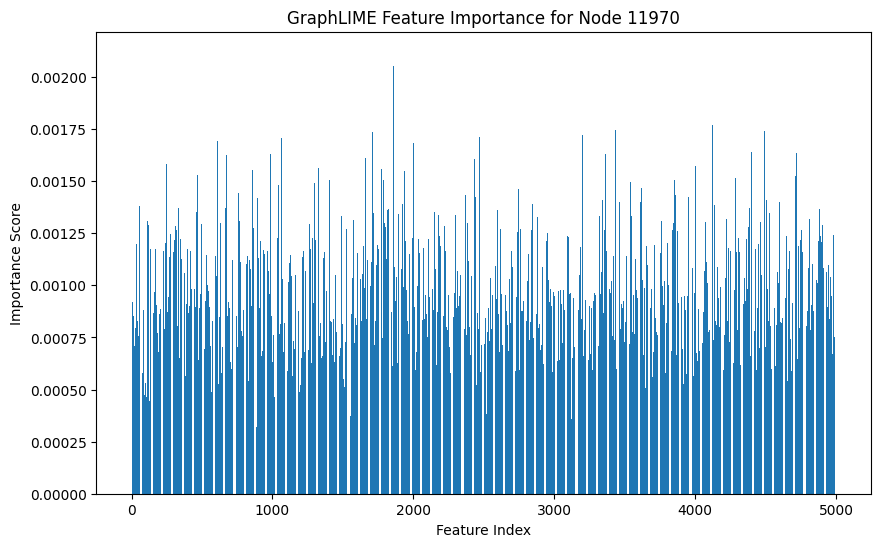

In [ ]:
# ========================================
# Feature Importance for GCN Model using GraphLIME (Shape Mismatch Fix)
# ========================================
import torch
import numpy as np
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from torch_geometric.utils import k_hop_subgraph

# Load the trained GCN model
final_model.eval()

# Prepare input data
original_x = data.x.clone()
num_features = original_x.shape[1]
num_classes = data.y.shape[1]
k = 2  # Number of hops to consider in the local neighborhood
perturbation_magnitude = 0.05  # Magnitude of noise to add to node features

# Function to extract k-hop neighborhood
def get_local_subgraph(node_idx, k, data):
    # Get k-hop subgraph around the node of interest
    subset, edge_index, mapping, edge_mask = k_hop_subgraph(
        node_idx=node_idx, num_hops=k, edge_index=data.edge_index, relabel_nodes=True
    )
    # Extract subgraph data
    subgraph_data = data.clone()
    subgraph_data.x = data.x[subset]
    subgraph_data.edge_index = edge_index
    return subgraph_data, subset

# Define function to perturb node features
def perturb_features(features, perturbation_magnitude, num_perturbations=100):
    perturbed_features = []
    for _ in range(num_perturbations):
        noise = torch.normal(mean=0, std=perturbation_magnitude, size=features.shape)
        perturbed_features.append((features + noise).numpy())
    return np.array(perturbed_features)

# Define the function to train a surrogate model and compute feature importance
def graphlime_explanation(node_idx, data, k, perturbation_magnitude):
    # Extract k-hop subgraph
    subgraph_data, subset = get_local_subgraph(node_idx, k, data)

    # Perturb the features of the target node only
    target_node_features = subgraph_data.x[0].unsqueeze(0)  # Target node features
    perturbed_features = perturb_features(target_node_features, perturbation_magnitude)

    # Get predictions for original and perturbed nodes
    predictions = []
    for features in perturbed_features:
        perturbed_data = subgraph_data.clone()
        perturbed_data.x[0] = torch.tensor(features, dtype=torch.float32, device=original_x.device)
        with torch.no_grad():
            output = final_model(perturbed_data)
        predictions.append(output[0].cpu().numpy())  # Get prediction for the target node (which is mapped to 0)

    # Convert perturbed features and predictions to numpy arrays
    perturbed_features_np = perturbed_features.reshape(perturbed_features.shape[0], -1)  # Shape (num_perturbations, num_features)
    predictions_np = np.array(predictions).reshape(-1, num_classes)  # Shape (num_perturbations, num_classes)

    # Train a linear surrogate model (e.g., Ridge regression)
    surrogate_model = Ridge(alpha=1.0)
    surrogate_model.fit(perturbed_features_np, predictions_np)

    # Get the feature importance from the linear model coefficients
    feature_importance = np.abs(surrogate_model.coef_).mean(axis=0)

    return feature_importance

# Apply GraphLIME for a specific node and plot feature importance
node_idx = 11970  # Change this index to explain a different node
feature_importance = graphlime_explanation(node_idx, data, k, perturbation_magnitude)

# Plot feature importance for the explained node
plt.figure(figsize=(10, 6))
plt.bar(range(num_features), feature_importance)
plt.xlabel('Feature Index')
plt.ylabel('Importance Score')
plt.title(f'GraphLIME Feature Importance for Node {node_idx}')
plt.show()


In [ ]:
# Assuming 'feature_importance' contains the importance scores of features for the explained node

# Get the indices of the top 20 features
top_20_indices = np.argsort(feature_importance)[-20:][::-1]

# Assuming you have the TfidfVectorizer used in the preprocessing stage
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_vectorizer.fit(data_cleaned['resume'])  # Assuming 'data_cleaned' contains the raw text used for TF-IDF

# Get the feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get the actual words for the top 20 features
top_20_words = [feature_names[idx] for idx in top_20_indices]

# Print the top 20 words and their corresponding importance scores
print("Top 20 Most Important Features:")
for i, idx in enumerate(top_20_indices):
    print(f"{i + 1}. {top_20_words[i]} (Importance Score: {feature_importance[idx]:.6f})")


Top 20 Most Important Features:
1. launch (Importance Score: 0.002111)
2. booking (Importance Score: 0.002063)
3. gear (Importance Score: 0.002054)
4. dictionary (Importance Score: 0.002041)
5. jaxb (Importance Score: 0.002020)
6. javabeans (Importance Score: 0.001996)
7. heart (Importance Score: 0.001987)
8. percent (Importance Score: 0.001969)
9. importexport (Importance Score: 0.001949)
10. upgrading (Importance Score: 0.001944)
11. aim (Importance Score: 0.001942)
12. deletion (Importance Score: 0.001928)
13. fidelity (Importance Score: 0.001921)
14. crud (Importance Score: 0.001908)
15. theater (Importance Score: 0.001907)
16. proposed (Importance Score: 0.001897)
17. receivable (Importance Score: 0.001885)
18. hard (Importance Score: 0.001876)
19. packaged (Importance Score: 0.001875)
20. iso (Importance Score: 0.001872)


In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 10.5 MB/s eta 0:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

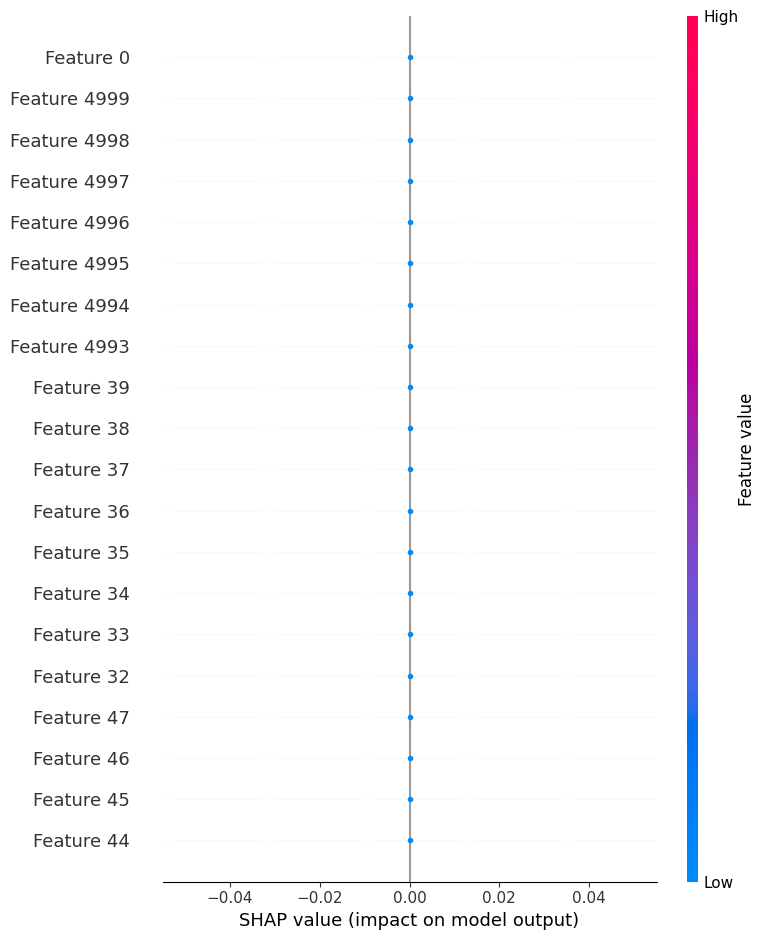

In [ ]:
# ========================================
# Feature Importance for GCN Model using Kernel SHAP (Further Corrected Approach)
# ========================================
import torch
import shap
import numpy as np
import matplotlib.pyplot as plt

# Load the trained GCN model
final_model.eval()

# Prepare input data
original_x = data.x.clone()
num_features = original_x.shape[1]
num_classes = data.y.shape[1]

# Select a subset of nodes to compute SHAP values (e.g., choose one node)
node_idx =19770  # You can change this to analyze a different node

# Extract the feature vector for the selected node
selected_data = original_x[node_idx].unsqueeze(0).numpy()  # Shape: (1, num_features)

# Define a function to use for Kernel SHAP predictions
def model_predict(input_data):
    # Convert the perturbed data into a tensor and place it in the correct device
    input_tensor = torch.tensor(input_data, dtype=torch.float32, device=original_x.device)

    # Clone the original data and replace only the feature vector for the selected node
    perturbed_data = data.clone()
    perturbed_data.x[node_idx] = input_tensor.squeeze(0)

    # Perform a forward pass through the model
    with torch.no_grad():
        output = final_model(perturbed_data)

    # Return the prediction for the selected node
    return torch.sigmoid(output[node_idx]).cpu().numpy()  # Assuming binary classification

# Create a Kernel SHAP explainer for the GCN model (use a single node's features as the background)
explainer = shap.KernelExplainer(model_predict, selected_data)

# Calculate SHAP values for the selected node
shap_values = explainer.shap_values(selected_data)

# Plot SHAP values for each feature
shap.summary_plot(shap_values, features=selected_data, feature_names=[f'Feature {i}' for i in range(num_features)])


In [ ]:
# ========================================
# Feature Importance for GCN Model using Kernel SHAP (Corrected for Batch Prediction)
# ========================================
import torch
import shap
import numpy as np
import matplotlib.pyplot as plt

# Load the trained GCN model
final_model.eval()

# Prepare input data
original_x = data.x.clone()
num_features = original_x.shape[1]
num_classes = data.y.shape[1]

# Select a subset of nodes to compute SHAP values
# Select 100 random nodes as the background set and 10 nodes for explanation
background_indices = torch.randperm(original_x.size(0))[:100]  # Select 100 random nodes for background
explain_indices = torch.randperm(original_x.size(0))[:10]  # Select 10 random nodes to explain

# Extract background data and nodes to explain
background_data = original_x[background_indices].cpu().numpy()  # Shape: (100, num_features)
explain_data = original_x[explain_indices].cpu().numpy()  # Shape: (10, num_features)

# Define a function to use for Kernel SHAP predictions
def model_predict(input_data):
    # Convert the perturbed data into a tensor and place it in the correct device
    input_tensor = torch.tensor(input_data, dtype=torch.float32, device=original_x.device)

    # Clone the original data and replace feature vectors for all nodes being perturbed
    perturbed_data = data.clone()
    perturbed_data.x = original_x.clone()

    # Batch size for the input data
    batch_size = input_tensor.size(0)

    # Create an empty list to store predictions
    predictions = []

    # Iterate over the batch and perform a forward pass for each perturbed sample
    for i in range(batch_size):
        perturbed_data.x[explain_indices] = input_tensor[i]
        with torch.no_grad():
            output = final_model(perturbed_data)
        # Get the predictions for the nodes that are being explained
        predictions.append(torch.sigmoid(output[explain_indices]).cpu().numpy())

    # Convert the list of predictions to a numpy array
    return np.array(predictions)

# Create a Kernel SHAP explainer for the GCN model (using a representative background set)
explainer = shap.KernelExplainer(model_predict, background_data)

# Calculate SHAP values for the selected nodes
shap_values = explainer.shap_values(explain_data)

# Plot SHAP values summary for the selected nodes
shap.summary_plot(shap_values, features=explain_data, feature_names=[f'Feature {i}' for i in range(num_features)])


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# Cell 1: Save the Model and Related Objects to Google Drive

# ========================================
# Step 1: Mount Google Drive
# ========================================
from google.colab import drive
import os
import torch
import json

# Mount Google Drive to the Colab environment
drive.mount('/content/drive')

# ========================================
# Step 2: Define the Directory Path for Saving
# ========================================
# Define the directory path in Google Drive where you want to save the model and other files
# You can change 'checkpoints' to any folder name you prefer
drive_path = '/content/drive/MyDrive/checkpoints'

# Create the directory if it doesn't exist
os.makedirs(drive_path, exist_ok=True)
print(f"Directory '{drive_path}' is ready.")

# ========================================
# Step 3: Save the Model's State Dictionary
# ========================================
# Define the full path for saving the model's state dictionary
model_save_path = os.path.join(drive_path, 'final_model_GCN.pth')

# Save the state dictionary of the trained model
torch.save(final_model.state_dict(), model_save_path)
print(f"Model's state dictionary saved successfully at '{model_save_path}'.")

# ========================================
# Step 4: Save Best Hyperparameters (`best_params`)
# ========================================
# Define the full path for saving best hyperparameters
best_params_save_path = os.path.join(drive_path, 'best_params.json')

# Ensure that `best_params` is a dictionary containing your hyperparameters
# Example:
# best_params = {
#     'lr': 0.001,
#     'hidden_dim': 64,
#     'dropout_rate': 0.5,
#     'weight_decay': 1e-4
# }

# Save `best_params` as a JSON file
with open(best_params_save_path, 'w') as f:
    json.dump(best_params, f, indent=4)
print(f"Best hyperparameters saved successfully at '{best_params_save_path}'.")

# ========================================
# Step 5: Save the Data Object (`data`)
# ========================================
# Define the full path for saving the data object
data_save_path = os.path.join(drive_path, 'data.pth')

# Save the `data` object using PyTorch's `torch.save`
torch.save(data, data_save_path)
print(f"Data object saved successfully at '{data_save_path}'.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Directory '/content/drive/MyDrive/checkpoints' is ready.


NameError: name 'final_model' is not defined

In [ ]:
!pip install torch-geometric

In [ ]:
# Cell 2: Load the Model from Google Drive

# Step 1: Mount Google Drive (if not already mounted)
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Define the path in Google Drive where the model and other files are saved
import os

drive_path = '/content/drive/MyDrive/checkpoints'
model_load_path = os.path.join(drive_path, 'final_model_GCN.pth')
best_params_load_path = os.path.join(drive_path, 'best_params.json')
data_load_path = os.path.join(drive_path, 'data.pth')

# Step 3: Load `best_params`
import json

with open(best_params_load_path, 'r') as f:
    best_params = json.load(f)

print(f"Best hyperparameters loaded from {best_params_load_path}")

# Step 4: Load `data`
import torch

data = torch.load(data_load_path)

print(f"Data object loaded from {data_load_path}")

# Step 5: Define the GCN class (must be identical to the one used during saving)
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, data):
        if edge_mask is not None:
            # Ensure the edge mask is in the correct shape
            edge_mask = edge_mask.sigmoid()  # If the mask isn't already between 0 and 1
            edge_weight = edge_mask  # Use the edge mask as edge weights
        else:
            edge_weight = None  # No masking
        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        return x  # Outputs raw logits

# Step 6: Initialize the model architecture with the loaded parameters
input_dim = data.num_node_features
hidden_dim = best_params['hidden_dim']
output_dim = data.num_classes
dropout_rate = best_params['dropout_rate']

loaded_model = GCN(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    dropout_rate=dropout_rate
)

# Step 7: Load the state dictionary into the model
loaded_model.load_state_dict(torch.load(model_load_path))
loaded_model.eval()

print(f"Model loaded successfully from {model_load_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Best hyperparameters loaded from /content/drive/MyDrive/checkpoints/best_params.json


<ipython-input-4-a47de2114004>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_load_path)


Data object loaded from /content/drive/MyDrive/checkpoints/data.pth
Model loaded successfully from /content/drive/MyDrive/checkpoints/final_model_GCN.pth


<ipython-input-4-a47de2114004>:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_load_path))


In [ ]:
print(loaded_model)


GCN(
  (conv1): GCNConv(5000, 80)
  (conv2): GCNConv(80, 10)
  (dropout): Dropout(p=0.3, inplace=False)
)


### PGExplainer

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

# Define your GCN model (as you've done previously)
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x  # Outputs raw logits

# Initialize and train your model
device = torch.device('cpu')  # Stick to CPU to conserve resources
model = GCN(input_dim=5000, hidden_dim=96, output_dim=10, dropout_rate=0.3).to(device)
model.train()

# [Your training loop here]
# After training, set the model to evaluation mode
model.eval()


GCN(
  (conv1): GCNConv(5000, 96)
  (conv2): GCNConv(96, 10)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
# Clone the PGExplainer repository (if available)
# Install PyTorch Geometric dependencies
!pip install torch torchvision torchaudio
!pip install torch-geometric

git clone https://github.com/divelab/pgexplainer.git
cd pgexplainer
pip install -r requirements.txt
python setup.py install

SyntaxError: invalid syntax (<ipython-input-11-24f32c8fb665>, line 6)

In [ ]:
from pgexplainer import PGExplainer  # Replace with actual import based on implementation

# Initialize PGExplainer with your trained model
explainer = PGExplainer(model, embedding_dim=128).to(device)  # Adjust parameters as needed

# Train the explainer
explainer.train(
    data,  # Your PyG data object
    epochs=200,  # Number of training epochs for the explainer
    lr=0.01,  # Learning rate
    batch_size=256  # Adjust based on memory constraints
)

# Save the explainer if needed
torch.save(explainer.state_dict(), 'pgexplainer.pth')


ModuleNotFoundError: No module named 'pgexplainer'

### Captum

In [ ]:
!pip install captum

In [ ]:
import torch
from captum.attr import IntegratedGradients, DeepLift
import torch.nn.functional as F

# Example: Define a baseline (all zeros)
baseline = torch.zeros_like(data.x)
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x  # Outputs raw logits

# Initialize the attribution methods
ig = IntegratedGradients(loaded_model)
dl = DeepLift(loaded_model)
# Example: Select a target node from the test set
test_indices = data.test_mask.nonzero(as_tuple=False).view(-1).numpy()
target_node = test_indices[0]  # Change index as needed


In [ ]:
def perform_feature_importance_analysis(wrapped_model, data, target_nodes, feature_names, mlb, class_indices, method='IG', topk=20):
    """
    Performs feature importance analysis using Captum's IG or DL for multiple nodes and classes.

    Parameters:
    - wrapped_model (ModelWrapper): The wrapped GCN model.
    - data (torch_geometric.data.Data): The PyG data object.
    - target_nodes (list or np.ndarray): List of node indices to explain.
    - feature_names (list): List of feature names.
    - mlb (MultiLabelBinarizer): The label binarizer.
    - class_indices (list): List of class indices to explain.
    - method (str): Attribution method ('IG' or 'DL').
    - topk (int): Number of top features to display.

    Returns:
    - None
    """
    # Initialize the appropriate attributer
    if method == 'IG':
        attributer = IntegratedGradients(wrapped_model)
    elif method == 'DL':
        attributer = DeepLift(wrapped_model)
    else:
        raise ValueError("Unsupported method. Choose 'IG' or 'DL'.")

    for node in target_nodes:
        for class_idx in class_indices:
            # Define baseline (all zeros)
            baseline = torch.zeros_like(data.x)

            # Select the target node's feature vector
            target_x = data.x[node].unsqueeze(0)  # Shape: [1, num_features]

            # Compute attributions
            attributions = attributer.attribute(target_x, baselines=baseline[node].unsqueeze(0), target=class_idx)
            attributions = attributions.squeeze(0).detach().cpu().numpy()

            # Get top-k features
            top_indices = np.argsort(np.abs(attributions))[-topk:]
            top_features = feature_names[top_indices]
            top_attributions = attributions[top_indices]

            # Create a DataFrame for better visualization
            shap_df = pd.DataFrame({
                'Feature': top_features,
                'Attribution': top_attributions
            }).sort_values(by='Attribution', ascending=True)

            # Plot
            plt.figure(figsize=(10, 8))
            plt.barh(shap_df['Feature'], shap_df['Attribution'], color='skyblue' if method == 'IG' else 'salmon')
            plt.xlabel('Attribution Value')
            plt.title(f'{method} Feature Importance for Node {node}, Class {mlb.classes_[class_idx]}')
            plt.tight_layout()
            plt.show()

            # Optionally, print convergence delta for Integrated Gradients
            if method == 'IG':
                delta = attributer.convergence_delta
                print(f"Convergence Delta for IG on Node {node}, Class {mlb.classes_[class_idx]}: {delta:.4f}")


DON'T USE

In [ ]:
# Assuming you've already trained your model and saved the state_dict
model = GCN(input_dim=5000, hidden_dim=80, output_dim=10, dropout_rate=0.3)
drive_path = '/content/drive/MyDrive/checkpoints'
model_load_path = os.path.join(drive_path, 'final_model_GCN.pth')
model.load_state_dict(torch.load(model_load_path))
model.eval()  # Set the model to evaluation mode


<ipython-input-24-432f1968e7f0>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path))


GCN(
  (conv1): GCNConv(5000, 80)
  (conv2): GCNConv(80, 10)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
# Example:
print(data)


Data(x=[29065, 5000], edge_index=[2, 105944], y=[29065, 10], train_mask=[29065], val_mask=[29065], test_mask=[29065], num_classes=10, num_node_features=5000)


In [ ]:
import torch
from torch_geometric.data import Data

class ModelAttributionWrapper(torch.nn.Module):
    def __init__(self, model, edge_index, target_node, target_class):
        """
        Initializes the ModelAttributionWrapper.

        Parameters:
        - model (torch.nn.Module): The trained GCN model.
        - edge_index (torch.Tensor): The edge index tensor of the graph.
        - target_node (int): The index of the node to explain.
        - target_class (int): The index of the class to explain.
        """
        super(ModelAttributionWrapper, self).__init__()
        self.model = model
        self.edge_index = edge_index
        self.target_node = target_node
        self.target_class = target_class

    def forward(self, x):
        """
        Forward pass that returns the prediction for the target node and class.

        Parameters:
        - x (torch.Tensor): The node feature matrix.

        Returns:
        - torch.Tensor: Scalar prediction for the target node and class.
        """
        # Reconstruct the Data object with the given x and edge_index
        data_subset = Data(x=x, edge_index=self.edge_index).to(x.device)

        # Forward pass through the model
        out = self.model(data_subset)

        # Ensure the output shape matches expectations
        assert out.shape[0] == data_subset.num_nodes, "Output node count mismatch."
        assert out.shape[1] == data_subset.num_classes, "Output class count mismatch."

        # Extract the prediction for the target node and class
        node_out = out[self.target_node]
        class_pred = node_out[self.target_class]
        return class_pred




In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients, DeepLift

def compute_and_plot_attributions(model, data, target_node, class_idx, feature_names, topk=5, device='cpu'):
    """
    Computes and plots feature attributions for a specific node and class using IG and DL.

    Parameters:
    - model (torch.nn.Module): The trained GCN model.
    - data (torch_geometric.data.Data): The PyG data object.
    - target_node (int): The node index to explain.
    - class_idx (int): The class index to explain.
    - feature_names (list): List of feature names.
    - topk (int): Number of top features to display.
    - device (str): Device to perform computations ('cpu' or 'cuda').

    Returns:
    - None
    """
    try:
        print(f"\nStarting attribution for Node {target_node}, Class '{mlb.classes_[class_idx]}'")

        # Instantiate the ModelAttributionWrapper
        attribution_model = ModelAttributionWrapper(
            model=model,
            edge_index=data.edge_index,
            target_node=target_node,
            target_class=class_idx
        ).to(device)
        attribution_model.eval()

        # Initialize Captum's attribution methods
        ig = IntegratedGradients(attribution_model)
        dl = DeepLift(attribution_model)

        # Prepare the input feature matrix
        x = data.x.clone().detach().requires_grad_(True).to(device)

        # Define baseline (all zeros)
        baseline = torch.zeros_like(x).to(device)  # Shape: [num_nodes, num_features]

        # Compute attributions using Integrated Gradients
        attributions_ig = ig.attribute(x, baselines=baseline)
        # Extract attributions for the target node
        attributions_ig = attributions_ig[target_node].detach().cpu().numpy()

        # Compute attributions using DeepLift
        attributions_dl = dl.attribute(x, baselines=baseline)
        # Extract attributions for the target node
        attributions_dl = attributions_dl[target_node].detach().cpu().numpy()

        # Identify topk features for IG
        top_indices_ig = np.argsort(np.abs(attributions_ig))[-topk:]
        top_features_ig = feature_names[top_indices_ig]
        top_attributions_ig = attributions_ig[top_indices_ig]

        # Identify topk features for DL
        top_indices_dl = np.argsort(np.abs(attributions_dl))[-topk:]
        top_features_dl = feature_names[top_indices_dl]
        top_attributions_dl = attributions_dl[top_indices_dl]

        # Create DataFrames for visualization
        shap_df_ig = pd.DataFrame({
            'Feature': top_features_ig,
            'Attribution': top_attributions_ig
        }).sort_values(by='Attribution', ascending=True)

        shap_df_dl = pd.DataFrame({
            'Feature': top_features_dl,
            'Attribution': top_attributions_dl
        }).sort_values(by='Attribution', ascending=True)

        # Plot for Integrated Gradients
        plt.figure(figsize=(10, 6))
        plt.barh(shap_df_ig['Feature'], shap_df_ig['Attribution'], color='skyblue')
        plt.xlabel('Attribution Value')
        plt.title(f'Integrated Gradients Feature Importance\nNode {target_node}, Class {mlb.classes_[class_idx]}')
        plt.tight_layout()
        plt.show()

        # Plot for DeepLift
        plt.figure(figsize=(10, 6))
        plt.barh(shap_df_dl['Feature'], shap_df_dl['Attribution'], color='salmon')
        plt.xlabel('Attribution Value')
        plt.title(f'DeepLift Feature Importance\nNode {target_node}, Class {mlb.classes_[class_idx]}')
        plt.tight_layout()
        plt.show()

        # Print convergence delta for IG
        delta_ig = ig.convergence_delta
        print(f"Convergence Delta for IG on Node {target_node}, Class {mlb.classes_[class_idx]}: {delta_ig:.4f}")

        # Print convergence delta for DL
        delta_dl = dl.convergence_delta
        print(f"Convergence Delta for DL on Node {target_node}, Class {mlb.classes_[class_idx]}: {delta_dl:.4f}")

    except Exception as e:
        print(f"Failed to compute attribution for Node {target_node}: {e}")


In [ ]:
# Execute the preprocessing
print("Starting Data Preprocessing...")
data, mlb, tfidf_vectorizer = preprocess_data(data_cleaned)
print("Data Preprocessing Completed.")


Starting Data Preprocessing...


NameError: name 'preprocess_data' is not defined

In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x  # Outputs raw logits

# Initialize the model with appropriate dimensions
input_dim = data.num_node_features  # 5000
hidden_dim = 96  # Example value
output_dim = data.num_classes  # 10
dropout_rate = 0.3

final_model = GCN(input_dim, hidden_dim, output_dim, dropout_rate).to(device)


In [ ]:
# Example target node and class
target_node = target_nodes[0]  # Replace with your target node index
class_idx = 0  # Replace with your target class index

# Instantiate the wrapper
attribution_model = ModelAttributionWrapper(
    model=final_model,
    edge_index=data.edge_index,
    target_node=target_node,
    target_class=class_idx
).to(device)
attribution_model.eval()

# Initialize Captum's attribution methods
ig = IntegratedGradients(attribution_model)
dl = DeepLift(attribution_model)


In [ ]:
# Select a single target node from the test set
single_target_node = test_indices[0]  # Replace with an appropriate index

# Define a lower topk value
topk = 2

# Run attribution
compute_and_plot_attributions(
    model=final_model,
    data=data,
    target_node=single_target_node,
    class_idx=class_idx,
    feature_names=feature_names,
    topk=topk,
    device=device
)


In [ ]:
# Get feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Select target nodes from the test set
test_indices = data.test_mask.nonzero(as_tuple=False).view(-1).cpu().numpy()
target_nodes = test_indices[:5]  # Adjust the number as needed

# Define the class index you are interested in
class_idx = 0  # Change as needed (0 to num_classes-1)

print(f"Target Nodes: {target_nodes}")
print(f"Target Class Index: {class_idx} ({mlb.classes_[class_idx]})")

# Compute and plot attributions
for node in target_nodes:
    compute_and_plot_attributions(
        model=final_model,
        data=data,
        target_node=node,
        class_idx=class_idx,
        feature_names=feature_names,
        topk=5,  # Adjust as needed
        device=device
    )


Target Nodes: [ 1  4  9 18 19]
Target Class Index: 0 (Database_Administrator)

Starting attribution for Node 1, Class 'Database_Administrator'


In [ ]:
# Select target nodes from the test set
test_indices = data.test_mask.nonzero(as_tuple=False).view(-1).numpy()
if len(test_indices) == 0:
    raise ValueError("No test nodes found. Ensure that the test_mask is correctly set.")
target_nodes = test_indices[:5]  # Adjust the number as needed

# Define the class index you are interested in
class_idx = 0  # Change as needed (0 to 9 for your 10 classes)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def compute_and_plot_attributions(model, data, target_node, class_idx, feature_names, topk=20, device='cpu'):
    """
    Computes and plots feature attributions for a specific node and class using IG and DL.

    Parameters:
    - model (torch.nn.Module): The trained GCN model.
    - data (torch_geometric.data.Data): The PyG data object.
    - target_node (int): The node index to explain.
    - class_idx (int): The class index to explain.
    - feature_names (list): List of feature names.
    - topk (int): Number of top features to display.
    - device (str): Device to perform computations ('cpu' or 'cuda').

    Returns:
    - None
    """
    # Create the ModelAttributionWrapper for the specific node and class
    attribution_model = ModelAttributionWrapper(model, data, target_node, class_idx).to(device)
    attribution_model.eval()

    # Initialize Captum's attribution methods
    ig = IntegratedGradients(attribution_model)
    dl = DeepLift(attribution_model)

    # Ensure x requires grad
    x = data.x.clone().detach().requires_grad_(True).to(device)

    # Define baseline (all zeros)
    baseline = torch.zeros_like(x).to(device)  # Shape: [num_nodes, num_features]

    # Integrated Gradients
    attributions_ig = ig.attribute(x, baselines=baseline)
    # Focus on target node's attributions
    attributions_ig = attributions_ig[target_node].detach().cpu().numpy()

    # DeepLift
    attributions_dl = dl.attribute(x, baselines=baseline)
    # Focus on target node's attributions
    attributions_dl = attributions_dl[target_node].detach().cpu().numpy()

    # Get topk features for IG
    top_indices_ig = np.argsort(np.abs(attributions_ig))[-topk:]
    top_features_ig = feature_names[top_indices_ig]
    top_attributions_ig = attributions_ig[top_indices_ig]

    # Get topk features for DL
    top_indices_dl = np.argsort(np.abs(attributions_dl))[-topk:]
    top_features_dl = feature_names[top_indices_dl]
    top_attributions_dl = attributions_dl[top_indices_dl]

    # Create DataFrames for better visualization
    shap_df_ig = pd.DataFrame({
        'Feature': top_features_ig,
        'Attribution': top_attributions_ig
    }).sort_values(by='Attribution', ascending=True)

    shap_df_dl = pd.DataFrame({
        'Feature': top_features_dl,
        'Attribution': top_attributions_dl
    }).sort_values(by='Attribution', ascending=True)

    # Plot for Integrated Gradients
    plt.figure(figsize=(10, 8))
    plt.barh(shap_df_ig['Feature'], shap_df_ig['Attribution'], color='skyblue')
    plt.xlabel('Attribution Value')
    plt.title(f'Integrated Gradients Feature Importance\nNode {target_node}, Class {mlb.classes_[class_idx]}')
    plt.tight_layout()
    plt.show()

    # Plot for DeepLift
    plt.figure(figsize=(10, 8))
    plt.barh(shap_df_dl['Feature'], shap_df_dl['Attribution'], color='salmon')
    plt.xlabel('Attribution Value')
    plt.title(f'DeepLift Feature Importance\nNode {target_node}, Class {mlb.classes_[class_idx]}')
    plt.tight_layout()
    plt.show()

    # Optionally, print convergence delta for Integrated Gradients
    delta_ig = ig.convergence_delta
    print(f"Convergence Delta for IG on Node {target_node}, Class {mlb.classes_[class_idx]}: {delta_ig:.4f}")

    # Similarly, for DeepLift
    delta_dl = dl.convergence_delta
    print(f"Convergence Delta for DL on Node {target_node}, Class {mlb.classes_[class_idx]}: {delta_dl:.4f}")

    return


In [ ]:
def preprocess_data(data_cleaned):
    # Extract labels
    y = data_cleaned['label_list'].tolist()

    # Initialize MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    one_hot_labels = mlb.fit_transform(y)
    num_classes = one_hot_labels.shape[1]

    print("\nClasses:", mlb.classes_)
    print("One-Hot Encoded Labels Shape:", one_hot_labels.shape)

    # Stratified Splitting (60% Train, 20% Val, 20% Test)
    X = np.arange(len(data_cleaned))
    y_labels = one_hot_labels

    msss_train = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
    train_idx, temp_idx = next(msss_train.split(X, y_labels))

    msss_val_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    val_temp_idx, test_temp_idx = next(msss_val_test.split(X[temp_idx], y_labels[temp_idx]))

    val_idx = temp_idx[val_temp_idx]
    test_idx = temp_idx[test_temp_idx]

    # Feature Extraction with TF-IDF (fit on training data)
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    tfidf_vectorizer.fit(data_cleaned['resume'].iloc[train_idx])
    tfidf_features = tfidf_vectorizer.transform(data_cleaned['resume'])
    print("\nTF-IDF Feature Shape:", tfidf_features.shape)

    # Scaling TF-IDF Features (fit on training data)
    scaler = StandardScaler(with_mean=False)
    scaler.fit(tfidf_features[train_idx])
    scaled_tfidf = scaler.transform(tfidf_features).toarray()
    print("Scaled TF-IDF Feature Shape:", scaled_tfidf.shape)

    # Prepare node features for resumes
    resume_features = scaled_tfidf  # shape (num_resumes, 5000)

    # Prepare job label nodes for each split
    job_labels = mlb.classes_
    num_jobs = len(job_labels)

    # Create job label nodes for each split
    num_splits = 3  # train, val, test
    total_job_nodes = num_jobs * num_splits
    total_resume_nodes = len(data_cleaned)
    total_nodes = total_resume_nodes + total_job_nodes

    # Create features for job label nodes
    # For simplicity, we'll use one-hot encoding for job labels
    job_features = np.eye(num_jobs)  # shape (num_jobs, num_jobs)

    # Repeat job features for each split
    job_features_all = np.vstack([job_features for _ in range(num_splits)])  # shape (total_job_nodes, num_jobs)
    print("\nJob Features Shape:", job_features_all.shape)

    # Pad job_features_all to match the dimension of resume_features
    tfidf_dim = resume_features.shape[1]  # e.g., 5000
    job_features_dim = job_features_all.shape[1]  # e.g., num_jobs
    padding_dim = tfidf_dim - job_features_dim

    if padding_dim < 0:
        raise ValueError("TF-IDF dimension is smaller than the number of job features.")

    # Pad job_features_all with zeros
    job_features_padded = np.hstack([job_features_all, np.zeros((job_features_all.shape[0], padding_dim))])
    print("Padded Job Features Shape:", job_features_padded.shape)  # Should be (total_job_nodes, tfidf_dim)

    # Combine resume features and padded job features
    combined_features = np.vstack([resume_features, job_features_padded])
    print("Combined Features Shape:", combined_features.shape)  # Should be (total_nodes, tfidf_dim)

    # Construct edges
    edges = []

    # Mapping from job label to job node index per split
    job_node_offset = {
        'train': total_resume_nodes,
        'val': total_resume_nodes + num_jobs,
        'test': total_resume_nodes + 2 * num_jobs
    }

    # Helper function to get job node index for a label and split
    def get_job_node_index(label, split):
        job_idx = np.where(job_labels == label)[0][0]
        return job_node_offset[split] + job_idx

    # Construct edges for training data
    for idx in train_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'train')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    # Construct edges for validation data
    for idx in val_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'val')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    # Construct edges for test data
    for idx in test_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'test')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    print("\nEdge Index Shape:", edge_index.shape)
    print("Number of Nodes:", total_nodes)
    print("Number of Edges:", edge_index.size(1))

    # Initialize all masks as False
    train_mask = torch.zeros(total_nodes, dtype=torch.bool)
    val_mask = torch.zeros(total_nodes, dtype=torch.bool)
    test_mask = torch.zeros(total_nodes, dtype=torch.bool)

    # Setting masks for resume nodes only
    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True

    print("\nNumber of Training Nodes:", train_mask.sum().item())
    print("Number of Validation Nodes:", val_mask.sum().item())
    print("Number of Test Nodes:", test_mask.sum().item())

    # Prepare labels
    # For job label nodes, we can set labels to zeros (or any placeholder)
    # Since we're focusing on predicting labels for resume nodes
    zero_labels = np.zeros((total_job_nodes, num_classes))
    one_hot_labels_padded = np.vstack([one_hot_labels, zero_labels])
    labels = torch.tensor(one_hot_labels_padded, dtype=torch.float)

    x = torch.tensor(combined_features, dtype=torch.float)

    data = Data(
        x=x,
        edge_index=edge_index,
        y=labels,
        train_mask=train_mask,
        val_mask=val_mask,
        test_mask=test_mask
    )

    data.num_classes = num_classes
    data.num_node_features = x.shape[1]

    print("\nPyG Data Object with Masks:")
    print(data)

    return data, mlb, tfidf_vectorizer  # Return tfidf_vectorizer as well


In [ ]:
import random
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, cohen_kappa_score, f1_score, roc_auc_score
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from torch_geometric.explain import GNNExplainer

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# ========================================
# Seed Setting for Reproducibility
# ========================================
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

set_seeds(42)

# ========================================
# Data Preprocessing Function
# ========================================
def preprocess_data(data_cleaned, tfidf_max_features=5090):
    """
    Preprocesses the input data for the GCN model.

    Parameters:
    - data_cleaned (pd.DataFrame): DataFrame containing 'resume' and 'label_list' columns.
    - tfidf_max_features (int): Number of features for TF-IDF vectorization.

    Returns:
    - data (torch_geometric.data.Data): Preprocessed PyG data object.
    - mlb (MultiLabelBinarizer): Fitted label binarizer.
    - tfidf_vectorizer (TfidfVectorizer): Fitted TF-IDF vectorizer.
    """
    # Extract labels
    y = data_cleaned['label_list'].tolist()

    # Initialize MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    one_hot_labels = mlb.fit_transform(y)
    num_classes = one_hot_labels.shape[1]

    print("\nClasses:", mlb.classes_)
    print("One-Hot Encoded Labels Shape:", one_hot_labels.shape)

    # Stratified Splitting (60% Train, 20% Val, 20% Test)
    X = np.arange(len(data_cleaned))
    y_labels = one_hot_labels

    msss_train = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
    train_idx, temp_idx = next(msss_train.split(X, y_labels))

    msss_val_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    val_temp_idx, test_temp_idx = next(msss_val_test.split(X[temp_idx], y_labels[temp_idx]))

    val_idx = temp_idx[val_temp_idx]
    test_idx = temp_idx[test_temp_idx]

    # Feature Extraction with TF-IDF (fit on training data)
    tfidf_vectorizer = TfidfVectorizer(max_features=tfidf_max_features, stop_words='english')
    tfidf_vectorizer.fit(data_cleaned['resume'].iloc[train_idx])
    tfidf_features = tfidf_vectorizer.transform(data_cleaned['resume'])
    print(f"\nTF-IDF Feature Shape: {tfidf_features.shape}")

    # Scaling TF-IDF Features (fit on training data)
    scaler = StandardScaler(with_mean=False)
    scaler.fit(tfidf_features[train_idx])
    scaled_tfidf = scaler.transform(tfidf_features).toarray()
    print(f"Scaled TF-IDF Feature Shape: {scaled_tfidf.shape}")

    # Prepare node features for resumes
    resume_features = scaled_tfidf  # shape (num_resumes, tfidf_max_features)

    # Prepare job label nodes for each split
    job_labels = mlb.classes_
    num_jobs = len(job_labels)

    # Create job label nodes for each split
    num_splits = 3  # train, val, test
    total_job_nodes = num_jobs * num_splits
    total_resume_nodes = len(data_cleaned)
    total_nodes = total_resume_nodes + total_job_nodes

    # Create features for job label nodes
    # For simplicity, we'll use one-hot encoding for job labels
    job_features = np.eye(num_jobs)  # shape (num_jobs, num_jobs)

    # Repeat job features for each split
    job_features_all = np.vstack([job_features for _ in range(num_splits)])  # shape (total_job_nodes, num_jobs)
    print(f"\nJob Features Shape: {job_features_all.shape}")

    # Pad job_features_all to match the dimension of resume_features
    tfidf_dim = resume_features.shape[1]  # e.g., 5090
    job_features_dim = job_features_all.shape[1]  # e.g., num_jobs
    padding_dim = tfidf_dim - job_features_dim

    if padding_dim < 0:
        raise ValueError("TF-IDF dimension is smaller than the number of job features.")

    # Pad job_features_all with zeros
    job_features_padded = np.hstack([job_features_all, np.zeros((job_features_all.shape[0], padding_dim))])
    print(f"Padded Job Features Shape: {job_features_padded.shape}")  # Should be (total_job_nodes, tfidf_dim)

    # Combine resume features and padded job features
    combined_features = np.vstack([resume_features, job_features_padded])
    print(f"Combined Features Shape: {combined_features.shape}")  # Should be (total_nodes, tfidf_dim)

    # Construct edges
    edges = []

    # Mapping from job label to job node index per split
    job_node_offset = {
        'train': total_resume_nodes,
        'val': total_resume_nodes + num_jobs,
        'test': total_resume_nodes + 2 * num_jobs
    }

    # Helper function to get job node index for a label and split
    def get_job_node_index(label, split):
        job_idx = np.where(job_labels == label)[0][0]
        return job_node_offset[split] + job_idx

    # Construct edges for training data
    for idx in train_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'train')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    # Construct edges for validation data
    for idx in val_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'val')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    # Construct edges for test data
    for idx in test_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'test')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    print(f"\nEdge Index Shape: {edge_index.shape}")
    print(f"Number of Nodes: {total_nodes}")
    print(f"Number of Edges: {edge_index.size(1)}")

    # Initialize all masks as False
    train_mask = torch.zeros(total_nodes, dtype=torch.bool)
    val_mask = torch.zeros(total_nodes, dtype=torch.bool)
    test_mask = torch.zeros(total_nodes, dtype=torch.bool)

    # Setting masks for resume nodes only
    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True

    print(f"\nStratified Train Indices: {train_idx}")
    print(f"Stratified Validation Indices: {val_idx}")
    print(f"Stratified Test Indices: {test_idx}")

    # Prepare labels
    # For job label nodes, we can set labels to zeros (or any placeholder)
    # Since we're focusing on predicting labels for resume nodes
    zero_labels = np.zeros((total_job_nodes, num_classes))
    one_hot_labels_padded = np.vstack([one_hot_labels, zero_labels])
    labels = torch.tensor(one_hot_labels_padded, dtype=torch.float)

    x = torch.tensor(combined_features, dtype=torch.float)

    data = Data(
        x=x,
        edge_index=edge_index,
        y=labels,
        train_mask=train_mask,
        val_mask=val_mask,
        test_mask=test_mask
    )

    data.num_classes = num_classes
    data.num_node_features = x.shape[1]

    print(f"\nPyG Data Object with Masks:\n{data}")

    return data, mlb, tfidf_vectorizer

# ========================================
# Define the GCN Model
# ========================================
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, x, edge_index, edge_mask=None):
        if edge_mask is not None:
            # Apply edge mask as edge weights
            edge_mask = edge_mask.sigmoid()
            edge_weight = edge_mask
        else:
            edge_weight = None

        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        return x  # Outputs raw logits

# ========================================
# Training Function
# ========================================
def filter_edge_index(edge_index, node_mask):
    """
    Filters the edge_index to include only edges between nodes in node_mask.

    Parameters:
    - edge_index (torch.Tensor): Edge indices.
    - node_mask (torch.Tensor): Boolean mask of nodes to include.

    Returns:
    - torch.Tensor: Filtered edge indices.
    """
    # Get indices of nodes that are in the mask
    node_indices = torch.nonzero(node_mask, as_tuple=False).view(-1)
    node_indices_set = set(node_indices.tolist())

    # Filter edges where both source and target nodes are in node_indices_set
    mask = [(src.item() in node_indices_set and dst.item() in node_indices_set) for src, dst in edge_index.t()]
    filtered_edge_index = edge_index[:, mask]
    return filtered_edge_index

def train(model, data, optimizer, criterion):
    """
    Trains the GCN model for one epoch.

    Parameters:
    - model (torch.nn.Module): The GCN model.
    - data (torch_geometric.data.Data): The PyG data object.
    - optimizer (torch.optim.Optimizer): Optimizer.
    - criterion (torch.nn.Module): Loss function.

    Returns:
    - float: Loss value.
    """
    model.train()
    optimizer.zero_grad()
    # Create subgraph for training
    train_data = Data(
        x=data.x[data.train_mask],
        edge_index=filter_edge_index(data.edge_index, data.train_mask),
        y=data.y[data.train_mask]
    )
    out = model(train_data.x, train_data.edge_index)
    loss = criterion(out, train_data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# ========================================
# Evaluation Function
# ========================================
def evaluate(model, data, mlb):
    """
    Evaluates the GCN model on the validation set.

    Parameters:
    - model (torch.nn.Module): The GCN model.
    - data (torch_geometric.data.Data): The PyG data object.
    - mlb (MultiLabelBinarizer): The label binarizer.

    Returns:
    - None
    """
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        y_pred = torch.sigmoid(out).cpu().numpy()

        # Extract predictions and true labels for validation set
        val_pred = (y_pred[data.val_mask] >= 0.5).astype(int)
        val_true = data.y[data.val_mask].cpu().numpy()

        # Classification Report for Validation Set
        print("\nValidation Classification Report:")
        print(classification_report(val_true, val_pred, target_names=mlb.classes_, zero_division=0))

        # Flatten the arrays for multi-label case to use Cohen's kappa score
        val_true_flat = val_true.flatten()
        val_pred_flat = val_pred.flatten()

        # Calculate Cohen's Kappa Score
        kappa_val = cohen_kappa_score(val_true_flat, val_pred_flat)
        print(f"Cohen's Kappa Score (Validation Set): {kappa_val:.4f}")

        # Calculate Weighted F1-score for Validation Set
        weighted_f1 = f1_score(val_true, val_pred, average='weighted')
        print(f"Weighted F1-score (Validation Set): {weighted_f1:.4f}")

        # Compute ROC AUC for Validation Set
        try:
            auc_val = roc_auc_score(val_true, y_pred[data.val_mask], average='macro')
            print(f"ROC AUC Score (Validation Set): {auc_val:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Validation Set) could not be computed: {e}")

# ========================================
# Training the Final Model with Best Hyperparameters
# ========================================
def train_final_model(data, mlb, best_params):
    """
    Trains the GCN model with the best hyperparameters.

    Parameters:
    - data (torch_geometric.data.Data): The PyG data object.
    - mlb (MultiLabelBinarizer): The label binarizer.
    - best_params (dict): Best hyperparameters.

    Returns:
    - torch.nn.Module: Trained GCN model.
    """
    # Initialize the model with best hyperparameters
    model = GCN(
        input_dim=data.num_node_features,
        hidden_dim=best_params['hidden_dim'],
        output_dim=data.num_classes,
        dropout_rate=best_params['dropout_rate']
    )

    # === Compute Class Weights ===
    y_train = data.y[data.train_mask].cpu().numpy()
    num_train_samples, num_classes = y_train.shape

    positive_counts = y_train.sum(axis=0)
    negative_counts = num_train_samples - positive_counts

    # Add epsilon to avoid division by zero
    epsilon = 1e-6
    pos_weight_values = (negative_counts + epsilon) / (positive_counts + epsilon)
    pos_weight = torch.tensor(pos_weight_values, dtype=torch.float)

    print("\nPositive Counts per Class:", positive_counts)
    print("Negative Counts per Class:", negative_counts)
    print("Pos Weight per Class:", pos_weight)

    # Define optimizer and loss function with class weights
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=best_params['lr'],
        weight_decay=best_params['weight_decay']
    )
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Training parameters
    max_epochs = 200  # Increased epochs for final training
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, max_epochs + 1):
        loss = train(model, data, optimizer, criterion)

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index)
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask]).item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_gcn_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        if epoch % 20 == 0 or epoch == 1:
            # Calculate training accuracy
            preds = torch.sigmoid(out[data.train_mask]) >= 0.5
            correct = preds.eq(data.y[data.train_mask] >= 0.5).sum().item()
            acc = correct / data.y[data.train_mask].numel()
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {acc:.4f}')

    # Load the best model
    # Address the FutureWarning by setting weights_only=True if supported
    try:
        model.load_state_dict(torch.load('best_gcn_model.pth', weights_only=True))
    except TypeError:
        # If weights_only is not supported, load normally
        model.load_state_dict(torch.load('best_gcn_model.pth'))

    return model

# ========================================
# Evaluation Function for Final Model
# ========================================
def evaluate_final_model(model, data, mlb):
    """
    Evaluates the trained GCN model on the validation set.

    Parameters:
    - model (torch.nn.Module): The trained GCN model.
    - data (torch_geometric.data.Data): The PyG data object.
    - mlb (MultiLabelBinarizer): The label binarizer.

    Returns:
    - None
    """
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        y_pred = torch.sigmoid(out).cpu().numpy()

        # Validation Set Evaluation
        val_pred = (y_pred[data.val_mask] >= 0.5).astype(int)
        val_true = data.y[data.val_mask].cpu().numpy()

        print("\nValidation Classification Report:")
        print(classification_report(val_true, val_pred, target_names=mlb.classes_, zero_division=0))

        val_true_flat = val_true.flatten()
        val_pred_flat = val_pred.flatten()

        kappa_val = cohen_kappa_score(val_true_flat, val_pred_flat)
        print(f"Cohen's Kappa Score (Validation Set): {kappa_val:.4f}")

        weighted_f1 = f1_score(val_true, val_pred, average='weighted')
        print(f"Weighted F1-score (Validation Set): {weighted_f1:.4f}")

        try:
            auc_val = roc_auc_score(val_true, y_pred[data.val_mask], average='macro')
            print(f"ROC AUC Score (Validation Set): {auc_val:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Validation Set) could not be computed: {e}")

# ========================================
# GNNExplainer Functions
# ========================================
def perform_gnn_explanation(model, data, target_node, feature_names, num_hops=1, topk=20):
    """
    Performs GNNExplainer on a specific target node.

    Parameters:
    - model (torch.nn.Module): The trained GCN model.
    - data (torch_geometric.data.Data): The PyG data object.
    - target_node (int): The node index to explain.
    - feature_names (list): Names of the features.
    - num_hops (int): Number of hops to include in the explanation.
    - topk (int): Number of top features to display.

    Returns:
    - None
    """
    explainer = GNNExplainer(model=model, epochs=200)

    # Explain the target node
    explanation = explainer.explain_node(target_node, data.x, data.edge_index, num_hops=num_hops)

    # Visualize the subgraph
    ax = plt.subplot(1, 1, 1)
    explainer.visualize_subgraph(target_node, explanation.edge_mask,
                                 edge_threshold=0.2, ax=ax, show=False)
    plt.title(f"GNNExplainer: Subgraph for Node {target_node}")
    plt.show()

    # Get feature importances
    feature_importances = explanation.feature_mask.detach().cpu().numpy()

    # Create a DataFrame for better visualization
    shap_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

    # Sort by importance
    shap_df = shap_df.sort_values(by='Importance', ascending=False).head(topk)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.barh(shap_df['Feature'][::-1], shap_df['Importance'][::-1], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.title(f"GNNExplainer: Feature Importances for Node {target_node}")
    plt.tight_layout()
    plt.show()

def explain_multiple_nodes_gnn(model, data, mlb, target_nodes, feature_names, num_hops=1, topk=20):
    """
    Performs GNNExplainer on multiple target nodes.

    Parameters:
    - model (torch.nn.Module): The trained GCN model.
    - data (torch_geometric.data.Data): The PyG data object.
    - mlb (MultiLabelBinarizer): The label binarizer.
    - target_nodes (list or np.ndarray): List of node indices to explain.
    - feature_names (list): Names of the features.
    - num_hops (int): Number of hops to include in the explanation.
    - topk (int): Number of top features to display.

    Returns:
    - None
    """
    for node in target_nodes:
        perform_gnn_explanation(
            model=model,
            data=data,
            target_node=node,
            feature_names=feature_names,
            num_hops=num_hops,
            topk=topk
        )

# ========================================
# Main Execution
# ========================================
if __name__ == "__main__":
    # ========================================
    # Load Your Data
    # ========================================
    # Replace 'your_data.csv' with your actual data source
    # Ensure that 'data_cleaned' is a pandas DataFrame with 'resume' and 'label_list' columns
    # Example:
    # data_cleaned = pd.read_csv('your_data.csv')

    # For demonstration purposes, let's create a mock DataFrame
    # Remove or replace this with your actual data loading method
    # ------------------------------------------------------------------------------------
    # Note: This is a placeholder. Replace it with your actual data loading.
    # ------------------------------------------------------------------------------------
    try:
        data_cleaned
    except NameError:
        print("Please load your data into a pandas DataFrame named 'data_cleaned' with 'resume' and 'label_list' columns.")
        # Uncomment the line below and replace with your data loading method
        # data_cleaned = pd.read_csv('your_data.csv')
        exit()

    # ========================================
    # Preprocess the Data
    # ========================================
    data, mlb, tfidf_vectorizer = preprocess_data(data_cleaned, tfidf_max_features=5090)

    # ========================================
    # Define Best Hyperparameters
    # ========================================
    # Replace these with your actual best hyperparameters
    best_params = {
        'lr': 0.0035490721284836065,
        'hidden_dim': 80,
        'dropout_rate': 0.3,
        'weight_decay': 7.539359107098456e-05
    }

    # ========================================
    # Train the Final Model
    # ========================================
    model = train_final_model(data, mlb, best_params)

    # ========================================
    # Evaluate the Final Model
    # ========================================
    evaluate_final_model(model, data, mlb)

    # ========================================
    # Define Feature Names
    # ========================================
    # Extract feature names from the TF-IDF vectorizer used during preprocessing
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

    # Since GNNExplainer explanations are for resume nodes, which use only TF-IDF features,
    # we don't need to include job_feature_names in feature_names.
    combined_feature_names = list(tfidf_feature_names)  # Length: 5090

    # Verify that the number of feature names matches the number of features
    expected_num_features = data.num_node_features  # 5090
    actual_num_features = len(combined_feature_names)  # 5090
    if expected_num_features != actual_num_features:
        raise ValueError(f"Mismatch in number of features: Expected {expected_num_features}, but got {actual_num_features}. Ensure that 'combined_feature_names' aligns with 'data.x'.")

    # ========================================
    # Select Target Nodes to Explain
    # ========================================
    test_indices = data.test_mask.nonzero(as_tuple=False).view(-1).numpy()
    if len(test_indices) == 0:
        raise ValueError("No test nodes found. Ensure that the test_mask is correctly set.")
    target_nodes = test_indices[:5]  # Adjust the number as needed

    # ========================================
    # Perform GNNExplainer Analysis for Multiple Nodes
    # ========================================
    explain_multiple_nodes_gnn(
        model=model,
        data=data,
        mlb=mlb,
        target_nodes=target_nodes,
        feature_names=combined_feature_names,
        num_hops=1,
        topk=20
    )



Classes: ['Database_Administrator' 'Front_End_Developer' 'Java_Developer'
 'Network_Administrator' 'Project_manager' 'Python_Developer'
 'Security_Analyst' 'Software_Developer' 'Systems_Administrator'
 'Web_Developer']
One-Hot Encoded Labels Shape: (29035, 10)

TF-IDF Feature Shape: (29035, 5090)
Scaled TF-IDF Feature Shape: (29035, 5090)

Job Features Shape: (30, 10)
Padded Job Features Shape: (30, 5090)
Combined Features Shape: (29065, 5090)

Edge Index Shape: torch.Size([2, 105944])
Number of Nodes: 29065
Number of Edges: 105944

Stratified Train Indices: [    2     3     5 ... 29030 29031 29034]
Stratified Validation Indices: [    0     7    10 ... 29028 29032 29033]
Stratified Test Indices: [    1     4     9 ... 29014 29025 29027]

PyG Data Object with Masks:
Data(x=[29065, 5090], edge_index=[2, 105944], y=[29065, 10], train_mask=[29065], val_mask=[29065], test_mask=[29065], num_classes=10, num_node_features=5090)

Positive Counts per Class: [1979. 2386. 1951. 2676. 2730. 1702. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import zipfile
import matplotlib.gridspec as gridspec
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import chardet
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import pickle as pkl
from google.colab import drive
from sklearn.cluster import KMeans

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
drive.mount('/content/drive')


with open('/content/drive/MyDrive/checkpoints/checkpoint3.pkl', 'rb') as f:
    checkpoint3 = pkl.load(f)

# Accessing variables
resume_df = checkpoint3['resume_df']

print("Checkpoint loaded successfully")

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the combined features
scaled_features = scaler.fit_transform(resume_df.copy())

# Convert back to DataFrame
scaled_features_df = pd.DataFrame(scaled_features, columns=resume_df.columns)

# Display scaled features
print("Scaled Features DataFrame:")
print(scaled_features_df.head())

# Initialize KMeans with the chosen number of clusters
optimal_k = 2  # Since there are only two clusters in literature
kmeans = KMeans(n_clusters=optimal_k, random_state=42)

# Fit and predict cluster labels
scaled_features_df['Cluster'] = kmeans.fit_predict(scaled_features_df)

# Optionally, merge cluster labels with the original data
data_cleaned['Cluster'] = scaled_features_df['Cluster']

# Display cluster assignments
print("Cluster Assignments:")
print(data_cleaned[['resume', 'Cluster']].head())

# Analyze clusters by computing the mean of each feature
print("\nCluster Analysis (Mean Values):")
print(scaled_features_df.groupby('Cluster').mean())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Checkpoint loaded successfully
Scaled Features DataFrame:
   Num_Skills_Basic  Experience_Years  Num_Positions  Education_Mentions  \
0          1.510203         -0.582955      -0.924313           -0.034900   
1         -0.182581         -0.805146      -0.924313           -1.269146   
2          0.381680         -0.027476      -1.281294           -0.034900   
3          0.945941         -0.582955      -0.567333           -0.034900   
4         -0.182581         -0.694050      -0.745823           -0.034900   

   Specific_Skills_Count  Resume_Length  Certifications  Projects  \
0              -0.474564       0.136655       -0.439727 -0.087677   
1              -0.058080      -0.819218       -0.439727 -0.419868   
2              -0.891048      -0.536991       -0.439727 -0.530598   
3               0.358404      -0.548751       -0.439727 -0.530598   
4          

In [ ]:
pip install torch-geometric


In [ ]:
import random
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, cohen_kappa_score, f1_score, roc_auc_score
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import shap
import copy
import matplotlib.pyplot as plt
import pandas as pd
from torch_geometric.nn import GNNExplainer
from sklearn.decomposition import PCA

def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

set_seeds(42)

# ========================================
# Data Preprocessing Function
# ========================================
def preprocess_data(data_cleaned):
    # Extract labels
    y = data_cleaned['label_list'].tolist()

    # Initialize MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    one_hot_labels = mlb.fit_transform(y)
    num_classes = one_hot_labels.shape[1]

    print("\nClasses:", mlb.classes_)
    print("One-Hot Encoded Labels Shape:", one_hot_labels.shape)

    # Stratified Splitting (60% Train, 20% Val, 20% Test)
    X = np.arange(len(data_cleaned))
    y_labels = one_hot_labels

    msss_train = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
    train_idx, temp_idx = next(msss_train.split(X, y_labels))

    msss_val_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    val_temp_idx, test_temp_idx = next(msss_val_test.split(X[temp_idx], y_labels[temp_idx]))

    val_idx = temp_idx[val_temp_idx]
    test_idx = temp_idx[test_temp_idx]

    # Feature Extraction with TF-IDF (fit on training data)
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    tfidf_vectorizer.fit(data_cleaned['resume'].iloc[train_idx])
    tfidf_features = tfidf_vectorizer.transform(data_cleaned['resume'])
    print("\nTF-IDF Feature Shape:", tfidf_features.shape)

    # Scaling TF-IDF Features (fit on training data)
    scaler = StandardScaler(with_mean=False)
    scaler.fit(tfidf_features[train_idx])
    scaled_tfidf = scaler.transform(tfidf_features).toarray()
    print("Scaled TF-IDF Feature Shape:", scaled_tfidf.shape)

    # Prepare node features for resumes
    resume_features = scaled_tfidf  # shape (num_resumes, 5000)

    # Prepare job label nodes for each split
    job_labels = mlb.classes_
    num_jobs = len(job_labels)

    # Create job label nodes for each split
    num_splits = 3  # train, val, test
    total_job_nodes = num_jobs * num_splits
    total_resume_nodes = len(data_cleaned)
    total_nodes = total_resume_nodes + total_job_nodes

    # Create features for job label nodes
    # For simplicity, we'll use one-hot encoding for job labels
    job_features = np.eye(num_jobs)  # shape (num_jobs, num_jobs)

    # Repeat job features for each split
    job_features_all = np.vstack([job_features for _ in range(num_splits)])  # shape (total_job_nodes, num_jobs)
    print("\nJob Features Shape:", job_features_all.shape)

    # Pad job_features_all to match the dimension of resume_features
    tfidf_dim = resume_features.shape[1]  # e.g., 5000
    job_features_dim = job_features_all.shape[1]  # e.g., num_jobs
    padding_dim = tfidf_dim - job_features_dim

    if padding_dim < 0:
        raise ValueError("TF-IDF dimension is smaller than the number of job features.")

    # Pad job_features_all with zeros
    job_features_padded = np.hstack([job_features_all, np.zeros((job_features_all.shape[0], padding_dim))])
    print("Padded Job Features Shape:", job_features_padded.shape)  # Should be (total_job_nodes, tfidf_dim)

    # Combine resume features and padded job features
    combined_features = np.vstack([resume_features, job_features_padded])
    print("Combined Features Shape:", combined_features.shape)  # Should be (total_nodes, tfidf_dim)

    # Construct edges
    edges = []

    # Mapping from job label to job node index per split
    job_node_offset = {
        'train': total_resume_nodes,
        'val': total_resume_nodes + num_jobs,
        'test': total_resume_nodes + 2 * num_jobs
    }

    # Helper function to get job node index for a label and split
    def get_job_node_index(label, split):
        job_idx = np.where(job_labels == label)[0][0]
        return job_node_offset[split] + job_idx

    # Construct edges for training data
    for idx in train_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'train')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    # Construct edges for validation data
    for idx in val_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'val')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    # Construct edges for test data
    for idx in test_idx:
        labels = y[idx]
        resume_node = idx
        for label in labels:
            job_node = get_job_node_index(label, 'test')
            edges.append((resume_node, job_node))
            edges.append((job_node, resume_node))  # Undirected graph

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    print("\nEdge Index Shape:", edge_index.shape)
    print("Number of Nodes:", total_nodes)
    print("Number of Edges:", edge_index.size(1))

    # Initialize all masks as False
    train_mask = torch.zeros(total_nodes, dtype=torch.bool)
    val_mask = torch.zeros(total_nodes, dtype=torch.bool)
    test_mask = torch.zeros(total_nodes, dtype=torch.bool)

    # Setting masks for resume nodes only
    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True

    print("\nStratified Train Indices:", train_idx)
    print("Stratified Validation Indices:", val_idx)
    print("Stratified Test Indices:", test_idx)

    # Prepare labels
    # For job label nodes, we can set labels to zeros (or any placeholder)
    # Since we're focusing on predicting labels for resume nodes
    zero_labels = np.zeros((total_job_nodes, num_classes))
    one_hot_labels_padded = np.vstack([one_hot_labels, zero_labels])
    labels = torch.tensor(one_hot_labels_padded, dtype=torch.float)

    x = torch.tensor(combined_features, dtype=torch.float)

    data = Data(
        x=x,
        edge_index=edge_index,
        y=labels,
        train_mask=train_mask,
        val_mask=val_mask,
        test_mask=test_mask
    )

    data.num_classes = num_classes
    data.num_node_features = x.shape[1]

    print("\nPyG Data Object with Masks:")
    print(data)

    return data, mlb

# ========================================
# Define the GCN Model
# ========================================
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x  # Outputs raw logits

# ========================================
# Training Function
# ========================================
def filter_edge_index(edge_index, node_mask):
    # Get indices of nodes that are in the mask
    node_indices = torch.nonzero(node_mask, as_tuple=False).view(-1)
    node_indices_set = set(node_indices.tolist())

    # Filter edges where both source and target nodes are in node_indices_set
    mask = [(src in node_indices_set and dst in node_indices_set) for src, dst in edge_index.t().tolist()]
    filtered_edge_index = edge_index[:, mask]
    return filtered_edge_index

def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    # Create subgraph for training
    train_data = Data(
        x=data.x[data.train_mask],
        edge_index=filter_edge_index(data.edge_index, data.train_mask),
        y=data.y[data.train_mask]
    )
    out = model(train_data)
    loss = criterion(out, train_data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# ========================================
# Evaluation Function
# ========================================
def evaluate(model, data, mlb):
    model.eval()
    with torch.no_grad():
        out = model(data)
        y_pred = torch.sigmoid(out).cpu().numpy()

        # Extract predictions and true labels for validation set
        val_pred = (y_pred[data.val_mask] >= 0.5).astype(int)
        val_true = data.y[data.val_mask].cpu().numpy()

        # Classification Report for Validation Set
        print("\nValidation Classification Report:")
        print(classification_report(val_true, val_pred, target_names=mlb.classes_, zero_division=0))

        # Flatten the arrays for multi-label case to use Cohen's kappa score
        val_true_flat = val_true.flatten()
        val_pred_flat = val_pred.flatten()

        # Calculate Cohen's Kappa Score
        kappa_val = cohen_kappa_score(val_true_flat, val_pred_flat)
        print(f"Cohen's Kappa Score (Validation Set): {kappa_val:.4f}")

        # Calculate Weighted F1-score for Validation Set
        weighted_f1 = f1_score(val_true, val_pred, average='weighted')
        print(f"Weighted F1-score (Validation Set): {weighted_f1:.4f}")

        # Compute ROC AUC for Validation Set
        try:
            auc_val = roc_auc_score(val_true, y_pred[data.val_mask], average='macro')
            print(f"ROC AUC Score (Validation Set): {auc_val:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Validation Set) could not be computed: {e}")

# ========================================
# Training the Final Model with Best Hyperparameters
# ========================================
def train_final_model(data, mlb, best_params):
    # Initialize the model with best hyperparameters
    model = GCN(
        input_dim=data.num_node_features,
        hidden_dim=best_params['hidden_dim'],
        output_dim=data.num_classes,
        dropout_rate=best_params['dropout_rate']
    )

    # === Compute Class Weights ===
    y_train = data.y[data.train_mask].cpu().numpy()
    num_train_samples, num_classes = y_train.shape

    positive_counts = y_train.sum(axis=0)
    negative_counts = num_train_samples - positive_counts

    # Add epsilon to avoid division by zero
    epsilon = 1e-6
    pos_weight_values = (negative_counts + epsilon) / (positive_counts + epsilon)
    pos_weight = torch.tensor(pos_weight_values, dtype=torch.float)

    print("\nPositive Counts per Class:", positive_counts)
    print("Negative Counts per Class:", negative_counts)
    print("Pos Weight per Class:", pos_weight)

    # Define optimizer and loss function with class weights
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=best_params['lr'],
        weight_decay=best_params['weight_decay']
    )
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Training parameters
    max_epochs = 200  # Increased epochs for final training
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, max_epochs + 1):
        loss = train(model, data, optimizer, criterion)

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask]).item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_gcn_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        if epoch % 20 == 0 or epoch == 1:
            # Calculate training accuracy
            preds = torch.sigmoid(out[data.train_mask]) >= 0.5
            correct = preds.eq(data.y[data.train_mask] >= 0.5).sum().item()
            acc = correct / data.y[data.train_mask].numel()
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {acc:.4f}')

    # Load the best model
    model.load_state_dict(torch.load('best_gcn_model.pth'))

    return model

# ========================================
# Evaluation Function for Final Model
# ========================================
def evaluate_final_model(model, data, mlb):
    model.eval()
    with torch.no_grad():
        out = model(data)
        y_pred = torch.sigmoid(out).cpu().numpy()

        # Validation Set Evaluation
        val_pred = (y_pred[data.val_mask] >= 0.5).astype(int)
        val_true = data.y[data.val_mask].cpu().numpy()

        print("\nValidation Classification Report:")
        print(classification_report(val_true, val_pred, target_names=mlb.classes_, zero_division=0))

        val_true_flat = val_true.flatten()
        val_pred_flat = val_pred.flatten()

        kappa_val = cohen_kappa_score(val_true_flat, val_pred_flat)
        print(f"Cohen's Kappa Score (Validation Set): {kappa_val:.4f}")

        weighted_f1 = f1_score(val_true, val_pred, average='weighted')
        print(f"Weighted F1-score (Validation Set): {weighted_f1:.4f}")

        try:
            auc_val = roc_auc_score(val_true, y_pred[data.val_mask], average='macro')
            print(f"ROC AUC Score (Validation Set): {auc_val:.4f}")
        except ValueError as e:
            print(f"ROC AUC Score (Validation Set) could not be computed: {e}")

    # Proceed with SHAP analysis or GNNExplainer
    perform_gnn_explainer(model, data, mlb, selected_nodes=[6856, 16651, 19907, 19746, 8741])

# ========================================
# GNNExplainer Function
# ========================================
def perform_gnn_explainer(model, data, mlb, selected_nodes):
    """
    Performs GNNExplainer on selected nodes and visualizes the important subgraphs and features.

    Args:
        model (torch.nn.Module): Trained GCN model.
        data (torch_geometric.data.Data): Graph data.
        mlb (MultiLabelBinarizer): Label binarizer.
        selected_nodes (list): List of node indices to explain.
    """
    print("\nStarting GNNExplainer analysis...")

    # Initialize GNNExplainer
    explainer = GNNExplainer(model, epochs=200)

    for node_idx in selected_nodes:
        print(f"\nExplaining node {node_idx}...")

        # Explain the node
        node_feat_mask, edge_mask = explainer.explain_node(node_idx, data.x, data.edge_index)

        # Visualization of the subgraph
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        explainer.visualize_subgraph(node_idx, data.edge_index, edge_mask, y=data.y)
        plt.show()

        # Feature importance
        shap_values = node_feat_mask.detach().cpu().numpy()
        feature_importance = np.abs(shap_values).flatten()
        top_features = feature_importance.argsort()[-10:][::-1]
        print(f"Top features for node {node_idx}: {top_features}")



ImportError: cannot import name 'GNNExplainer' from 'torch_geometric.nn' (/usr/local/lib/python3.10/dist-packages/torch_geometric/nn/__init__.py)